In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Sheesh

# An exploratory analysis of traffic counts in the Copenhagen metropolitan area

<div class="alert alert-block alert-success">

  <strong>Success!</strong> Indicates a successful or positive action.
</div>

<div class="alert alert-block alert-info">

  <strong>Info!</strong> Indicates a neutral informative change or action.
</div>

<div class="alert alert-block alert-warning">

  <strong>Warning!</strong> Indicates a warning that might need attention.
</div>

<div class="alert alert-block alert-danger">

  <strong>Danger!</strong> Indicates a dangerous or potentially negative action.
</div>

# Sections
* Explorative analysis der kigger på forklarende faktorer som lockdown og benzinpriser
* Kig på hastighedsdata - kører folk hurtigere/langsommere under corona/høje benzinpriser f.eks.
* Animeret geoplot hvor hver målestation er en prik der i løbet af coronakrisen (2020-2022) skifter størrelse/farve efter aktivitet/hastighed eller whatever
* Noget bokeh


## Preliminary (Laura)
* Map-plot som viser lokation af de forskelliger tællere/gader (evt. med farve el. størrelse baseret på gennemsnitslig antal biler)
* Forklarende plots og tekst af vores datasæt, som gengiver størrelse, distribution, forklarer vores valg af datasæt
* Undersøg tidligere analyser af samme 'problem'???

## Coronatiden (Thomas)
* Ups and downs patterns i count
* Koble sammen med

## Fuel prices/predictions (Mikkel)
* Korrelation mellem benzinpriser og count
* ML model?
* 

### Reading guide <a id="test">

bla bla bla

## Questions for video
### An explanation of the central idea behind your final project, e.g. think about questions such as:
##### What is the idea?
During the last few years, the societal behaviour of transportation has changed. At first, lockdowns throughout Denmark put limitations or different requirements on the way we travel. More recently, the rise of gas prices may have had similar impact on travel patterns. We will be doing an exploratory analysis of traffic behavior in the central Copenhagen area, to identify specific patterns and behaviour. Time-series patterns will mostly relate to the periods around COVID lockdowns, while we will explore possible relationships between gas price rises and traffic patterns during 2022.


##### Which datasets do you need to explore the idea?

The Danish Road Directorate (DRD) is the government body responsible for the planning, construction, and managing aspect of the national road network in Denmark. We will be using publicly available data from DRDs traffic count devices placed in major intersections or roads in central Copenhagen, extracted using the iMastra framework. Additionally, a dataset containing historical, daily gas prices has been obtained.

##### Why is it interesting?

The dataset from DRD is very interesting, as it is of high-resolution and thus may be able to reveal many patterns throughout both short-term and long-term time periods. The idea is intertwined between social and green data, making a great topic for both an initial exploratory analysis and perhaps a deeper dwelve into the initial findings.

##### A mock up of the visualization that you wish to build. (Anything is fine here. Pen and paper, MS Paint, Inkscape, Bokeh, anything.).

TODO

### Make sure you answer these questions:
##### What genre is it? (for Genres, see section 4.3 of the Segel and Heer paper)

We will base the analysis and presentation around a primarily author-driven magazine- and annotated graph style. However, the website will offer a more reader-driven approach with greater interactivity.

##### Why is that genre right for telling the story you want to communicate with the data
With a topic and dataset of high complexity and many possible stories, it is important to narrow it down and be specific. An author-driven approach ensures that the story we want to tell is conveyed properly to the user, while the website will still allow some interactivity and exploration from the user. Having a more loose, reader-based narrative structure may work for some topics, we feel that we need to guide the reader through the data, showing and explaining our approach and discoveries and then *afterwards* the reader may be able to use their new knowledge to explore subsets of our analysis.

### Imports

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklego.preprocessing import RepeatingBasisFunction
import math
from collections import Counter
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

#plt.style.use('seaborn-dark-palette')
sns.set(rc={'figure.figsize':(12,5)})
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

# Heatmapping
import folium
from folium import plugins
from folium.plugins import HeatMap
import calplot

# Bokeh
from jinja2.utils import markupsafe 
markupsafe.Markup()
#Markup('')
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, reset_output, curdoc
from bokeh.models import  ColumnDataSource, Legend, HoverTool, FactorRange
from bokeh.layouts import layout, gridplot
from bokeh.models.widgets import Tabs, Panel
# To display bokeh in deepnote
from bokeh.plotting import figure, output_file, save
from IPython.display import IFrame
from IPython.core.display import display, HTML
import tempfile

#reset_output() # If you are having issues with visualizing Bokeh plots in the notebook try to uncomment this line
output_notebook() # This is to make sure that bokeh plots in the notebook

from datetime import datetime

In [6]:
FIRST_CASE = datetime.strptime('27-02-2020', '%d-%m-%Y')
FIRST_LOCKDOWN = datetime.strptime('11-03-2020', '%d-%m-%Y')
FIRST_REOPENING = datetime.strptime('15-04-2020', '%d-%m-%Y')
ALL_RESTRICTIONS_GONE = datetime.strptime('31-01-2022', '%d-%m-%Y')
UKRAINE_RUSSIA_WAR = datetime.strptime('24-02-2022', '%d-%m-%Y')
PUBLIC_HOLIDAYS = holidays.DK()

COVID_DATES = [FIRST_CASE, FIRST_LOCKDOWN, FIRST_REOPENING]

## Data preparation
### Read data

```df_gas``` contains gas prices, ```df_traffic``` contains traffic data ```gas_index_path``` contains index in regards to gas

In [7]:
gas_index_path = 'index_gas.csv'
colnames = ['date', 'index']
df_gas_index = pd.read_csv(gas_index_path, names=colnames)
df_gas_index['date'] = [datetime.strptime(date, '%YM%m') for date in df_gas_index['date']]
df_gas_index.head()

date 
 index 
 
 
 
 
 
 2016-01-01 
 99.4 
 
 
 
 2016-02-01 
 100.1 
 
 
 
 2016-03-01 
 100.2 
 
 
 
 2016-04-01 
 100.3 
 
 
 
 2016-05-01 
 100.5

In [8]:
gas_path = 'gas_prices.csv'
colnames = ['date', 'consumer_price', 'product_price', 'co2_fee', 'energy_fee', 'VAT']
df_gas = pd.read_csv(gas_path, names=colnames, header=0)
df_gas['consumer_price_corrected'] = np.nan
df_gas['date'] = pd.to_datetime(df_gas['date'])
df_gas = df_gas.drop(['VAT','energy_fee', 'product_price', 'co2_fee'], axis = 1)

# add missing dates to dataframe
df_gas = df_gas.drop_duplicates(subset=['date'])
df_gas = df_gas.set_index('date').resample('1D').ffill()
df_gas = df_gas.reset_index(level=0)

#index_dict = dict()
index_dict = dict(zip([date.year + date.month for date in df_gas_index['date']], df_gas_index['index']))

for index, row in df_gas.iterrows():
    try:
        index_val = row['consumer_price'] * df_gas_index.loc[df_gas_index['date'] == datetime.strptime('01-12-2019', '%d-%m-%Y')]['index'] / index_dict[row['date'].year + row['date'].month]
        df_gas.at[index,'consumer_price_corrected'] = index_val
    except KeyError as e:
        continue

df_gas

date 
 consumer_price 
 consumer_price_corrected 
 
 
 
 
 0 
 1970-06-04 
 1.32 
 NaN 
 
 
 1 
 1970-06-05 
 1.32 
 NaN 
 
 
 2 
 1970-06-06 
 1.32 
 NaN 
 
 
 3 
 1970-06-07 
 1.32 
 NaN 
 
 
 4 
 1970-06-08 
 1.32 
 NaN 
 
 
 ... 
 ... 
 ... 
 ... 
 
 
 18926 
 2022-03-29 
 16.69 
 15.626943 
 
 
 18927 
 2022-03-30 
 16.39 
 15.346051 
 
 
 18928 
 2022-03-31 
 15.99 
 14.971529 
 
 
 18929 
 2022-04-01 
 16.29 
 15.979418 
 
 
 18930 
 2022-04-02 
 16.19 
 15.881325 
 
 
 
 18931 rows × 3 columns

In [9]:
# read HTML data into list of dataframes
data_paths = ['2016_traffic.xls', '2017_traffic.xls', '2018_traffic.xls', '2019_traffic.xls', '2020_traffic.xls', '2021_traffic.xls', '2022_traffic.xls']
# data_paths = ['2016_traffic.xls']
df_all_years = [pd.read_html(traffic_path, header=4, thousands=r'.') for traffic_path in data_paths]
dfs = []

# For each year dataframe
for df_year in df_all_years:
    # For each week dataframe in that year
    for i in range(1, len(df_year), 2):
        metadata = df_year[i - 1]
        direction = metadata.iloc[2,1]
        street = metadata.iloc[1, 3]
        year = metadata.iloc[:, 1].iloc[4][-4:]

        df = df_year[i]
        #df = df.set_index(df.columns[0])

        hours = list(df['Tid\\Dato'].iloc[:24].str[:5])
        dates = list(df.columns[1:][:-1].str.replace('/', '-', regex=True).str.replace('*', '', regex=True) + '-' + year)

        datetimes = [datetime.strptime(date + ' ' + hour, '%d-%m-%Y %H:%M') for date in dates for hour in hours]
        is_public_holiday = [date in PUBLIC_HOLIDAYS for date in datetimes]
        is_weekend = [date.weekday() >= 5 for date in datetimes]
        counts = np.asarray([list(df[col].iloc[:24]) for col in df.iloc[:, 1:-1]])
        counts = counts.flatten()

        df_week = pd.DataFrame(list(zip(datetimes, counts, [street] * len(counts), [direction]*len(counts), is_public_holiday, is_weekend)),
                                columns=['date', 'traffic_count', 'street', 'direction', 'is_public_holiday', 'is_weekend'])
        
        dfs.append(df_week)

df_traffic = pd.concat(dfs)
# Removing all trailing and leading nans in first and last week
df_traffic = df_traffic[~df_traffic[['date', 'street']].duplicated(keep=False) | df_traffic[['traffic_count']].notnull().any(axis=1)]
df_traffic = df_traffic.sort_values(by='date', ascending=True)
df_traffic = df_traffic.loc[df_traffic['date'] < '26-04-2022']

KeyboardInterrupt: KeyboardInterrupt: 

In [6]:
# Match measuring station's street name w. hardcoded coordinate set
def match_coordinates(street):
    if 'Strandvejen' in street:
        return [55.719538, 12.576936]
    elif 'Tagensvej' in street:
        return [55.702304, 12.550045]
    elif 'Mellem TSA 1 og 2' in street:
        return [55.7190609, 12.4964424]
    else:
        raise NotImplementedError('Missing coordinates for ' + street)
        
# Add coordinates to dataframe
df_traffic['coordinates'] = df_traffic['street'].apply(match_coordinates)
df_traffic

date 
 traffic_count 
 street 
 direction 
 is_public_holiday 
 is_weekend 
 coordinates 
 
 
 
 
 96 
 2016-01-01 00:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 96 
 2016-01-01 00:00:00 
 511.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 97 
 2016-01-01 01:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 97 
 2016-01-01 01:00:00 
 681.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 98 
 2016-01-01 02:00:00 
 1205.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 190 
 2022-04-25 22:00:00 
 368.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 False 
 False 
 [55.702304, 12.550045] 
 
 
 190 
 2022-04-25 22:00:00 
 894.0 
 Mellem TSA 1 og 2 
 T 
 False 
 False 
 [55.7190609, 12.4964424] 
 
 
 191 
 2022-04-25 23:00:00 
 143.0 
 Strandvejen ud for nr. 79 
 T 
 False 
 False 
 [55.719538, 12.576936] 
 
 
 191 
 2022-04-25 23:00:00 
 231.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 False 
 False 
 [55.702304, 12.550045] 
 
 
 191 
 2022-04-25 23:00:00 
 548.0 
 Mellem TSA 1 og 2 
 T 
 False 
 False 
 [55.7190609, 12.4964424] 
 
 
 
 122787 rows × 7 columns

### A walk-through of your preliminary data-analysis, addressing:
##### What is the total size of your data? (MB, number of rows, number of variables, etc)

The gas price dataset used consists of consumer prices. The frequency of the entries varies, but is usually given on atleast a weekly basis - in total, it has 4163 entries, with the earliest being from 1970 but the vast majority being from 2000 or later. The dataset also contains a breakdown of the price, giving the actual product price and its fees and taxes.

The traffic count dataset currently used, consists of daily counts on an hourly-based frequency. It covers the period from start 2021 until mid-november 2021, totalling 7632 rows. Currently we're using 3 variables - the date and time of the traffic count, the actual count, and the location. However, other variables are available such as vehicle direction or type - but these will remain constant throughout our selected traffic count locations.

##### What are other properties? (What is the date range? Is it geo-data?, then a quick plot of locations, etc.)

The data is recorded between date X and date Y... Time-series patterns will mostly relate to the periods around COVID lockdowns, while we will explore possible relationships between gas price rises and traffic patterns during 2022.


Each row in the `df_traffic` database represents one entry of recorded data of a particular measuring station at a particular time. The data properties are as follows:

* **`date`:** The date and time that the sample was recorded. The timestamps are in intervals of one hour (24h format), meaning that a traffic count of 500 at time 00:00 means that 500 cars passed by the measuring station between 00:00-01:00.
* **`traffic_count`:** The number of cars that were recorded.
* **`street`:** The street where the measuring station was placed.
* **`direction`:** A variable representing the direction of the street, *T* meaning 'total traffic'/bidirectional.
* **`is_public_holiday`:** Self-explanatory.
* **`is_weekend`:** Self-explanatory.
* **`coordinates`:** The coordinates of the measuring station. These coordinates can be obtained through the iMastra platform, however the data is not contained in the exported data file. Therefore, we are manually setting the coordinates for each station in the `match_coordinates` function.

An interactive Folium plot of the different measuring stations can be seen below.

In [7]:
# Create folium map of Copenhagen
lat, lon = 55.70, 12.52
fmap = folium.Map([lat, lon], zoom_start=12, min_zoom=10)

# Create clickable map markers for each measuring station
df_traffic_counts = df_traffic.groupby(['street']).traffic_count.sum().reset_index()
for street in df_traffic.street.unique():
    row = df_traffic.loc[df_traffic['street'] == street]
    total_measurements = int(df_traffic_counts.loc[df_traffic_counts['street'] == street].traffic_count)
    popup = '<strong>Total:</strong> {}\n<strong>Other data:</strong> {}\n<strong>Other data:</strong> {}\n'.format(total_measurements, 'qwerty', 'asdfg')
    folium.Marker(location=match_coordinates(street), popup=popup, tooltip='<strong>{}</strong>'.format(street)).add_to(fmap)

# Get all data from right before covid started until now
geo_start_date = datetime(2019, 10, 1)
geo_end_date = datetime.now()
mask = (df_traffic['date'] > geo_start_date) & (df_traffic['date'] <= geo_end_date)
df_covid_traffic = df_traffic.loc[mask]

# Add 
df_covid_traffic_counts = df_covid_traffic.groupby(['street']).traffic_count.sum().reset_index()
for street in df_covid_traffic.street.unique():
    row = df_covid_traffic.loc[df_covid_traffic['street'] == street]
    total_measurements = int(df_covid_traffic_counts.loc[df_covid_traffic_counts['street'] == street].traffic_count)
    folium.Circle(
        location=match_coordinates(street),
        radius= 0.5*math.sqrt(total_measurements),
        color='crimson',
        opacity=0.8,
        fill=True,
        fill_color='crimson',
        fill_opacity=0.3
    ).add_to(fmap)

fmap

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<head> 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_d6114a738d9254fb9745c0f4534a3d02 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 </style>
 
</head>
<body> 
 
 <div class="folium-map" id="map_d6114a738d9254fb9745c0f4534a3d02" ></div>
 
</body>
<script> 
 
 var map_d6114a738d9254fb9745c0f4534a3d02 = L.map(
 "map_d6114a738d9254fb9745c0f4534a3d02",
 {
 center: [55.7, 12.52],
 crs: L.CRS.EPSG3857,
 zoom: 12,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_22a61c38b27a40da2b842cd11b488e1a = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 10, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_d6114a738d9254fb9745c0f4534a3d02);
 
 
 var marker_d58f0eb0ef83f0c342a66c9f1c5f2fbd = L.marker(
 [55.7190609, 12.4964424],
 {}
 ).addTo(map_d6114a738d9254fb9745c0f4534a3d02);
 
 
 var popup_8cebe2ae325eb246f96fb0a43596e88e = L.popup({"maxWidth": "100%"});

 
 var html_9494a9de807cddc48dfcca75d3a194e1 = $(`<div id="html_9494a9de807cddc48dfcca75d3a194e1" style="width: 100.0%; height: 100.0%;"><strong>Total:</strong> 101737052 <strong>Other data:</strong> qwerty <strong>Other data:</strong> asdfg </div>`)[0];
 popup_8cebe2ae325eb246f96fb0a43596e88e.setContent(html_9494a9de807cddc48dfcca75d3a194e1);
 

 marker_d58f0eb0ef83f0c342a66c9f1c5f2fbd.bindPopup(popup_8cebe2ae325eb246f96fb0a43596e88e)
 ;

 
 
 
 marker_d58f0eb0ef83f0c342a66c9f1c5f2fbd.bindTooltip(
 `<div>
 <strong>Mellem TSA 1 og 2</strong>
 </div>`,
 {"sticky": true}
 );
 
 
 var marker_dca05d53d6f540fa81b3059d1339632c = L.marker(
 [55.702304, 12.550045],
 {}
 ).addTo(map_d6114a738d9254fb9745c0f4534a3d02);
 
 
 var popup_2b69514c66f865862d852d9fccce9e0a = L.popup({"maxWidth": "100%"});

 
 var html_4c388117bb88880ba016b6ea215fb72d = $(`<div id="html_4c388117bb88880ba016b6ea215fb72d" style="width: 100.0%; height: 100.0%;"><strong>Total:</strong> 31022330 <strong>Other data:</strong> qwerty <strong>Other data:</strong> asdfg </div>`)[0];
 popup_2b69514c66f865862d852d9fccce9e0a.setContent(html_4c388117bb88880ba016b6ea215fb72d);
 

 marker_dca05d53d6f540fa81b3059d1339632c.bindPopup(popup_2b69514c66f865862d852d9fccce9e0a)
 ;

 
 

The `df_gas` dataframe consists of...

* **`Bla`:** ...
* **`Bla`:** ...

##### Show the fundamental aspects of the data (similar to the work we did on SF crime data for week 3)
https://github.com/suneman/socialdata2022/blob/main/lectures/Week3.ipynb
https://deepnote.com/workspace/thomas-witting-8d423b23-c200-4ba9-b9bd-fa5817041701/project/Assignment-1-02806-f4d8ce17-b4fd-4f4f-b5ba-6b8bf74ea1c9/%2FAssignment1.ipynb

e.g. hypothesis testing, scatter plot, histogram, median etc etc

In [9]:
## Heatmap

# Get all data from right before covid started until now
geo_start_date = datetime(2019, 10, 1)
geo_end_date = datetime.now()
mask = (df_traffic['date'] > geo_start_date) & (df_traffic['date'] <= geo_end_date)
df_covid_traffic = df_traffic.loc[mask]

df_covid_traffic_counts = df_covid_traffic.groupby(['street']).traffic_count.sum().reset_index()
for street in df_covid_traffic.street.unique():
    row = df_covid_traffic.loc[df_covid_traffic['street'] == street]
    total_measurements = int(df_covid_traffic_counts.loc[df_covid_traffic_counts['street'] == street].traffic_count)
    folium.Circle(
        location=match_coordinates(street),
        radius= 0.5*math.sqrt(total_measurements),
        color='crimson',
        opacity=0.8,
        fill=True,
        fill_color='crimson',
        fill_opacity=0.3
    ).add_to(fmap)

fmap


# Find en måde at sammenligne data gennem coronaårene m. bubble map, ville være nice hvis
# man kunne lave noget ala HeatMapWithTime men som bubble map idk
# https://plotly.com/python/bubble-maps/ bubble map with animation
# https://dev.to/kedarghule/how-to-build-a-interactive-bubble-map-in-python-using-plotly-537p


# Get list of coordinates
#heat_data = [str(row['coordinates']) for index, row in df_covid_traffic.iterrows()]
#print(Counter(heat_data))

#plugins.HeatMap()

#HeatMap(heat_data, radius=20, blur=10).add_to(fmap)
#hm = plugins.HeatMapWithTime(heat_data, radius=11, auto_play=True, max_opacity=0.8)
#hm.add_to(fmap)

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<head> 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.6.0/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css"/>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_d280fc6c40d51945c8678a4612b8decc {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 </style>
 
</head>
<body> 
 
 <div class="folium-map" id="map_d280fc6c40d51945c8678a4612b8decc" ></div>
 
</body>
<script> 
 
 var map_d280fc6c40d51945c8678a4612b8decc = L.map(
 "map_d280fc6c40d51945c8678a4612b8decc",
 {
 center: [55.7, 12.52],
 crs: L.CRS.EPSG3857,
 zoom: 12,
 zoomControl: true,
 preferCanvas: false,
 }
 );

 

 
 
 var tile_layer_889c9effe9f052e675c8237b112841ae = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 10, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_d280fc6c40d51945c8678a4612b8decc);
 
 
 var marker_cdcbabc9579740aa3b1478c5739bd5d9 = L.marker(
 [55.7190609, 12.4964424],
 {}
 ).addTo(map_d280fc6c40d51945c8678a4612b8decc);
 
 
 var popup_271158b10a706e1b6990a9411ecd3494 = L.popup({"maxWidth": "100%"});

 
 var html_8e6fbc340e8bac1aab2f09272c1c8dae = $(`<div id="html_8e6fbc340e8bac1aab2f09272c1c8dae" style="width: 100.0%; height: 100.0%;"><strong>Total:</strong> 101737052 <strong>Other data:</strong> qwerty <strong>Other data:</strong> asdfg </div>`)[0];
 popup_271158b10a706e1b6990a9411ecd3494.setContent(html_8e6fbc340e8bac1aab2f09272c1c8dae);
 

 marker_cdcbabc9579740aa3b1478c5739bd5d9.bindPopup(popup_271158b10a706e1b6990a9411ecd3494)
 ;

 
 
 
 marker_cdcbabc9579740aa3b1478c5739bd5d9.bindTooltip(
 `<div>
 <strong>Mellem TSA 1 og 2</strong>
 </div>`,
 {"sticky": true}
 );
 
 
 var marker_0d0f779609204e3b8bf216deb77a1665 = L.marker(
 [55.702304, 12.550045],
 {}
 ).addTo(map_d280fc6c40d51945c8678a4612b8decc);
 
 
 var popup_52bff5a775dd7a06ada7f5cf3d2b9ed0 = L.popup({"maxWidth": "100%"});

 
 var html_caa220a278feddc1c8150754a3418183 = $(`<div id="html_caa220a278feddc1c8150754a3418183" style="width: 100.0%; height: 100.0%;"><strong>Total:</strong> 31022330 <strong>Other data:</strong> qwerty <strong>Other data:</strong> asdfg </div>`)[0];
 popup_52bff5a775dd7a06ada7f5cf3d2b9ed0.setContent(html_caa220a278feddc1c8150754a3418183);
 

 marker_0d0f779609204e3b8bf216deb77a1665.bindPopup(popup_52bff5a775dd7a06ada7f5cf3d2b9ed0)
 ;

 
 

# Predicting traffic with gas prices

... rising gas prices blabla
Why did we not adjust for inflation?
focus on work days

In [10]:
START_DATE = datetime.strptime('01-01-2016', '%d-%m-%Y')
END_DATE = datetime.strptime('31-12-2019', '%d-%m-%Y')
DATA_ERRORS_1 = pd.date_range(datetime.strptime('11-09-2017', '%d-%m-%Y'), datetime.strptime('15-11-2017', '%d-%m-%Y'))
DATA_ERRORS_2 = pd.date_range(datetime.strptime('20-05-2019', '%d-%m-%Y'), datetime.strptime('30-08-2019', '%d-%m-%Y'))
DATA_ERRORS_3 = pd.date_range(datetime.strptime('26-11-2018', '%d-%m-%Y'), datetime.strptime('02-12-2018', '%d-%m-%Y'))

normal = (df_gas['date'] > START_DATE) & (df_gas['date'] < END_DATE)
plt.figure()
sns.lineplot(data=df_gas.loc[normal], x="date", y="consumer_price", color='#648fff')
g = sns.lineplot(data=df_gas.loc[normal], x="date", y="consumer_price_corrected", color='#ffb000')
g.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
plt.legend(title='Legend', loc='upper left', labels=['Consumer price', 'Consumer price corrected for inflation'])
plt.xticks(rotation=90);

[Bevis på at farverne er colorblind safe så Sune bliver glad](https://davidmathlogic.com/colorblind/#%23648FFF-%23FFB000)

In [19]:
df_traffic_sum = df_traffic.pivot_table(index=['date','street','is_public_holiday','is_weekend'], values='traffic_count', aggfunc='sum').reset_index()
df_traffic_sum = df_traffic_sum.dropna()
df_traffic_sum = df_traffic_sum[(df_traffic_sum['traffic_count'] != 0) & (df_traffic_sum['street'] == 'Mellem TSA 1 og 2')]
df_traffic_sum = df_traffic_sum.groupby([df_traffic_sum['date'].dt.date], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'is_public_holiday': 'first', 'is_weekend': 'first'})
df_traffic_sum['date'] = df_traffic_sum['date'].dt.normalize()
df_traffic_sum

date 
 traffic_count 
 is_public_holiday 
 is_weekend 
 
 
 
 
 0 
 2016-01-01 
 21540.0 
 True 
 False 
 
 
 1 
 2016-01-02 
 31160.0 
 False 
 True 
 
 
 2 
 2016-01-03 
 31020.0 
 False 
 True 
 
 
 3 
 2016-01-04 
 49620.0 
 False 
 False 
 
 
 4 
 2016-01-05 
 51543.0 
 False 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2077 
 2022-04-21 
 57263.0 
 False 
 False 
 
 
 2078 
 2022-04-22 
 58840.0 
 False 
 False 
 
 
 2079 
 2022-04-23 
 46654.0 
 False 
 True 
 
 
 2080 
 2022-04-24 
 42882.0 
 False 
 True 
 
 
 2081 
 2022-04-25 
 55410.0 
 False 
 False 
 
 
 
 2082 rows × 4 columns

In [20]:
#df_traffic_sum = df_traffic.pivot_table(index='date', values='count', aggfunc='sum').reset_index()
normal = (df_traffic_sum['date'] > START_DATE) & (df_traffic_sum['date'] < END_DATE)

plt.figure()
sns.scatterplot(data=df_traffic_sum.loc[normal], x="date", y="traffic_count", color='black')
plt.xticks(rotation=90);

In [21]:
df_traffic_sum_pretty = df_traffic_sum[df_traffic_sum.date.dt.weekday < 5] # Remove weekends
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(PUBLIC_HOLIDAYS)] # Remove public holidays
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_1)] # Remove data errors
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors
q_low = df_traffic_sum_pretty["traffic_count"].quantile(0.1) # Remove lower quantile

df_traffic_sum_pretty = df_traffic_sum_pretty[(df_traffic_sum["traffic_count"] > q_low)]

<ipython-input-21-0abd30cb5942>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(PUBLIC_HOLIDAYS)] # Remove public holidays
<ipython-input-21-0abd30cb5942>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_1)] # Remove data errors
<ipython-input-21-0abd30cb5942>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
<ipython-input-21-0abd30cb5942>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors
<ipython-input-21-0abd30cb5942>:8: UserWarning: Boolean Series key will be reindexed to match 

In [22]:
plt.figure()
sns.scatterplot(data=df_traffic_sum_pretty.loc[normal], x="date", y="traffic_count", color='black')
plt.xticks(rotation=90);

# Prediction

Optimizations:
Removed outliers 
one hot encodede months

In [23]:
df_traffic_sum_no_outliers = df_traffic_sum
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_1)] # Remove data errors
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors
q_low = df_traffic_sum_no_outliers["traffic_count"].quantile(0.1) # Remove lower quantile

df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[(df_traffic_sum_no_outliers["traffic_count"] > q_low)]

df_traffic_gas = pd.merge(df_traffic_sum_no_outliers.loc[normal], df_gas, on="date")
df_traffic_gas = df_traffic_gas.loc[:, ["date", "traffic_count", "is_weekend", "is_public_holiday","consumer_price_corrected"]]
df_traffic_gas['month'] = df_traffic_gas['date'].dt.strftime('%m')
one_hot = pd.get_dummies(df_traffic_gas['month'])
# Join the encoded dataframes
df_traffic_gas = df_traffic_gas.join(one_hot)
# Drop columns as it is now encoded
df_traffic_gas.index = df_traffic_gas['date']
df_traffic_gas = df_traffic_gas.drop('date',axis = 1)
df_traffic_gas = df_traffic_gas.drop('month',axis = 1)
df_traffic_gas

<ipython-input-23-0b57edabc90a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
<ipython-input-23-0b57edabc90a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors


traffic_count 
 is_weekend 
 is_public_holiday 
 consumer_price_corrected 
 01 
 02 
 03 
 04 
 05 
 06 
 07 
 08 
 09 
 10 
 11 
 12 
 
 
 date 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2016-01-04 
 49620.0 
 False 
 False 
 11.221690 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 2016-01-05 
 51543.0 
 False 
 False 
 11.200986 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 2016-01-06 
 51992.0 
 False 
 False 
 11.356268 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 2016-01-07 
 52859.0 
 False 
 False 
 11.356268 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 2016-01-08 
 49795.0 
 False 
 False 
 11.273451 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2019-12-23 
 46536.0 
 False 
 False 
 12.130253 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 2019-12-27 
 43090.0 
 False 
 False 
 12.130253 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 2019-12-28 
 37175.0 
 True 
 False 
 12.226601 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 2019-12-29 
 36204.0 
 True 
 False 
 12.226601 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 2019-12-30 
 43977.0 
 False 
 False 
 12.226601 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 
 
 
 1126 rows × 16 columns

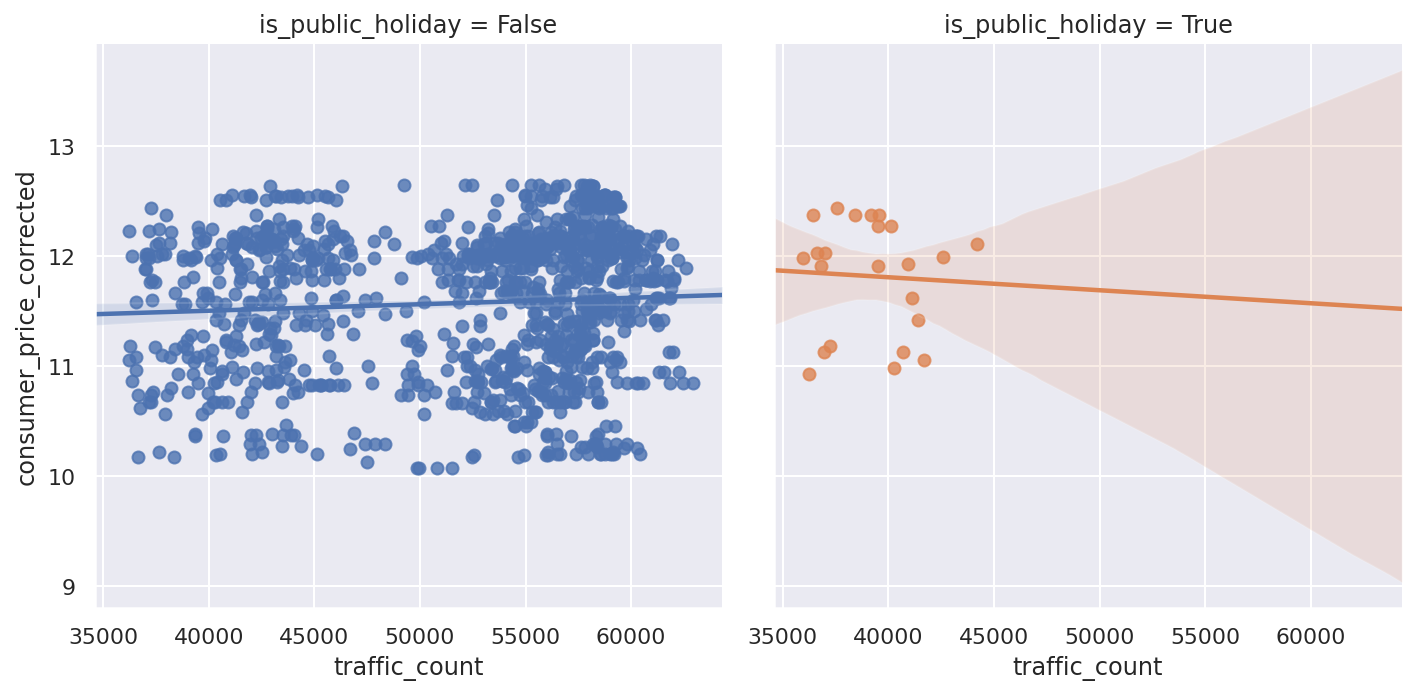

In [24]:
sns.lmplot(x="traffic_count", y="consumer_price_corrected", col="is_weekend", hue="is_weekend", data=df_traffic_gas, truncate=False)
sns.lmplot(x="traffic_count", y="consumer_price_corrected", col="is_public_holiday", hue="is_public_holiday", data=df_traffic_gas, truncate=False)

In [161]:
class Baseline:
    def __init__(self):
        self.mean = None

    def fit(self, X, y):
        self.mean = np.mean(y)
    
    def predict(self, X):
        # Check if X is a list of features, or just one feature
        if isinstance(X, list):
            return [self.mean] * len(X[0])
        else:
            return [self.mean] * len(X)

In [205]:
# X is predictors, y is target
target = 'traffic_count'
features = [col for col in df_traffic_gas.columns if col != target]
X = df_traffic_gas[features]
y = df_traffic_gas[target]

# Split according to a 70%/30% train/test policy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results_df = pd.DataFrame({'actuals': y_test, 'is_weekend': X_test['is_weekend'], 'is_public_holiday': X_test['is_public_holiday']})

lin_reg = Baseline()
lin_reg.fit(X_train, y_train) # Train the model

baseline_y_pred = lin_reg.predict(X_test) # Predict values
results_df["baseline"] = baseline_y_pred

#print("Coefficients: \n", lin_reg.coef_)
#print("Intercept: \n", lin_reg.intercept_)
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, baseline_y_pred))
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, baseline_y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, baseline_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, baseline_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, baseline_y_pred)))

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': baseline_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday');

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

Mean squared error: 56093405.18
Coefficient of determination: -0.00
Mean Absolute Error: 6564.305679872646
Mean Squared Error: 56093405.1799084
Root Mean Squared Error: 7489.553069436681


/opt/python/envs/default/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [204]:
# X is predictors, y is target
target = 'traffic_count'
features = [col for col in df_traffic_gas.columns if col != target]
X = df_traffic_gas[features]
y = df_traffic_gas[target]

# Split according to a 70%/30% train/test policy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train) # Train the model

baseline_y_pred = lin_reg.predict(X_test) # Predict values
results_df["linear_regression_features"] = baseline_y_pred

print("Coefficients: \n", lin_reg.coef_)
print("Intercept: \n", lin_reg.intercept_)
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, baseline_y_pred))
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, baseline_y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, baseline_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, baseline_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, baseline_y_pred)))

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': baseline_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday');

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

Coefficients: 
 [-13767.12936724 -11126.70215189    909.07838235  -2389.57428639
  -2118.92325335    -44.0140335    1358.65301866   1280.60122257
   2616.1838908   -5912.86141881    335.05541238   2376.9899502
   1299.32654028   1284.73091152    -86.16795435]
Intercept: 
 44882.940835029796
Mean squared error: 10993182.35
Coefficient of determination: 0.80
Mean Absolute Error: 2348.0700758412527
Mean Squared Error: 10993182.350002257
Root Mean Squared Error: 3315.5968316431745


/opt/python/envs/default/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Skriv noget klogt om Lineær
og om at one hot encode måneder

# ANN

Coefficients: 
 [-13767.12936724 -11126.70215189    909.07838235  -2389.57428639
  -2118.92325335    -44.0140335    1358.65301866   1280.60122257
   2616.1838908   -5912.86141881    335.05541238   2376.9899502
   1299.32654028   1284.73091152    -86.16795435]
Intercept: 
 44882.940835029796
Mean squared error: 14633245.64
Coefficient of determination: 0.74
Mean Absolute Error: 2963.5908169702934
Mean Squared Error: 14633245.639192125
Root Mean Squared Error: 3825.342551875861


/opt/python/envs/default/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


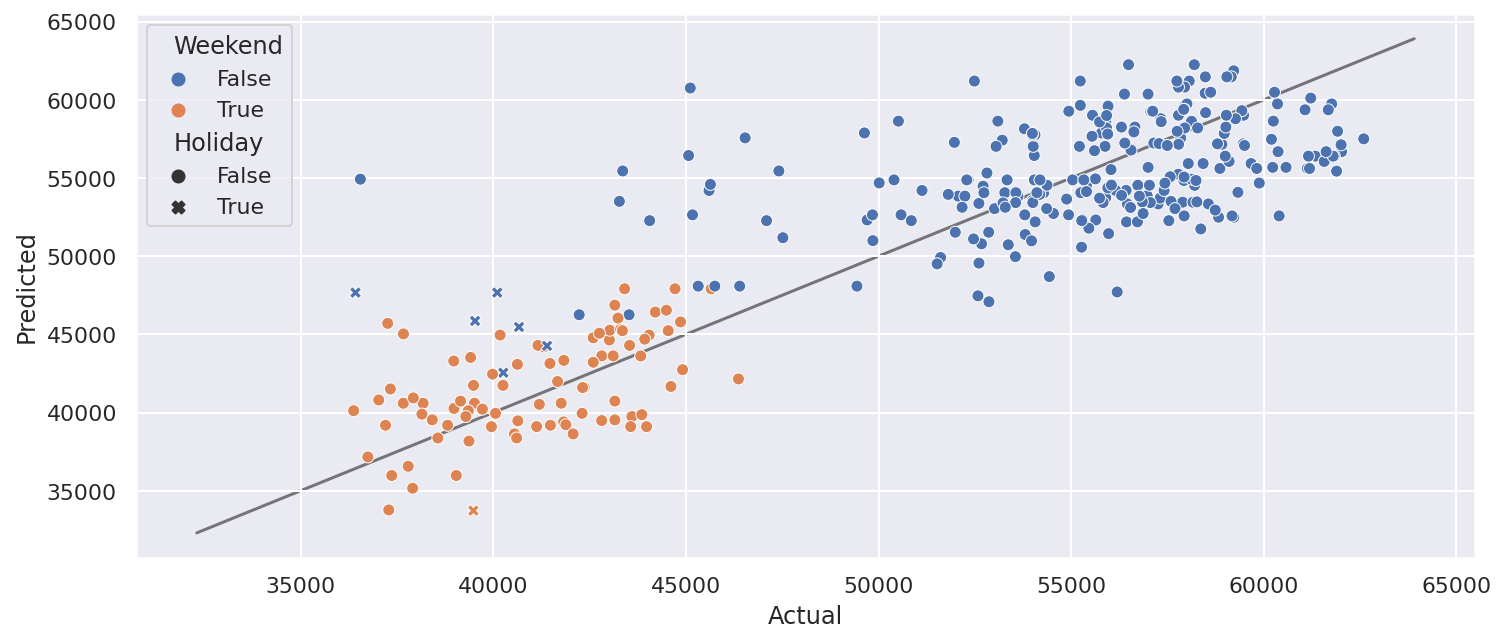

In [164]:
ann_reg = MLPRegressor(hidden_layer_sizes=(150,150,150,150),
                       max_iter = 500, activation='identity'
                       ).fit(X_train, y_train) # Neural network model for regression

#ann_reg.score(X_test, y_test)

ann_y_pred = ann_reg.predict(X_test) # Predict values

results_df["ann"] = ann_y_pred

print("Coefficients: \n", lin_reg.coef_)
print("Intercept: \n", lin_reg.intercept_)
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, ann_y_pred))
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, ann_y_pred))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ann_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ann_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ann_y_pred)))

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': ann_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday');
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

# t-test

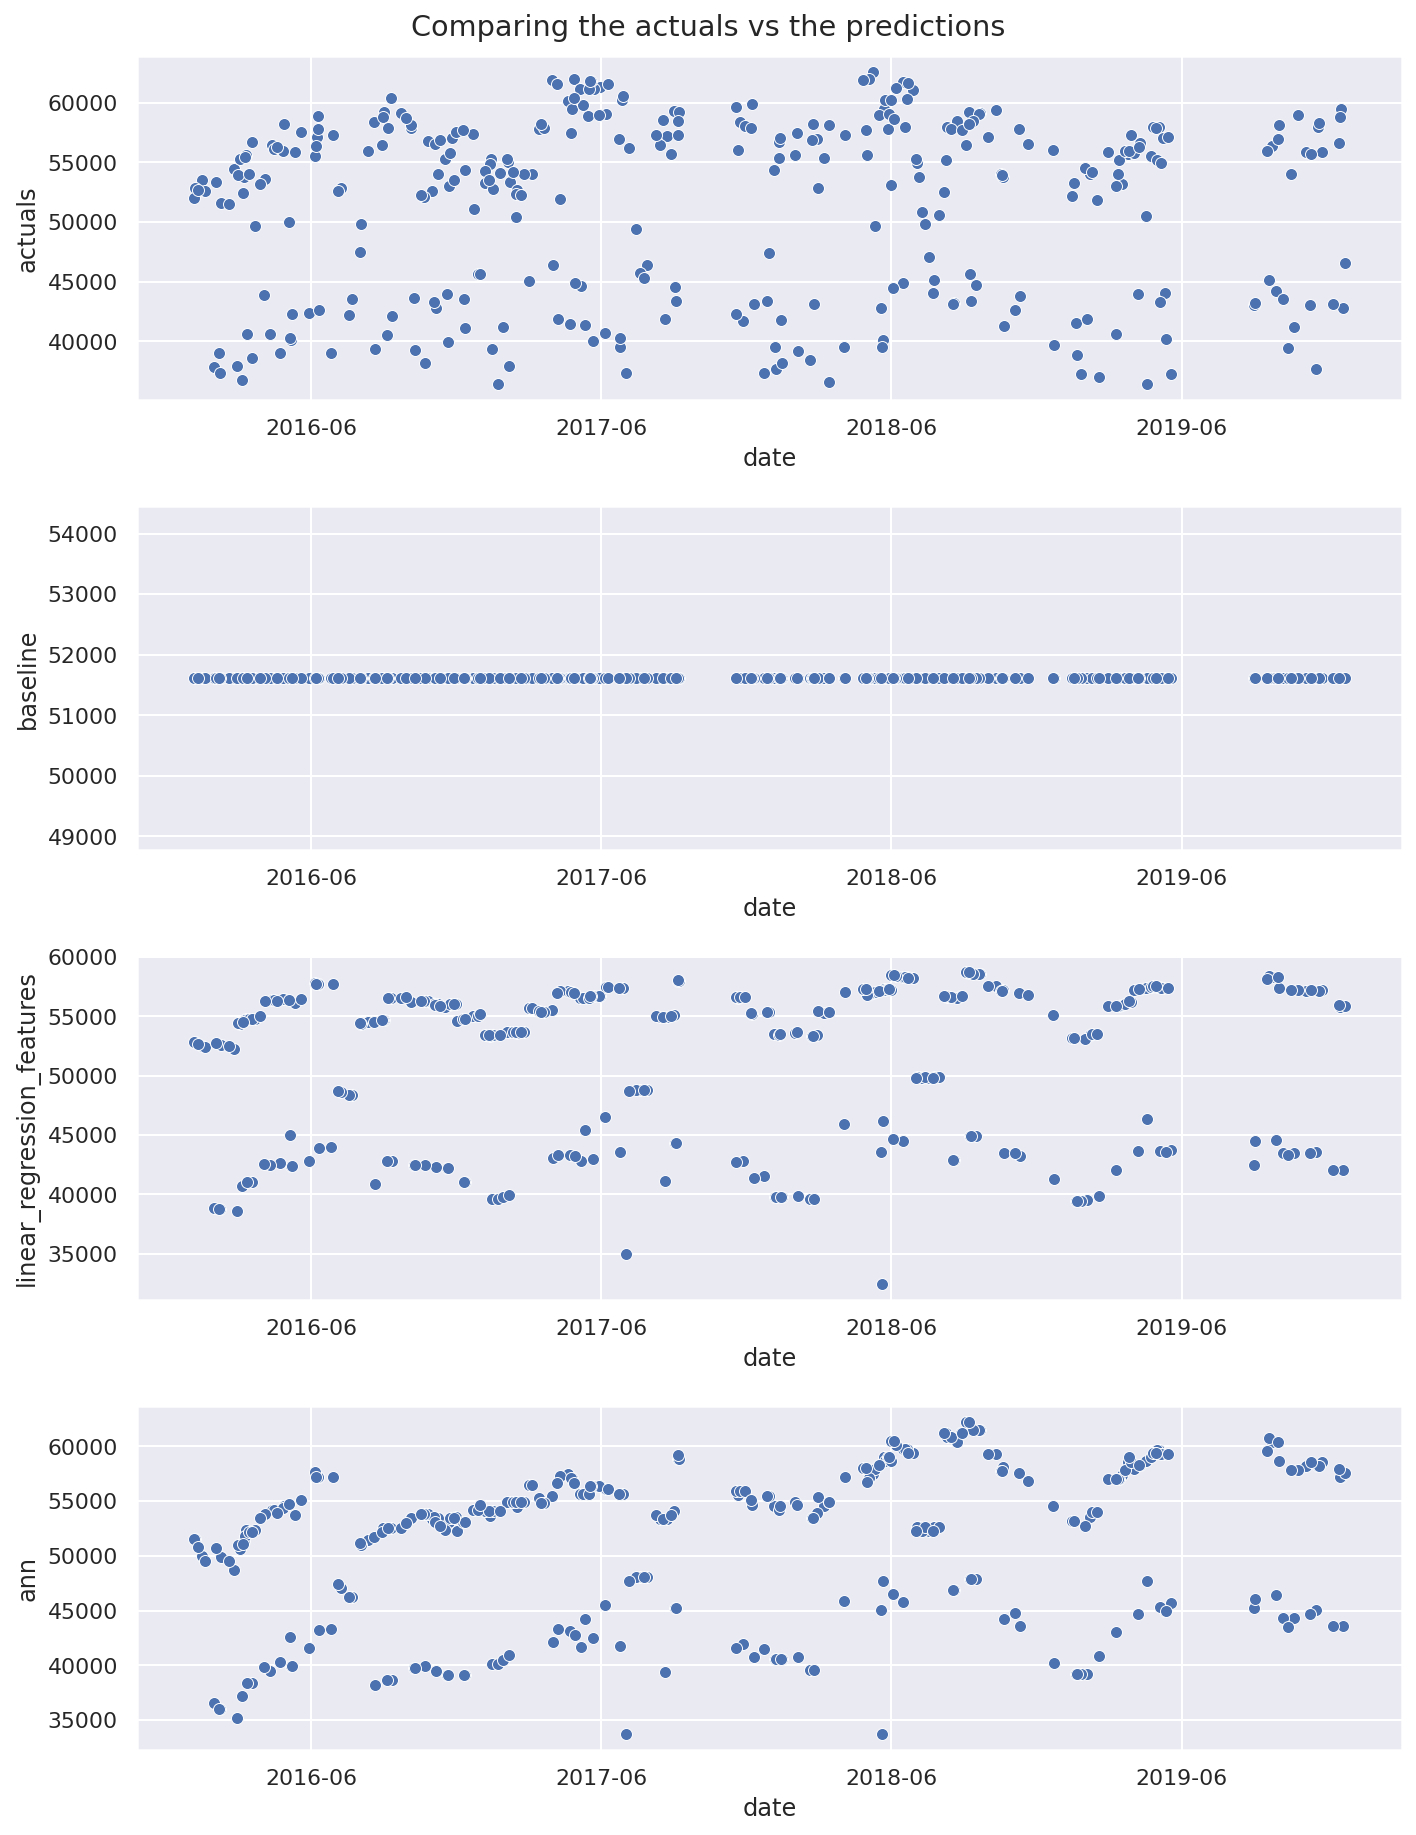

In [176]:
fig, axes = plt.subplots(4,1,figsize=(10,13))
plt.suptitle("Comparing the actuals vs the predictions")
gs = []
g1 = sns.scatterplot(data=results_df, x='date', y='actuals', ax=axes[0])
g2 = sns.scatterplot(data=results_df, x='date', y='baseline', ax=axes[1])
g3 = sns.scatterplot(data=results_df, x='date', y='linear_regression_features', ax=axes[2])
g4 = sns.scatterplot(data=results_df, x='date', y='ann', ax=axes[3])

g1.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))
g2.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))
g3.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))
g4.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))

plt.tight_layout()

In [191]:
results_df

actuals 
 is_weekend 
 is_public_holiday 
 baseline 
 linear_regression_features 
 ann 
 
 
 date 
 
 
 
 
 
 
 
 
 
 
 2019-11-17 
 37667.0 
 True 
 False 
 51612.096447 
 43532.121247 
 45027.285278 
 
 
 2019-11-10 
 43012.0 
 True 
 False 
 51612.096447 
 43443.705212 
 44641.177554 
 
 
 2018-06-16 
 44859.0 
 True 
 False 
 51612.096447 
 44516.986606 
 45792.524992 
 
 
 2016-06-10 
 58912.0 
 False 
 False 
 51612.096447 
 57693.271724 
 57153.665597 
 
 
 2019-05-19 
 37258.0 
 True 
 False 
 51612.096447 
 43695.382869 
 45701.811063 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2017-03-17 
 58240.0 
 False 
 False 
 51612.096447 
 55345.500234 
 54837.088743 
 
 
 2017-02-05 
 37923.0 
 True 
 False 
 51612.096447 
 39916.548727 
 40934.726229 
 
 
 2019-01-16 
 53290.0 
 False 
 False 
 51612.096447 
 53182.822025 
 53125.900823 
 
 
 2018-08-18 
 43154.0 
 True 
 False 
 51612.096447 
 42856.299457 
 46867.520133 
 
 
 2017-06-23 
 56997.0 
 False 
 False 
 51612.096447 
 57355.443371 
 55678.388678 
 
 
 
 338 rows × 6 columns

In [194]:
print(stats.ttest_ind(results_df['baseline'], results_df['linear_regression_features']))
print(stats.ttest_ind(results_df['baseline'], results_df['ann']))
print(stats.ttest_ind(results_df['linear_regression_features'], results_df['ann']))

Ttest_indResult(statistic=-0.547355380870423, pvalue=0.584315794364776)
Ttest_indResult(statistic=-0.25719636815754804, pvalue=0.7971056847355481)
Ttest_indResult(statistic=0.18336860767566782, pvalue=0.8545639529038085)


# Traffic/Covid Analysis

# Traffic during COVID (2020-2021) (Whomas Titting)
**Introductory text**

bla bla bla

### General patterns of traffic data
**Explanatory text**

Plot 1: Timeline plot of traffic counts with labeled highlights (maybe aggrevated, maybe for each location)

Plot 2: Traffic count distribution based on weekday/month

In [56]:
REF_YEARS = {'Mellem TSA 1 og 2': 2018, 'Tagensvej ml. Ægirsgade og Hermodsgade': 2017, 'Strandvejen ud for nr. 79': 2021}
streets = df_traffic['street'].unique()

df_day_ref = df_traffic.groupby([df_traffic['date'].dt.dayofyear, df_traffic['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})

ref_a = (df_traffic['street'] == 'Mellem TSA 1 og 2') & (df_traffic['date'].dt.year == 2018)
ref_b = (df_traffic['street'] == 'Tagensvej ml. Ægirsgade og Hermodsgade') & (df_traffic['date'].dt.year == 2017)
ref_c = (df_traffic['street'] == 'Strandvejen ud for nr. 79') & (df_traffic['date'].dt.year == 2021)
refs = [ref_a, ref_b, ref_c]

<ipython-input-57-ea5e5783ec47>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
<ipython-input-57-ea5e5783ec47>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
<ipython-input-57-ea5e5783ec47>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)


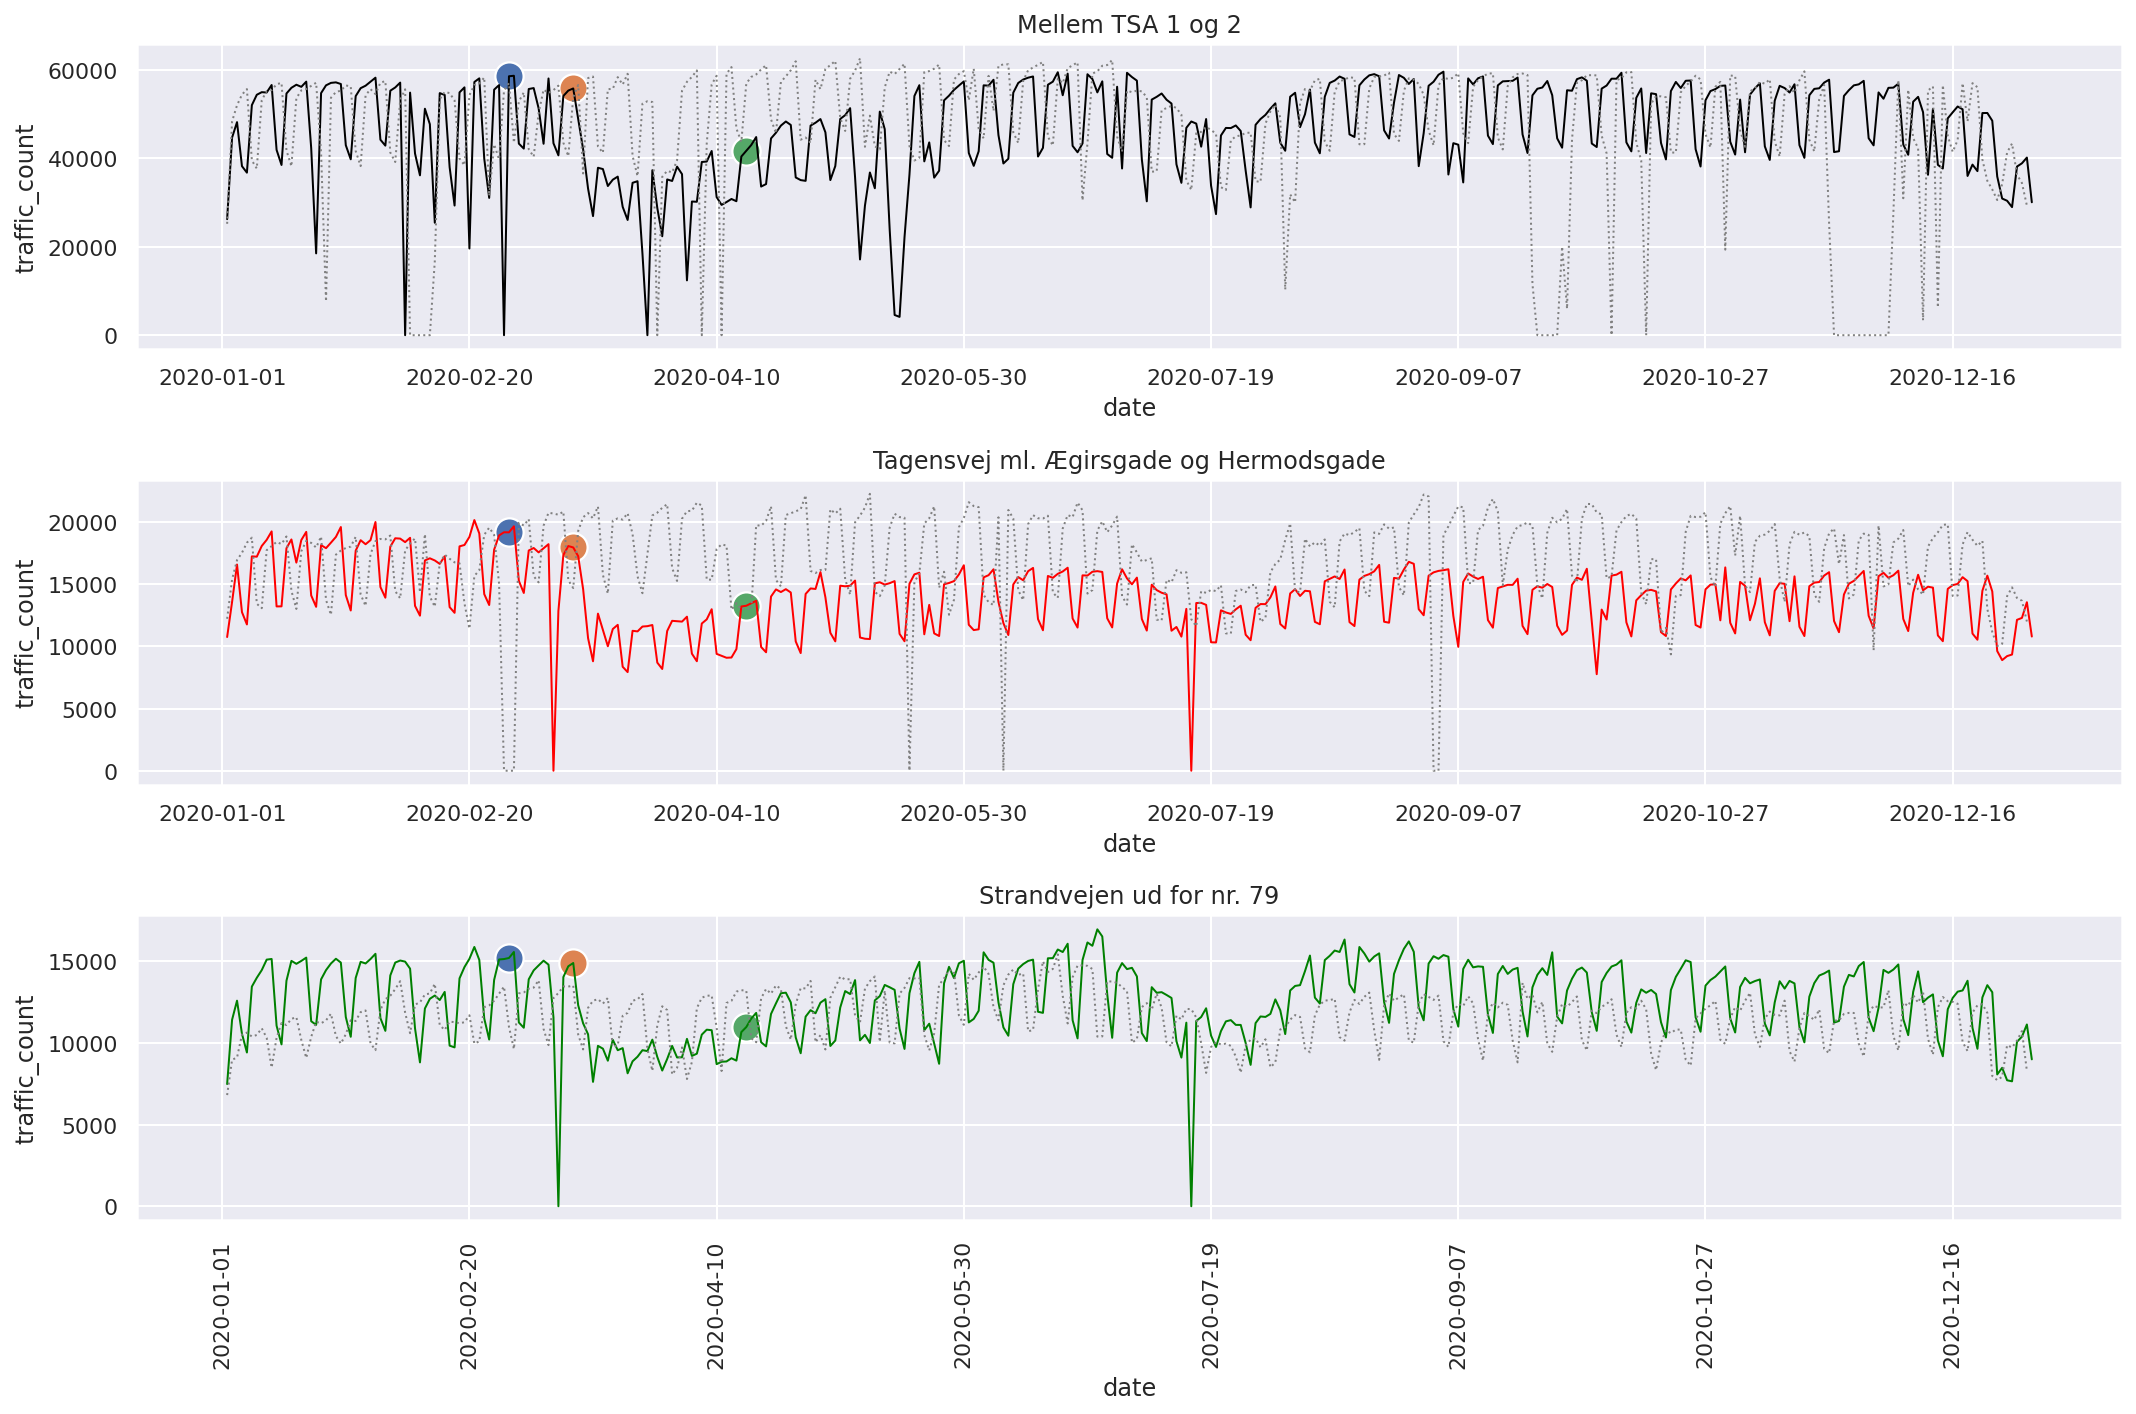

In [57]:
# Code here
streets = df_traffic['street'].unique()
df_day = df_traffic.groupby([df_traffic['date'].dt.date, df_traffic['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})
df_day_2020 = df_day.loc[df_day['date'].dt.year == 2020]

fig, axes = plt.subplots(3, 1, figsize=(15,10))
colors = ['black', 'red', 'green']
for i, (color, street, ref) in enumerate(zip(colors, streets, refs)):

    df_day_2020_street = df_day_2020.loc[df_day_2020['street'] == street]
    g = sns.lineplot(x=df_day_2020_street['date'].dt.dayofyear, y=df_day_2020_street['traffic_count'], color=color, linewidth=1, ax=axes[i])
    for date in COVID_DATES:
        sns.scatterplot(x=[date.timetuple().tm_yday], y=df_day_2020_street.loc[df_day_2020_street['date'] == date]['traffic_count'], s=200, ax=axes[i])
    
    df_day_ref = df_traffic.loc[ref]
    df_day_2020_street_ref = df_day_ref.groupby([df_day_ref['date'].dt.dayofyear], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})
    g = sns.lineplot(x=df_day_2020_street_ref['date'].dt.dayofyear, y=df_day_2020_street_ref['traffic_count'], color='grey', linestyle='dotted', linewidth=1, ax=axes[i])

    xlabels = [datetime.strptime('20' + str(int(x+1)).zfill(3), '%y%j').date() if 0 <= x <= 370 else datetime.strptime('18001', '%y%j').date() for x in g.get_xticks()]
    g.set_xticklabels(xlabels)
    g.set_title(street)
    #g.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))
    
plt.xticks(rotation=90)
plt.tight_layout()

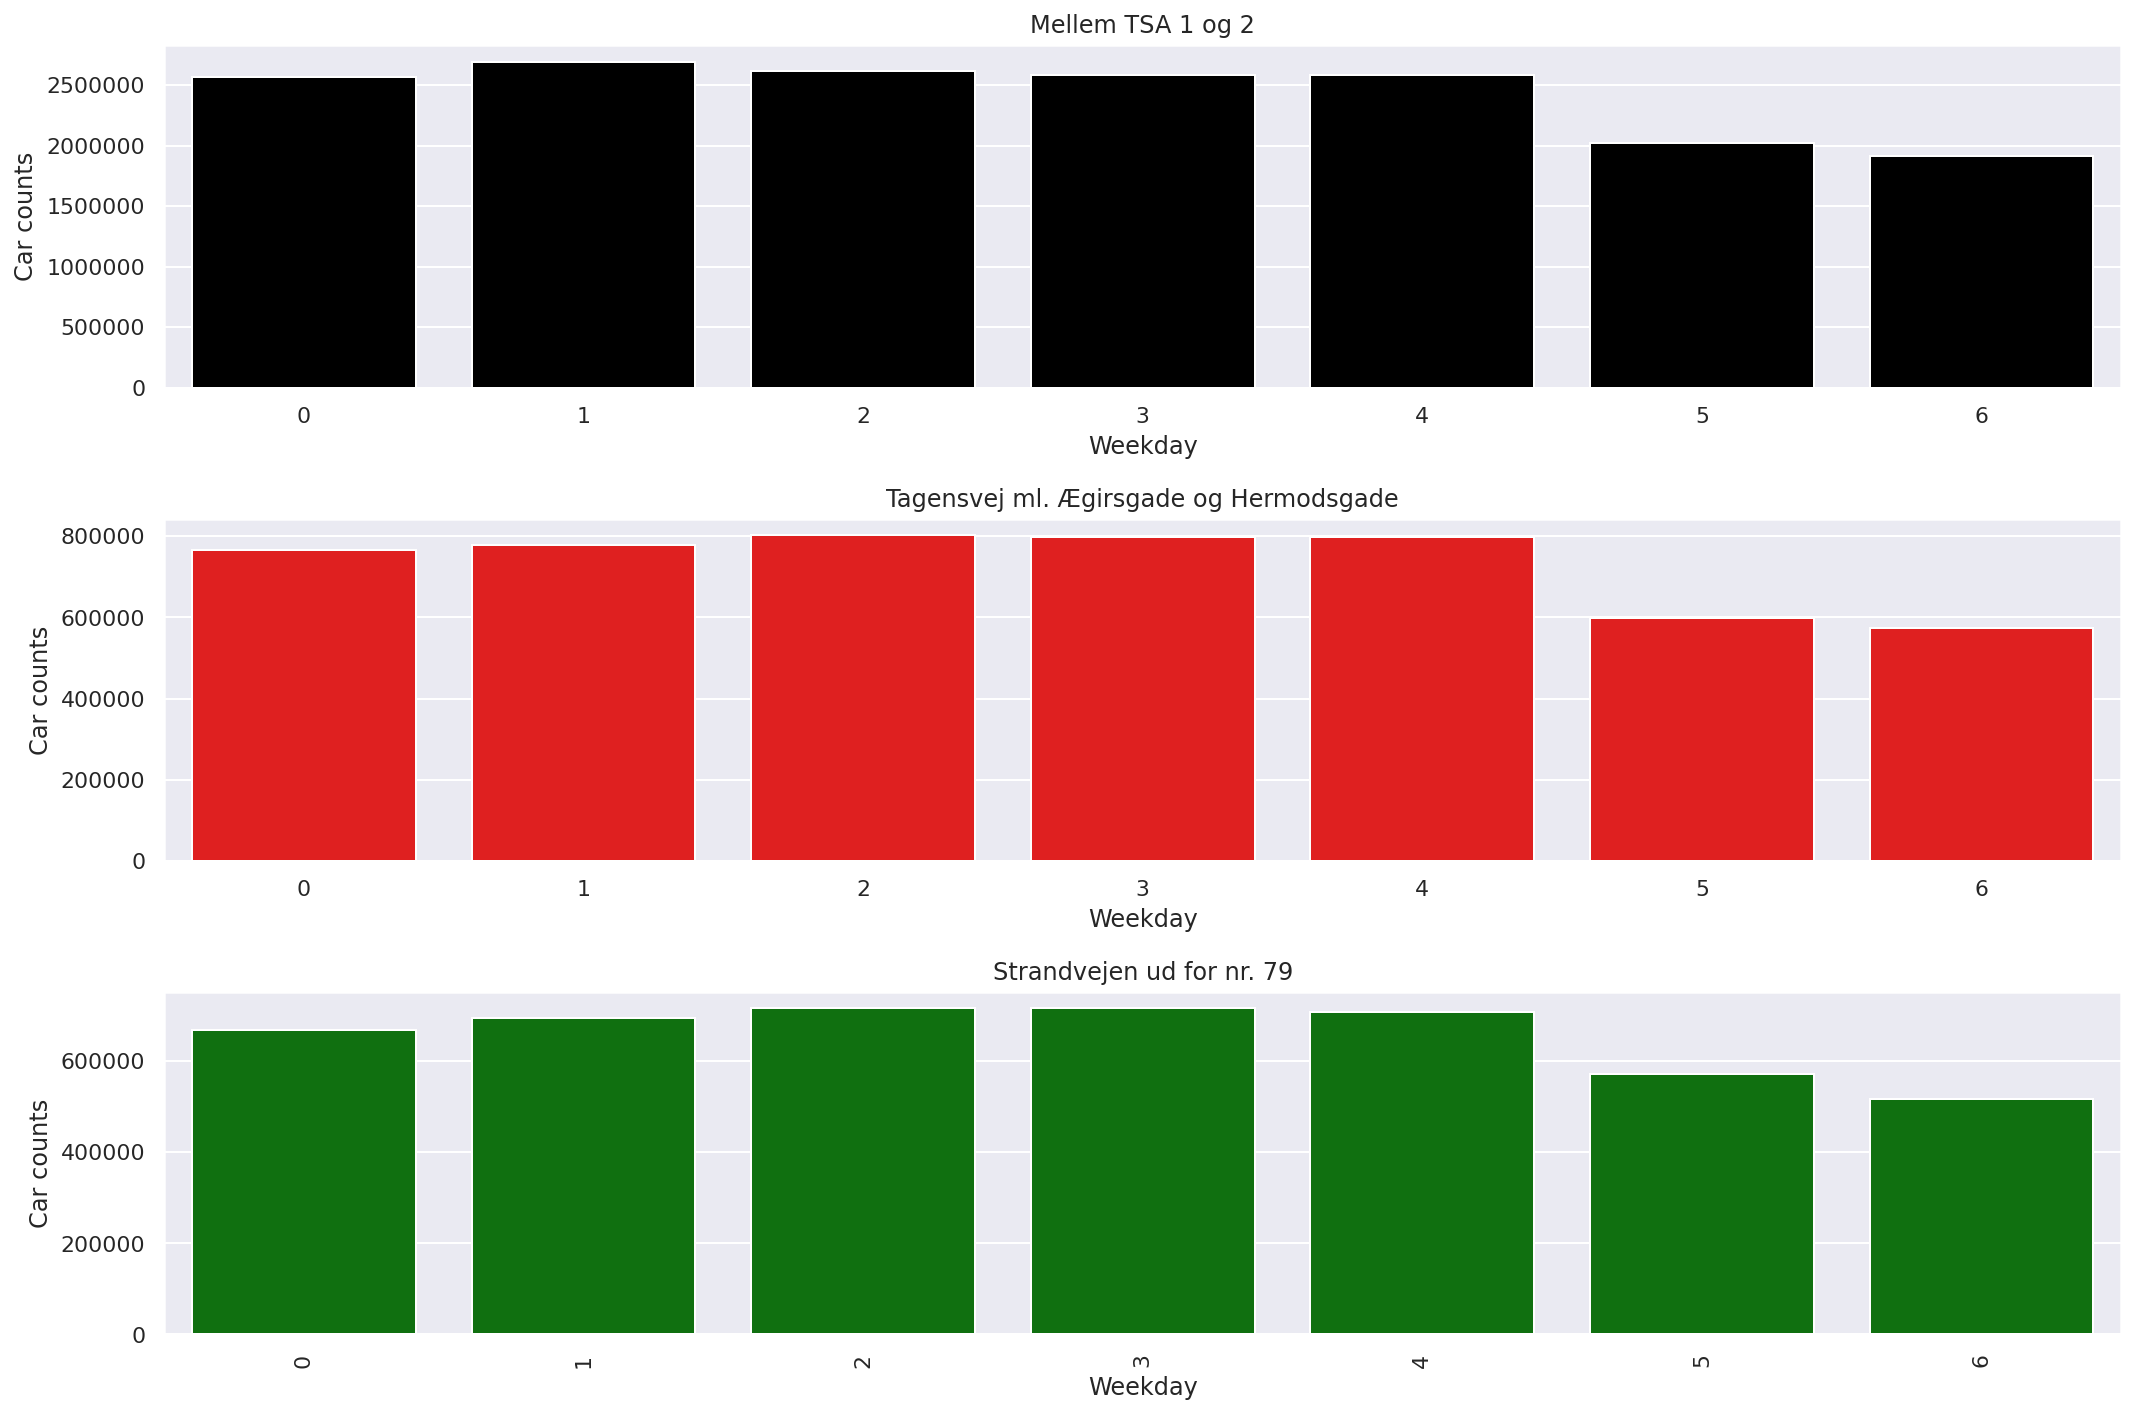

In [58]:
df_dayofweek_2020 = df_traffic.loc[df_traffic['date'].dt.year == 2020]
temp = pd.DatetimeIndex(df_dayofweek_2020['date'])
df_dayofweek_2020['weekday'] = temp.weekday


df_dayofweek_2020 = df_dayofweek_2020.groupby([df_dayofweek_2020['weekday'], df_dayofweek_2020['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})

fig, axes = plt.subplots(3, 1, figsize=(15,10))
colors = ['black', 'red', 'green']
for i, (color, street) in enumerate(zip(colors, streets)):
    df_dayofweek_2020_street = df_dayofweek_2020.loc[df_dayofweek_2020['street'] == street]
    g = sns.barplot(data=df_dayofweek_2020_street, x='weekday', y='traffic_count', color=color, linewidth=1, ax=axes[i])
    g.set_title(street) 
    g.set_xlabel('Weekday')
    g.set_ylabel('Car counts')
    g.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=90);
plt.tight_layout()

### General patterns of COVID data
**Explanatory text**

Plot 1: Timeline plot of COVID cases/deaths/tests with labeled highlights
Plot 2: Copenhagen specific COVID plot

In [59]:
# Code here
columns = ['municipality', 'date', 'cases']
df_covid = pd.read_csv('07_bekraeftede_tilfaelde_pr_dag_pr_kommune.csv', usecols=['Kommunenavn', 'Dato', 'Bekræftede tilfælde i alt'], sep=';', encoding='latin-1')
df_covid.columns = columns
df_covid['date'] = pd.to_datetime(df_covid['date'])
df_covid = df_covid.loc[df_covid['date'].dt.year == 2020]
df_covid = df_covid.groupby([df_covid['date'].dt.date], as_index=False).agg({'date': 'first', 'cases': 'sum'})

In [60]:
# Code here
columns = ['date', 'hospitalizations']
df_hospitalizations = pd.read_csv('05_nye_indlaeggelser_pr_dag.csv', sep=';', encoding='latin-1')
df_hospitalizations.columns = columns
df_hospitalizations['date'] = pd.to_datetime(df_hospitalizations['date'])
df_hospitalizations = df_hospitalizations.loc[df_hospitalizations['date'].dt.year == 2020]

df_covid = pd.merge(df_covid, df_hospitalizations, on="date")

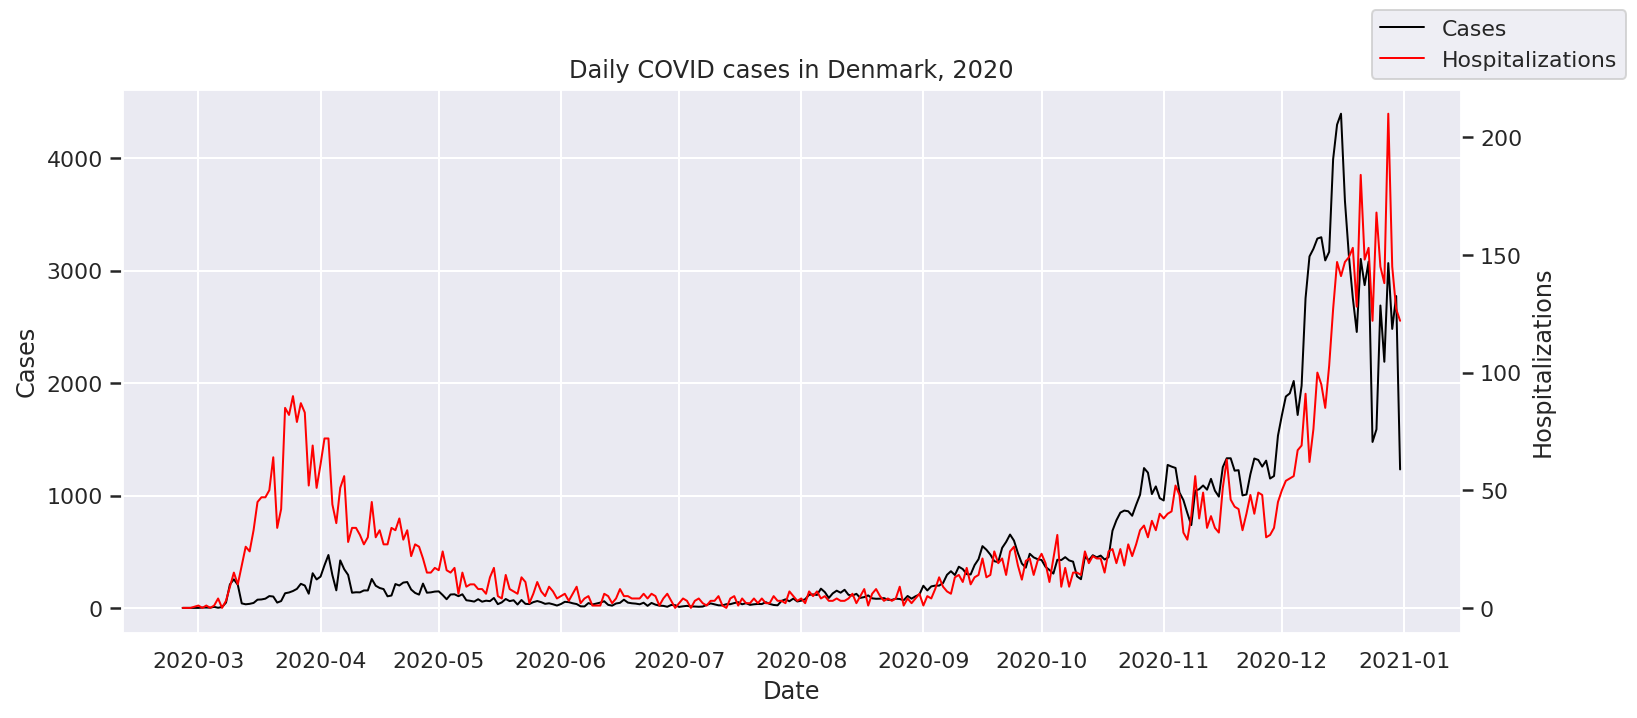

In [61]:
fig = plt.figure()

g1 = sns.lineplot(data=df_covid, x='date', y='cases', color='black', linewidth=1, legend=False)
ax2 = plt.twinx()
ax2.grid(False)
g2 = sns.lineplot(data=df_covid, x='date', y='hospitalizations', color='red', linewidth=1, legend=False)
g1.set_title('Daily COVID cases in Denmark, 2020')
g1.set_xlabel('Date')
g1.set_ylabel('Cases')
g2.set_ylabel('Hospitalizations')

fig.legend(['Cases' , 'Hospitalizations'], loc=1);

### Linking traffic to COVID
**Explanatory text**

Ideas:
- Comparing difference in means/peaks/lows
- Duration of peaks/lows
- Time of peaks/lows
- Impact of new restrictions/reopenings

Plot ideas:
- Show the difference when comparing with a normal year (i.e. bar plot where a bar is positive if more cars are counted than the reference year, and negative if fewer cars are counted)
- 

In [62]:
# Code here
df_tc = pd.merge(df_covid, df_day_2020, on='date')
#df_tc = df_day_2020

<ipython-input-63-d04beb18b111>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
<ipython-input-63-d04beb18b111>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
<ipython-input-63-d04beb18b111>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)


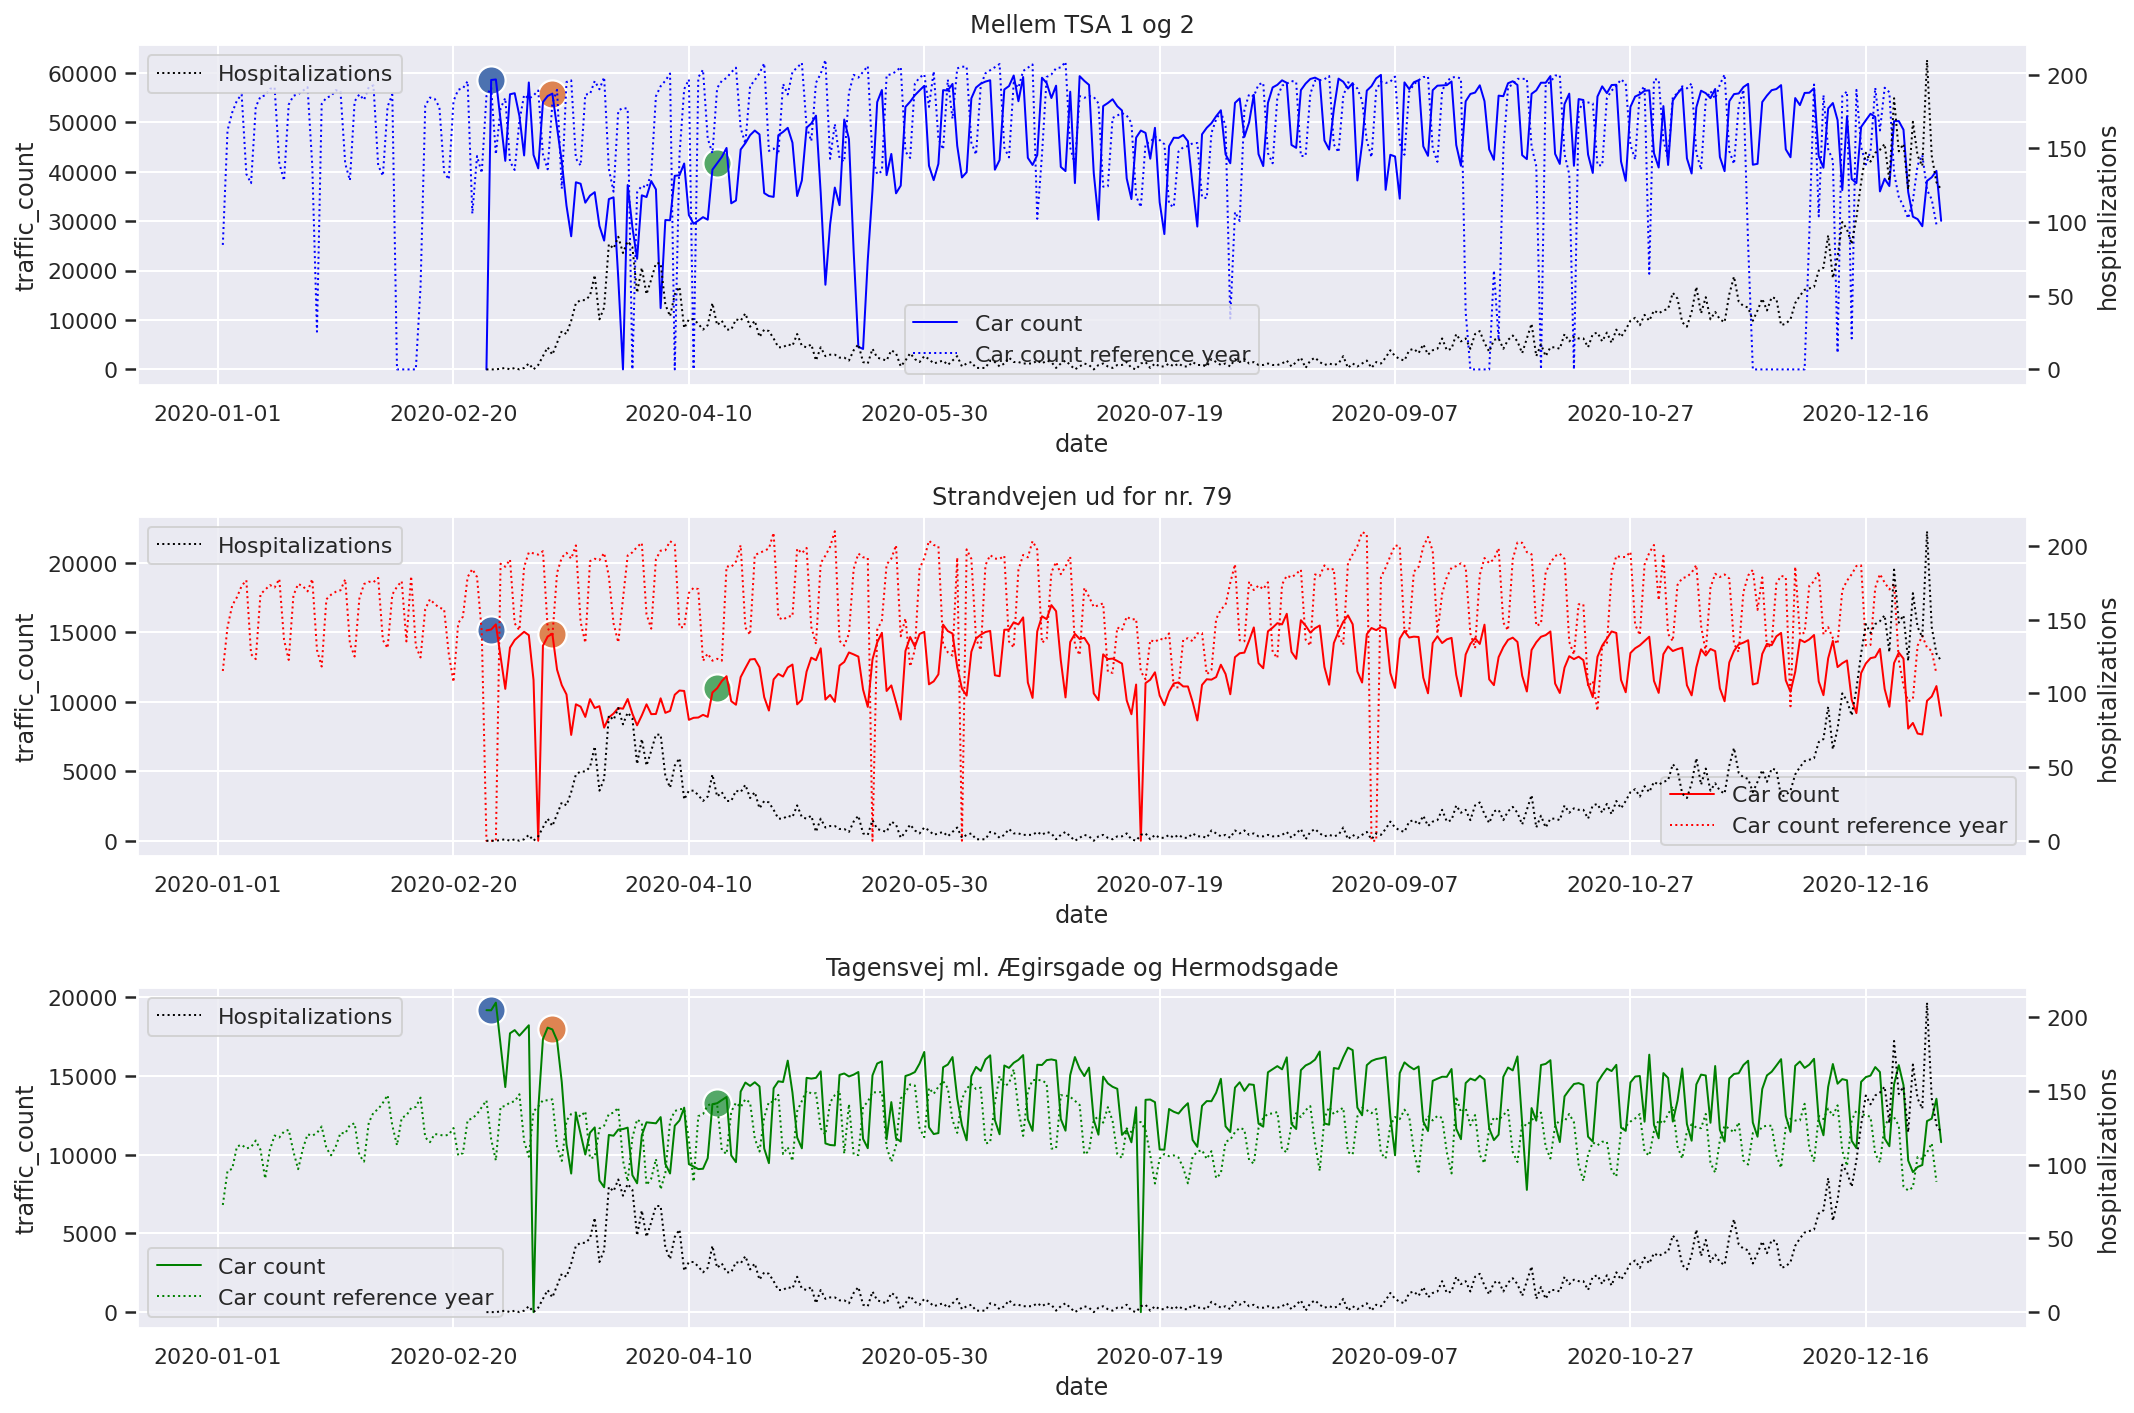

In [63]:
# Code here
streets = df_tc['street'].unique()
df_tc_week = df_tc.groupby([df_tc['date'].dt.dayofyear, df_tc['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'cases': 'sum', 'hospitalizations': 'sum', 'direction': 'first'})
fig, axes = plt.subplots(3, 1, figsize=(15,10))
colors = ['blue', 'red', 'green']
a = None
for i, (color, street, ref) in enumerate(zip(colors, streets, refs)):
    df_day_2020_street = df_tc_week.loc[df_tc_week['street'] == street]
    g = sns.lineplot(x=df_day_2020_street['date'].dt.dayofyear, y=df_day_2020_street['traffic_count'], color=color, linewidth=1, ax=axes[i], label='Car count')
    
    df_day_ref = df_traffic.loc[ref]
    df_day_2020_street_ref = df_day_ref.groupby([df_day_ref['date'].dt.dayofyear], as_index=False).agg({'date': 'first', 'traffic_count': 'sum', 'direction': 'first'})
    g = sns.lineplot(x=df_day_2020_street_ref['date'].dt.dayofyear, y=df_day_2020_street_ref['traffic_count'], color=color, linestyle='dotted', linewidth=1, ax=axes[i], label='Car count reference year')

    xlabels = [datetime.strptime('20' + str(int(x+1)).zfill(3), '%y%j').date() if 0 <= x <= 370 else datetime.strptime('18001', '%y%j').date() for x in g.get_xticks()]
    g.set_xticklabels(xlabels)
 
    g.set_title(street)
    #g.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))    
    for date in COVID_DATES:
        sns.scatterplot(x=[date.timetuple().tm_yday], y=df_day_2020_street.loc[df_day_2020_street['date'] == date]['traffic_count'], s=200, ax=axes[i])
       
    ax2 = axes[i].twinx()
    sns.lineplot(x=df_day_2020_street['date'].dt.dayofyear, y=df_day_2020_street['hospitalizations'], color='black', linewidth=1, label='Hospitalizations', linestyle='dotted')
    ax2.grid(False)
    axes[i].set_axisbelow(True)
    
plt.xticks(rotation=90)
plt.tight_layout()

2101.0


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


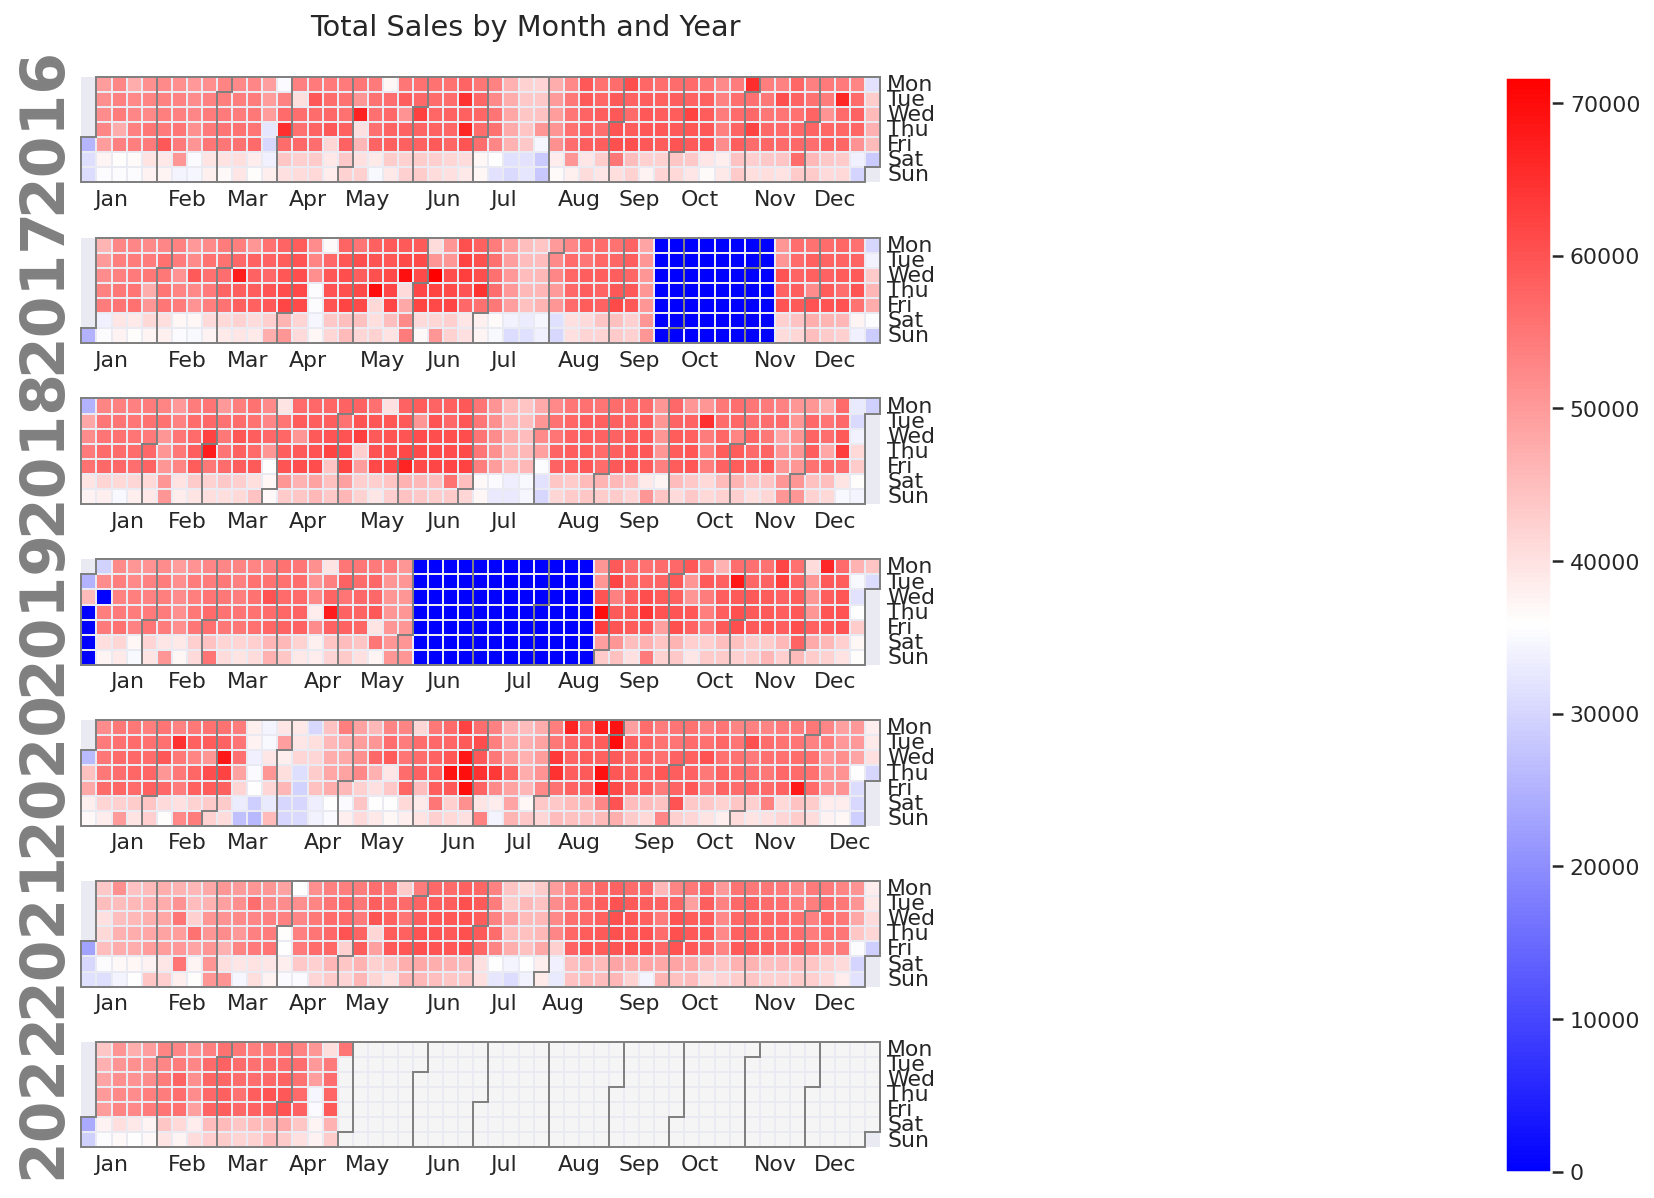

In [64]:
df_ = df_traffic
df_ = df_.loc[df_['street'] == 'Mellem TSA 1 og 2']
df_['traffic_count'] = df_['traffic_count'].replace(0,df_['traffic_count'].median())
df_['traffic_count'] = df_['traffic_count'].replace(np.nan,df_['traffic_count'].median())
median = df_['traffic_count'].median()
#df_ = df_.loc[df_['date'].dt.year == 2022]
df_ = df_.set_index('date')
print(median)
pl1 = calplot.calplot(data = df_['traffic_count'],how = 'sum', cmap = 'bwr', figsize = (16, 8), suptitle = "Total Sales by Month and Year")

In [65]:
df_traffic.head()

date 
 traffic_count 
 street 
 direction 
 is_public_holiday 
 is_weekend 
 coordinates 
 
 
 
 
 96 
 2016-01-01 00:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 96 
 2016-01-01 00:00:00 
 511.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 97 
 2016-01-01 01:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 97 
 2016-01-01 01:00:00 
 681.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 98 
 2016-01-01 02:00:00 
 1205.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424]

In [66]:
df_tc['traffic_count'].corr(df_tc['hospitalizations'])

-0.07104798113408582

# Traffic/Covid Analysis Report

# Traffic during COVID (2020) (Thomas Witting)
**Introductory text explaining overall method and purpose of this section**

### Data Preparation

Read and prepare dataframe containing related traffic and COVID features.

In [31]:
#### Combine traffic and COVID related into single dataframe, containing data for 2020 on a daily basis ####
# Get traffic on a daily basis for 2020
df_traffic_day = df_traffic.groupby([df_traffic['date'].dt.date, df_traffic['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum'})
df_traffic_2020 = df_traffic_day.loc[df_traffic_day['date'].dt.year == 2020]

# Get reference data for traffic for each street
ref_a = (df_traffic['street'] == 'Mellem TSA 1 og 2') & (df_traffic['date'].dt.year == 2018)
ref_b = (df_traffic['street'] == 'Tagensvej ml. Ægirsgade og Hermodsgade') & (df_traffic['date'].dt.year == 2017)
ref_c = (df_traffic['street'] == 'Strandvejen ud for nr. 79') & (df_traffic['date'].dt.year == 2021)

df_ref = df_traffic.loc[ref_a | ref_b | ref_c]
df_ref_day = df_ref.groupby([df_ref['date'].dt.dayofyear, df_ref['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum'})
df_ref_day['date'] = df_ref_day['date'].apply(lambda x: x.replace(year = 2020))
df_ref_day = df_ref_day.rename(columns={'traffic_count': 'traffic_count_ref'})

df_traffic_2020 = pd.merge(df_traffic_2020, df_ref_day, how='left', left_on=['date','street'], right_on=['date','street'],)

# Get COVID cases data on a daily basis
columns = ['municipality', 'date', 'cases']
df_cases = pd.read_csv('07_bekraeftede_tilfaelde_pr_dag_pr_kommune.csv', usecols=['Kommunenavn', 'Dato', 'Bekræftede tilfælde i alt'], sep=';', encoding='latin-1')
df_cases.columns = columns
df_cases['date'] = pd.to_datetime(df_cases['date'])
df_cases = df_cases.loc[df_cases['date'].dt.year == 2020]
df_cases = df_cases.groupby([df_cases['date'].dt.date], as_index=False).agg({'date': 'first', 'cases': 'sum'})

# Get COVID hospitalizations data on a daily basis
columns = ['date', 'hospitalizations']
df_hospitalizations = pd.read_csv('05_nye_indlaeggelser_pr_dag.csv', sep=';', encoding='latin-1')
df_hospitalizations.columns = columns
df_hospitalizations['date'] = pd.to_datetime(df_hospitalizations['date'])
df_hospitalizations = df_hospitalizations.loc[df_hospitalizations['date'].dt.year == 2020]

# Collect COVID related data to single dataframe
df_covid = pd.merge(df_cases, df_hospitalizations, on="date")

# Merge traffic data with COVID data
df_tc = pd.merge(df_covid, df_traffic_2020, on='date', how='right').fillna(0)

# Unique streets
streets = df_tc['street'].unique()

### Getting to know the data
**Plot basic distribution etc**

**Histograms**

In [235]:
def bokeh_deepnote_show(plot):
    tmp_output_filename = tempfile.NamedTemporaryFile(suffix='.html').name
    output_file(tmp_output_filename)
    save(plot)

    f = open(tmp_output_filename, "r")
    display(HTML(f.read()))

#Convert your DataFrame to Bokeh ColumnDataSource
src = ColumnDataSource(df_tc.groupby(df_tc['street']).agg({'cases' : 'sum', 'hospitalizations': 'sum', 'traffic_count': 'sum',
       'traffic_count_ref': 'sum'}))

#Create an empty figure
p_traffic = figure(plot_width = 350, plot_height = 500, title = 'Traffic count 2022',
           x_axis_label = None, y_axis_label = 'Count', x_range = FactorRange(factors=df_tc['street'].unique()), background_fill_color="#fafafa") 

#Define the columns to use for each bar
bar_cols = ['traffic_count']
legends = bar_cols

#Add bars by using p.var
bar = {}
for i, col in enumerate(bar_cols):
    bar[col] = p_traffic.vbar(x='street',  top=col, source=src, width=0.5, alpha=0.5, muted = False, fill_color="green", line_color="white")
    
p_traffic.xaxis.major_label_orientation = "vertical"

TOOLTIPS = [
    ("Total cars counted", "@traffic_count")
]

p_traffic.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[bar[bar_cols[0]]]))

# HISTOGRAMS
def make_plot(title, hist, edges, p=None):
    if p is None:
        p = figure(title=title, tools='', plot_width = 350, plot_height = 500, background_fill_color="#fafafa")

    color = "navy" if p is None else "green"
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=color, line_color="white", alpha=0.5)

    #p.y_range.start = 0
    p.xaxis.axis_label = ''
    p.yaxis.axis_label = 'Count'
    p.grid.grid_line_color="white"
    return p

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[0]]['traffic_count'], density=False, bins=25)
phist1 = make_plot(streets[0], hist, edges)

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[1]]['traffic_count'], density=False, bins=25)
phist2 = make_plot(streets[1], hist, edges)

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[2]]['traffic_count'], density=False, bins=25)
phist3 = make_plot(streets[2], hist, edges)

#HISTOGRAMS CASES/HOSPITALIZATIONS
hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[0]]['cases'], density=False, bins=25)
phistcases = make_plot('Cases distribution', hist, edges)

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[1]]['hospitalizations'], density=False, bins=25)
phisthospitalizations = make_plot('Hospitalizations distribution', hist, edges)



phist1.yaxis.formatter.use_scientific = False
phist2.yaxis.formatter.use_scientific = False
phist3.yaxis.formatter.use_scientific = False
p_traffic.yaxis.formatter.use_scientific = False
phistcases.yaxis.formatter.use_scientific = False
phisthospitalizations.yaxis.formatter.use_scientific = False

gp1 = gridplot([phist1, phist2, phist3], ncols=3, toolbar_location=None)
gp2 = gridplot([phistcases, phisthospitalizations], ncols=2, toolbar_location=None)
l1 = layout([[p_traffic]])
l2 = layout([[gp1]])
l3 = layout([[gp2]])

tab1 = Panel(child=l1,title='Traffic count')
tab2 = Panel(child=l2,title='Histogram Traffic')
tab3 = Panel(child=l3,title='Histogram COVID')
tabs = Tabs(tabs=[tab1, tab2, tab3])
curdoc().add_root(tabs)
bokeh_deepnote_show(tabs)

<!DOCTYPE html>
 
 
 
 
 
 Bokeh Plot

**Timeline overview plot**

Investigating a timeline plot for each street during the year of 2020 and comparing it with traffic counts from a reference year, some patterns are already visible. For all three streets, they follow a near-identical pattern with the reference year during January and February, while they all deviate significantly at the start of March – coinciding with the onset of COVID in Denmark. During the following months, the traffic seems to climb back 

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        
numeric_columns = df_tc.select_dtypes(include=np.number).columns.tolist()
plot_kinds = ['hist', 'timeline', '']

for i, (street, column) in enumerate(zip(streets, numeric_columns)):
    df_tc_street = df_tc.loc[df_tc['street'] == street]
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count'], color='red', linewidth=1, ax=axes[i], label='Car count', zorder=1)
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count_ref'], color='black', linestyle='dotted', linewidth=1, ax=axes[i], label='Reference data', zorder=0)
    #for date, label in zip(COVID_DATES, ['First case', 'First lockdown', 'First reopening']):
    #        sns.scatterplot(x=df_tc_street['date'], y=df_tc_street.loc[df_tc_street['date'] == date]['traffic_count'], s=200, ax=axes[i], zorder=2, label=label)
        
    g.set_title(street)

fig.suptitle('Timeline per street')
plt.tight_layout()

**Timeline for traffic and COVID combined**

Text explaining whats visible in plot below

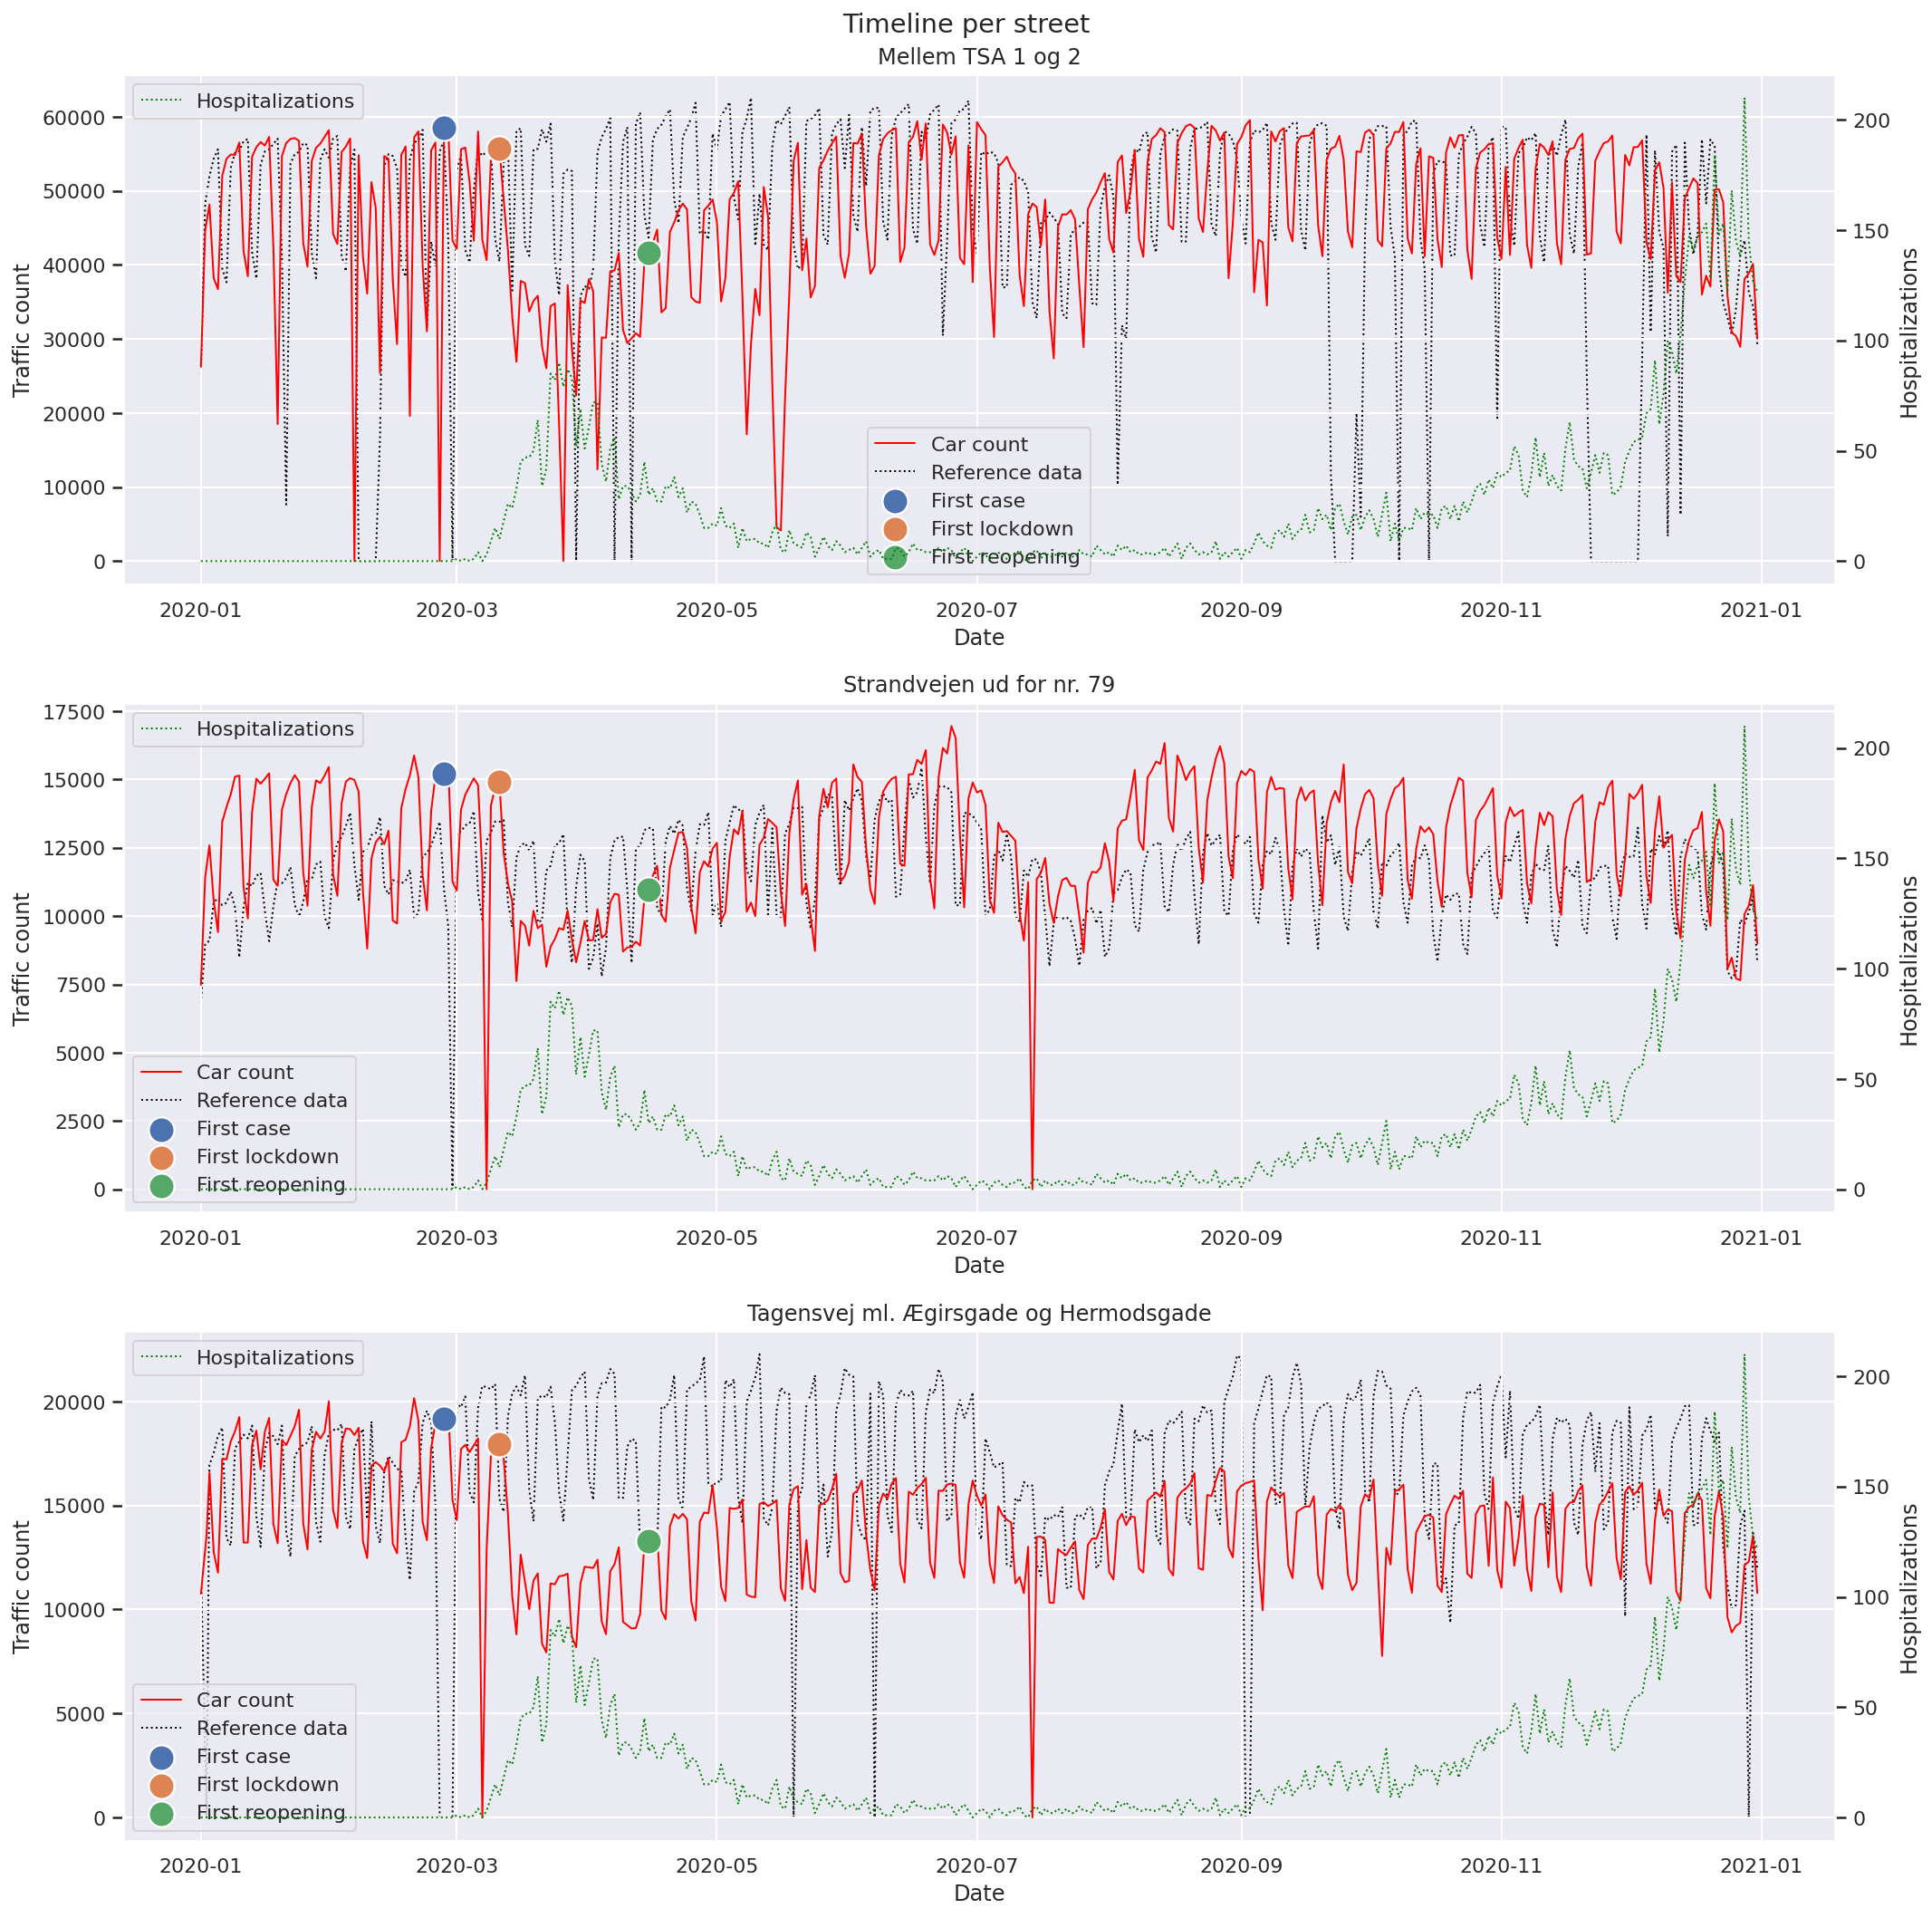

In [197]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

for i, street in enumerate(streets):
    df_tc_street = df_tc.loc[df_tc['street'] == street]
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count'], color='red', linewidth=1, ax=axes[i], label='Car count', zorder=1)
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count_ref'], color='black', linestyle='dotted', linewidth=1, ax=axes[i], label='Reference data', zorder=0)
    
    ax2 = axes[i].twinx()
    ax2.grid(False)
    g2 = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['hospitalizations'], color='green', linestyle='dotted', linewidth=1, axes=ax2, label='Hospitalizations')
    
    for date, label in zip(COVID_DATES, ['First case', 'First lockdown', 'First reopening']):
            sns.scatterplot(x=df_tc_street['date'], y=df_tc_street.loc[df_tc_street['date'] == date]['traffic_count'], s=200, ax=axes[i], zorder=2, label=label)
    
    g.set_title(street)
    g.set_xlabel('Date')
    g.set_ylabel('Traffic count')
    g2.set_ylabel('Hospitalizations')

fig.suptitle('Timeline per street')
plt.tight_layout()

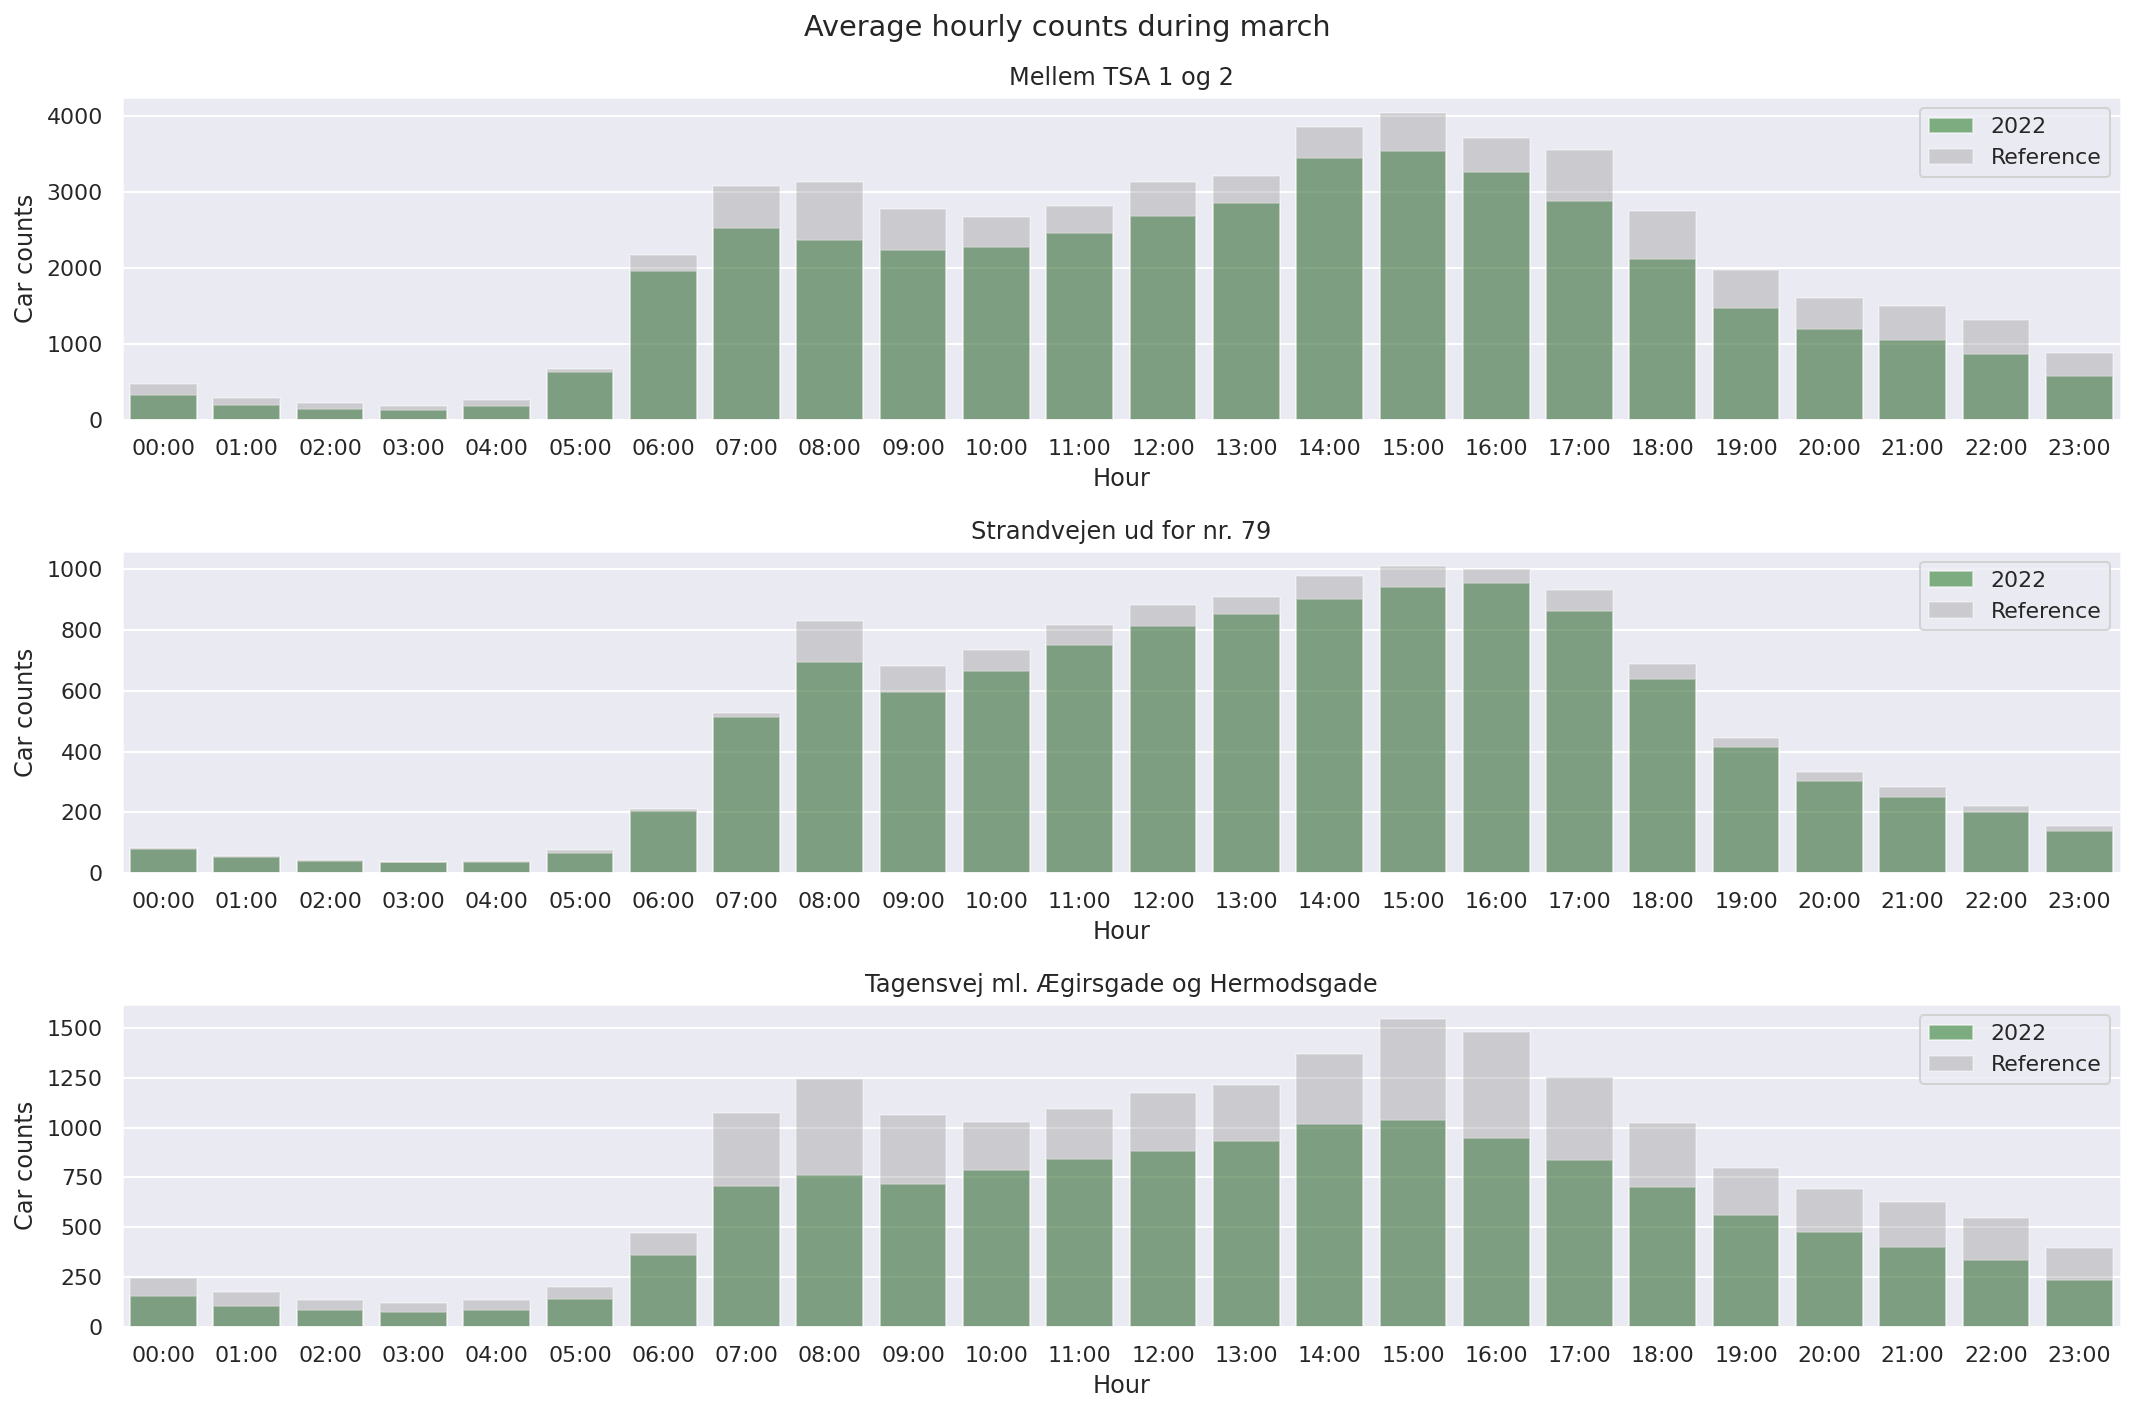

In [230]:
# Plots of hourly counts averaged over the month of march
df_march = df_traffic[df_traffic['date'].map(lambda x : (x.year == 2020) & (x.month == 3))]
df_march['hour'] = df_march['date'].dt.strftime('%H:%M')
df_hour = df_march.groupby([df_march['date'].dt.hour, df_march['street']], as_index=False).agg({'hour': 'first', 'traffic_count': 'mean'})

df_march_ref = df_ref[df_ref['date'].map(lambda x : x.month == 3)]
df_march_ref['hour'] = df_march_ref['date'].dt.strftime('%H:%M')
df_hour_ref = df_march_ref.groupby([df_march_ref['date'].dt.hour, df_march_ref['street']], as_index=False).agg({'hour': 'first', 'traffic_count': 'mean'})



fig, axes = plt.subplots(3, 1, figsize=(15,10))

for i, street in enumerate(streets):
    df_hour_street = df_hour.loc[df_hour['street'] == street]
    df_hour_street_ref = df_hour_ref.loc[df_hour_ref['street'] == street]
    g = sns.barplot(data=df_hour_street, x='hour', y='traffic_count', color='green', alpha=0.5, linewidth=1, ax=axes[i], label='2022')
    g = sns.barplot(data=df_hour_street_ref, x='hour', y='traffic_count', color='grey', alpha=0.3, linewidth=1, ax=axes[i], label='Reference')
    g.set_title(street) 
    g.set_xlabel('Hour')
    g.set_ylabel('Car counts')
    g.legend()
    g.ticklabel_format(style='plain', axis='y')

fig.suptitle('Average hourly counts during march')
plt.tight_layout()

# Final

# **An Exploratory Analysis of Traffic in the Copenhagen Metropolitan Area**

## *Explainer Notebook*

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklego.preprocessing import RepeatingBasisFunction
import math
from collections import Counter
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

#plt.style.use('seaborn-dark-palette')
sns.set(rc={'figure.figsize': (15, 6)})
% config
InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

# Heatmapping
import folium
from folium import plugins
from folium.plugins import HeatMap
import calplot

# Output markup
from jinja2.utils import markupsafe
markupsafe.Markup()

# Bokeh
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, reset_output, curdoc
from bokeh.models import ColumnDataSource, Legend, HoverTool, FactorRange
from bokeh.layouts import layout, gridplot
from bokeh.models.widgets import Tabs, Panel
# To display bokeh in deepnote
from bokeh.plotting import figure, output_file, save
from IPython.display import IFrame
from IPython.core.display import display, HTML
import tempfile

#reset_output() # If you are having issues with visualizing Bokeh plots in the notebook try to uncomment this line
output_notebook()  # This is to make sure that bokeh plots in the notebook

from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Motivation DONE

During the past few years, the societal behaviour regarding transportation has changed. At first, COVID-19 lockdowns throughout Denmark put limitations or different requirements on the way we travel. More recently, the rise of gas prices may have a similar impact on travel patterns. We will be doing an exploratory analysis of traffic behavior in the central Copenhagen area, to identify specific patterns and behaviour.

We have chosen three data sets to perform this analysis on:
- COVID-19 data set for Denmark.
- Traffic data from major roads in Copenhagen (The Danish Road Directorate).
- Historic gas-price data set [(source)].

We want to explore the possible patterns which relate between traffic and COVID, especially during the initial phase of restrictions in Denmark. In addition, it would be interesting to see if there is any other correlation with traffic thus we have chosen the historical gas price data set to see if increasing prices led to reduced traffic activity. In addition, is it possible to predict traffic using gas prices? By investigating these questions, we aim to give the reader an impression of how lockdowns and increasing gas prices have impacted our driving habits.

# Basic stats
<!--
    * Write about your choices in data cleaning and preprocessing
    * Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis. -->

Our data being spread across three major datasets, we needed to...something. what was our overall 'strategy' idk

## Traffic measurement data

df_traffic: traffic data from iMastra. We could only extract data for one measuring station at a time the raw data sets were pivot tables?? with a loot of redundancy and irrelevant cells. we decided to keep only xyz data and to collect it in a single dataframe.

we could've reduced overhead (?) by e.g. making it simpler to lookup to data of a measuring station from its id - currently we use street name which is a bit annoying. could've made a dataframe for the measuring stations with each their street name, id and coordinates, and then a dataframe for the measurement info (date, traffic_count, is_public_holiday, is_weekend).

coordinates were hardcoded

In [10]:
# Define dates of key events
FIRST_CASE = datetime.strptime('27-02-2020', '%d-%m-%Y')
FIRST_LOCKDOWN = datetime.strptime('11-03-2020', '%d-%m-%Y')
FIRST_REOPENING = datetime.strptime('15-04-2020', '%d-%m-%Y')
ALL_RESTRICTIONS_GONE = datetime.strptime('31-01-2022', '%d-%m-%Y')
UKRAINE_RUSSIA_WAR = datetime.strptime('24-02-2022', '%d-%m-%Y')
PUBLIC_HOLIDAYS = holidays.DK()

COVID_DATES = [FIRST_CASE, FIRST_LOCKDOWN, FIRST_REOPENING]

# Match a measuring station's street name w. hardcoded coordinate set
def match_coordinates(street):
    if 'Strandvejen' in street:
        return [55.719538, 12.576936]
    elif 'Tagensvej' in street:
        return [55.702304, 12.550045]
    elif 'Mellem TSA 1 og 2' in street:
        return [55.7190609, 12.4964424]
    else:
        raise NotImplementedError('Missing coordinates for ' + street)

In [11]:
# Read raw HTML data into dataframes and collect them in a list
data_paths = ['2016_traffic.xls', '2017_traffic.xls', '2018_traffic.xls', '2019_traffic.xls', '2020_traffic.xls',
              '2021_traffic.xls', '2022_traffic.xls']
df_all_years = [pd.read_html(traffic_path, header=4, thousands=r'.') for traffic_path in data_paths]
dfs = []

# For each year in the dataset
for df_year in df_all_years:
    # For each week dataframe of that year
    for i in range(1, len(df_year), 2):
        metadata = df_year[i - 1]
        direction = metadata.iloc[2, 1]
        street = metadata.iloc[1, 3]
        year = metadata.iloc[:, 1].iloc[4][-4:]

        df = df_year[i]
        #df = df.set_index(df.columns[0])

        hours = list(df['Tid\\Dato'].iloc[:24].str[:5])
        dates = list(df.columns[1:][:-1]
                     .str.replace('/', '-', regex=True)
                     .str.replace('*', '', regex=True) + '-' + year)

        datetimes = [datetime.strptime(date + ' ' + hour, '%d-%m-%Y %H:%M') for date in dates for hour in hours]
        is_public_holiday = [date in PUBLIC_HOLIDAYS for date in datetimes]
        is_weekend = [date.weekday() >= 5 for date in datetimes]
        counts = np.asarray([list(df[col].iloc[:24]) for col in df.iloc[:, 1:-1]])
        counts = counts.flatten()

        df_week = pd.DataFrame(list(zip(datetimes, counts, [street] * len(counts), [
            direction] * len(counts), is_public_holiday, is_weekend)),
                               columns=['date', 'traffic_count', 'street', 'direction', 'is_public_holiday',
                                        'is_weekend'])

        dfs.append(df_week)

df_traffic = pd.concat(dfs)

# Removing all trailing and leading nans in first and last week
df_traffic = df_traffic[~df_traffic[['date', 'street']]
    .duplicated(keep=False) | df_traffic[['traffic_count']].notnull().any(axis=1)]
df_traffic = df_traffic.sort_values(by='date', ascending=True)
df_traffic = df_traffic.loc[df_traffic['date'] < '26-04-2022']

# Add coordinates to dataframe
df_traffic['coordinates'] = df_traffic['street'].apply(match_coordinates)
df_traffic

date 
 traffic_count 
 street 
 direction 
 is_public_holiday 
 is_weekend 
 coordinates 
 
 
 
 
 96 
 2016-01-01 00:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 96 
 2016-01-01 00:00:00 
 511.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 97 
 2016-01-01 01:00:00 
 0.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 97 
 2016-01-01 01:00:00 
 681.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 True 
 False 
 [55.702304, 12.550045] 
 
 
 98 
 2016-01-01 02:00:00 
 1205.0 
 Mellem TSA 1 og 2 
 T 
 True 
 False 
 [55.7190609, 12.4964424] 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 190 
 2022-04-25 22:00:00 
 368.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 False 
 False 
 [55.702304, 12.550045] 
 
 
 190 
 2022-04-25 22:00:00 
 894.0 
 Mellem TSA 1 og 2 
 T 
 False 
 False 
 [55.7190609, 12.4964424] 
 
 
 191 
 2022-04-25 23:00:00 
 143.0 
 Strandvejen ud for nr. 79 
 T 
 False 
 False 
 [55.719538, 12.576936] 
 
 
 191 
 2022-04-25 23:00:00 
 231.0 
 Tagensvej ml. Ægirsgade og Hermodsgade 
 T 
 False 
 False 
 [55.702304, 12.550045] 
 
 
 191 
 2022-04-25 23:00:00 
 548.0 
 Mellem TSA 1 og 2 
 T 
 False 
 False 
 [55.7190609, 12.4964424] 
 
 
 
 122787 rows × 7 columns

## COVID-19 data


In [ ]:
#### Combine traffic and COVID related into single dataframe, containing data for 2020 on a daily basis ####
# Get traffic on a daily basis for 2020
df_traffic_day = df_traffic.groupby([df_traffic['date'].dt.date, df_traffic['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum'})
df_traffic_2020 = df_traffic_day.loc[df_traffic_day['date'].dt.year == 2020]

# Get reference data for traffic for each street
ref_a = (df_traffic['street'] == 'Mellem TSA 1 og 2') & (df_traffic['date'].dt.year == 2018)
ref_b = (df_traffic['street'] == 'Tagensvej ml. Ægirsgade og Hermodsgade') & (df_traffic['date'].dt.year == 2017)
ref_c = (df_traffic['street'] == 'Strandvejen ud for nr. 79') & (df_traffic['date'].dt.year == 2021)

df_ref = df_traffic.loc[ref_a | ref_b | ref_c]
df_ref_day = df_ref.groupby([df_ref['date'].dt.dayofyear, df_ref['street']], as_index=False).agg({'date': 'first', 'traffic_count': 'sum'})
df_ref_day['date'] = df_ref_day['date'].apply(lambda x: x.replace(year = 2020))
df_ref_day = df_ref_day.rename(columns={'traffic_count': 'traffic_count_ref'})

df_traffic_2020 = pd.merge(df_traffic_2020, df_ref_day, how='left', left_on=['date','street'], right_on=['date','street'],)

# Get COVID cases data on a daily basis
columns = ['municipality', 'date', 'cases']
df_cases = pd.read_csv('07_bekraeftede_tilfaelde_pr_dag_pr_kommune.csv', usecols=['Kommunenavn', 'Dato', 'Bekræftede tilfælde i alt'], sep=';', encoding='latin-1')
df_cases.columns = columns
df_cases['date'] = pd.to_datetime(df_cases['date'])
df_cases = df_cases.loc[df_cases['date'].dt.year == 2020]
df_cases = df_cases.groupby([df_cases['date'].dt.date], as_index=False).agg({'date': 'first', 'cases': 'sum'})

# Get COVID hospitalizations data on a daily basis
columns = ['date', 'hospitalizations']
df_hospitalizations = pd.read_csv('05_nye_indlaeggelser_pr_dag.csv', sep=';', encoding='latin-1')
df_hospitalizations.columns = columns
df_hospitalizations['date'] = pd.to_datetime(df_hospitalizations['date'])
df_hospitalizations = df_hospitalizations.loc[df_hospitalizations['date'].dt.year == 2020]

# Collect COVID related data to single dataframe
df_covid = pd.merge(df_cases, df_hospitalizations, on="date")

## Gas prices dataframe and price indexes DONE

We are interested in analysing traffic data and its relation to gas prices. In order to do this, we have collected a dataset of historical gas prices [(source)](https://www.drivkraftdanmark.dk/priser/benzin/) as well as the consumer price indexes [(source)](https://www.dst.dk/da/Statistik/emner/oekonomi/prisindeks/forbrugerprisindeks?tab=dok&fbclid=IwAR3f6zqk_wE1q7lgvDg9UJraHbNqAggqPANc5gwspJq2t3ciORjZhHAT49s). We will be looking at data from 2016-2019, i.e. the data that is pre-lockdowns and pre-wartime.

Our data is contained in two dataframes:

* ```df_gas_index``` contains the CPIs from 2016 to November 2021.
* ```df_gas``` contains the historic consumer prices of gas from 1970 to March 2022, as well as the consumer prices adjusted for inflation.

#### Adjusting for inflation

The [consumer price index (CPI)](https://www.rba.gov.au/education/resources/explainers/inflation-and-its-measurement.html) is probably the most well-known indicator of inflation. It measures the retail prices of various goods and services at a specified point in time for a particular country. Given two indexes, we can adjust a price for inflation using the formula

$$
price_{adj} = \frac{price \cdot index_{new}}{index_{old}},
$$

where $index_{old}$ is the index of the year and month we want to adjust the price to. We apply this adjustment to the gas prices in `df_gas`, using December 2019 as our baseline CPI. The relation between the adjusted and non-adjusted prices are plotted below:

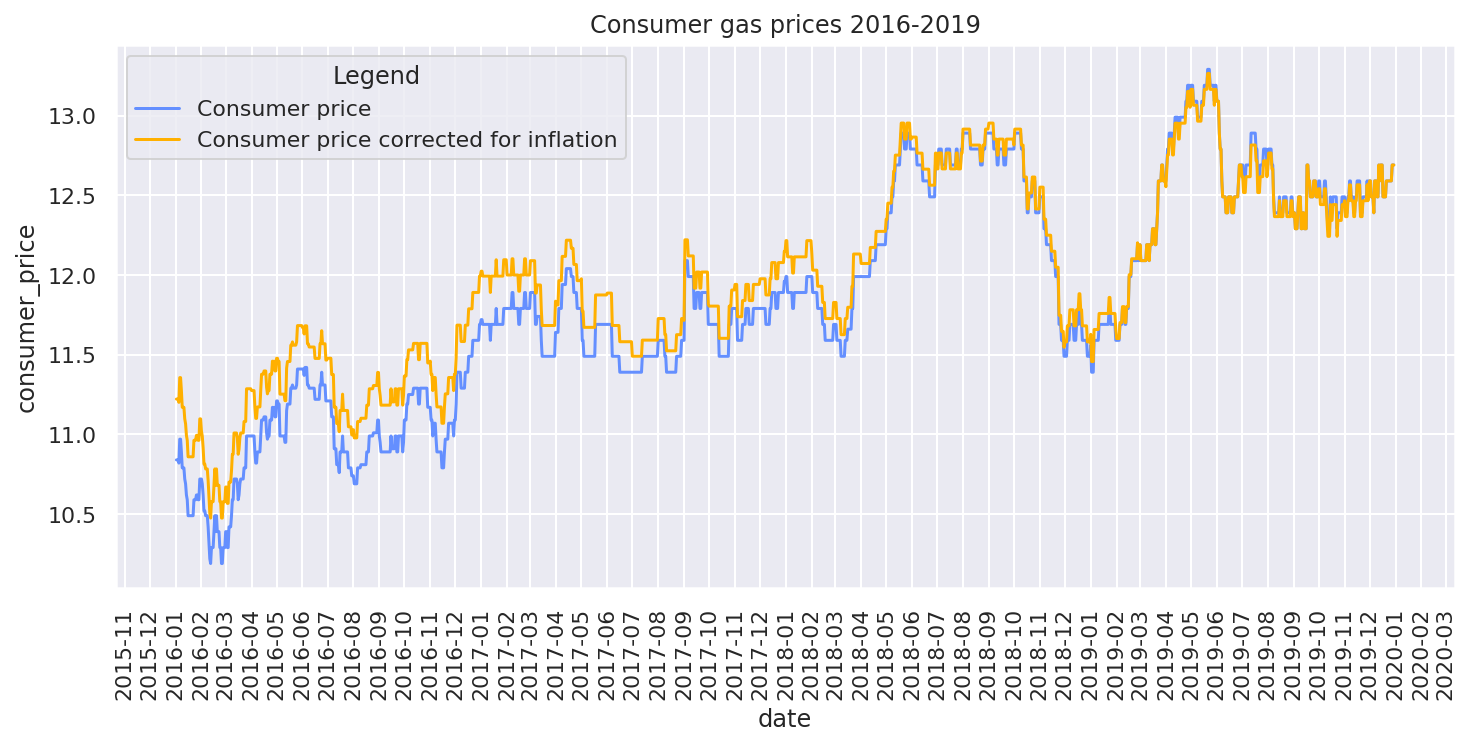

In [12]:
gas_index_path = 'index_gas.csv'
colnames = ['date', 'index']
df_gas_index = pd.read_csv(gas_index_path, names=colnames)
df_gas_index['date'] = [datetime.strptime(date, '%YM%m') for date in df_gas_index['date']]
df_gas_index.head()

gas_path = 'gas_prices.csv'
colnames = ['date', 'consumer_price', 'product_price', 'co2_fee', 'energy_fee', 'VAT']
df_gas = pd.read_csv(gas_path, names=colnames, header=0)
df_gas['consumer_price_corrected'] = np.nan
df_gas['date'] = pd.to_datetime(df_gas['date'])
df_gas = df_gas.drop(['VAT', 'energy_fee', 'product_price', 'co2_fee'], axis=1)

# Add missing dates to dataframe
df_gas = df_gas.drop_duplicates(subset=['date'])
df_gas = df_gas.set_index('date').resample('1D').ffill()
df_gas = df_gas.reset_index(level=0)

index_dict = dict(zip([str(date.year) + str(date.month) for date in df_gas_index['date']], df_gas_index['index']))

for index, row in df_gas.iterrows():
    try:
        index_val = row['consumer_price'] *
                    df_gas_index.loc[df_gas_index['date'] == datetime.strptime('01-12-2019', '%d-%m-%Y')]['index'] /
                    index_dict[str(row['date'].year) + str(row['date'].month)]
        df_gas.at[index, 'consumer_price_corrected'] = index_val
    except KeyError as e:
        continue

START_DATE = datetime.strptime('01-01-2016', '%d-%m-%Y')
END_DATE = datetime.strptime('31-12-2019', '%d-%m-%Y')
DATA_ERRORS_1 = pd.date_range(datetime.strptime('11-09-2017', '%d-%m-%Y'), datetime.strptime('15-11-2017', '%d-%m-%Y'))
DATA_ERRORS_2 = pd.date_range(datetime.strptime('20-05-2019', '%d-%m-%Y'), datetime.strptime('30-08-2019', '%d-%m-%Y'))
DATA_ERRORS_3 = pd.date_range(datetime.strptime('26-11-2018', '%d-%m-%Y'), datetime.strptime('02-12-2018', '%d-%m-%Y'))

normal = (df_gas['date'] > START_DATE) & (df_gas['date'] < END_DATE)
plt.figure()
sns.lineplot(data=df_gas.loc[normal], x="date", y="consumer_price", color='#648fff')
g = sns.lineplot(data=df_gas.loc[normal], x="date", y="consumer_price_corrected", color='#ffb000')
g.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
plt.title("Consumer gas prices 2016-2019")
plt.legend(title='Legend', loc='upper left', labels=['Consumer price', 'Consumer price corrected for inflation'])
plt.xticks(rotation=90);

#### Removing noise from the data

Now, let's make sure that the data looks correct. We will plot the prices as a line chart, since the daily prices are closely correlated, meaning the value is not fluctuating too much. The inflation corrected price is higher and diverging more from the original price in 2016 than in 2019, indicating that the calculations should be correct. As a result of global warming and other factors, we can definitely see that the prices are increasing as time progresses, even when adjusted for inflation.

Data errors do occur. To illustrate the difference between the raw data and what the weekdays look like, we will clean up the data. The traffic counter had 3 data error periods, which we can remove. The same applies to weekends, public holidays and other outliers; these are removed as well. 

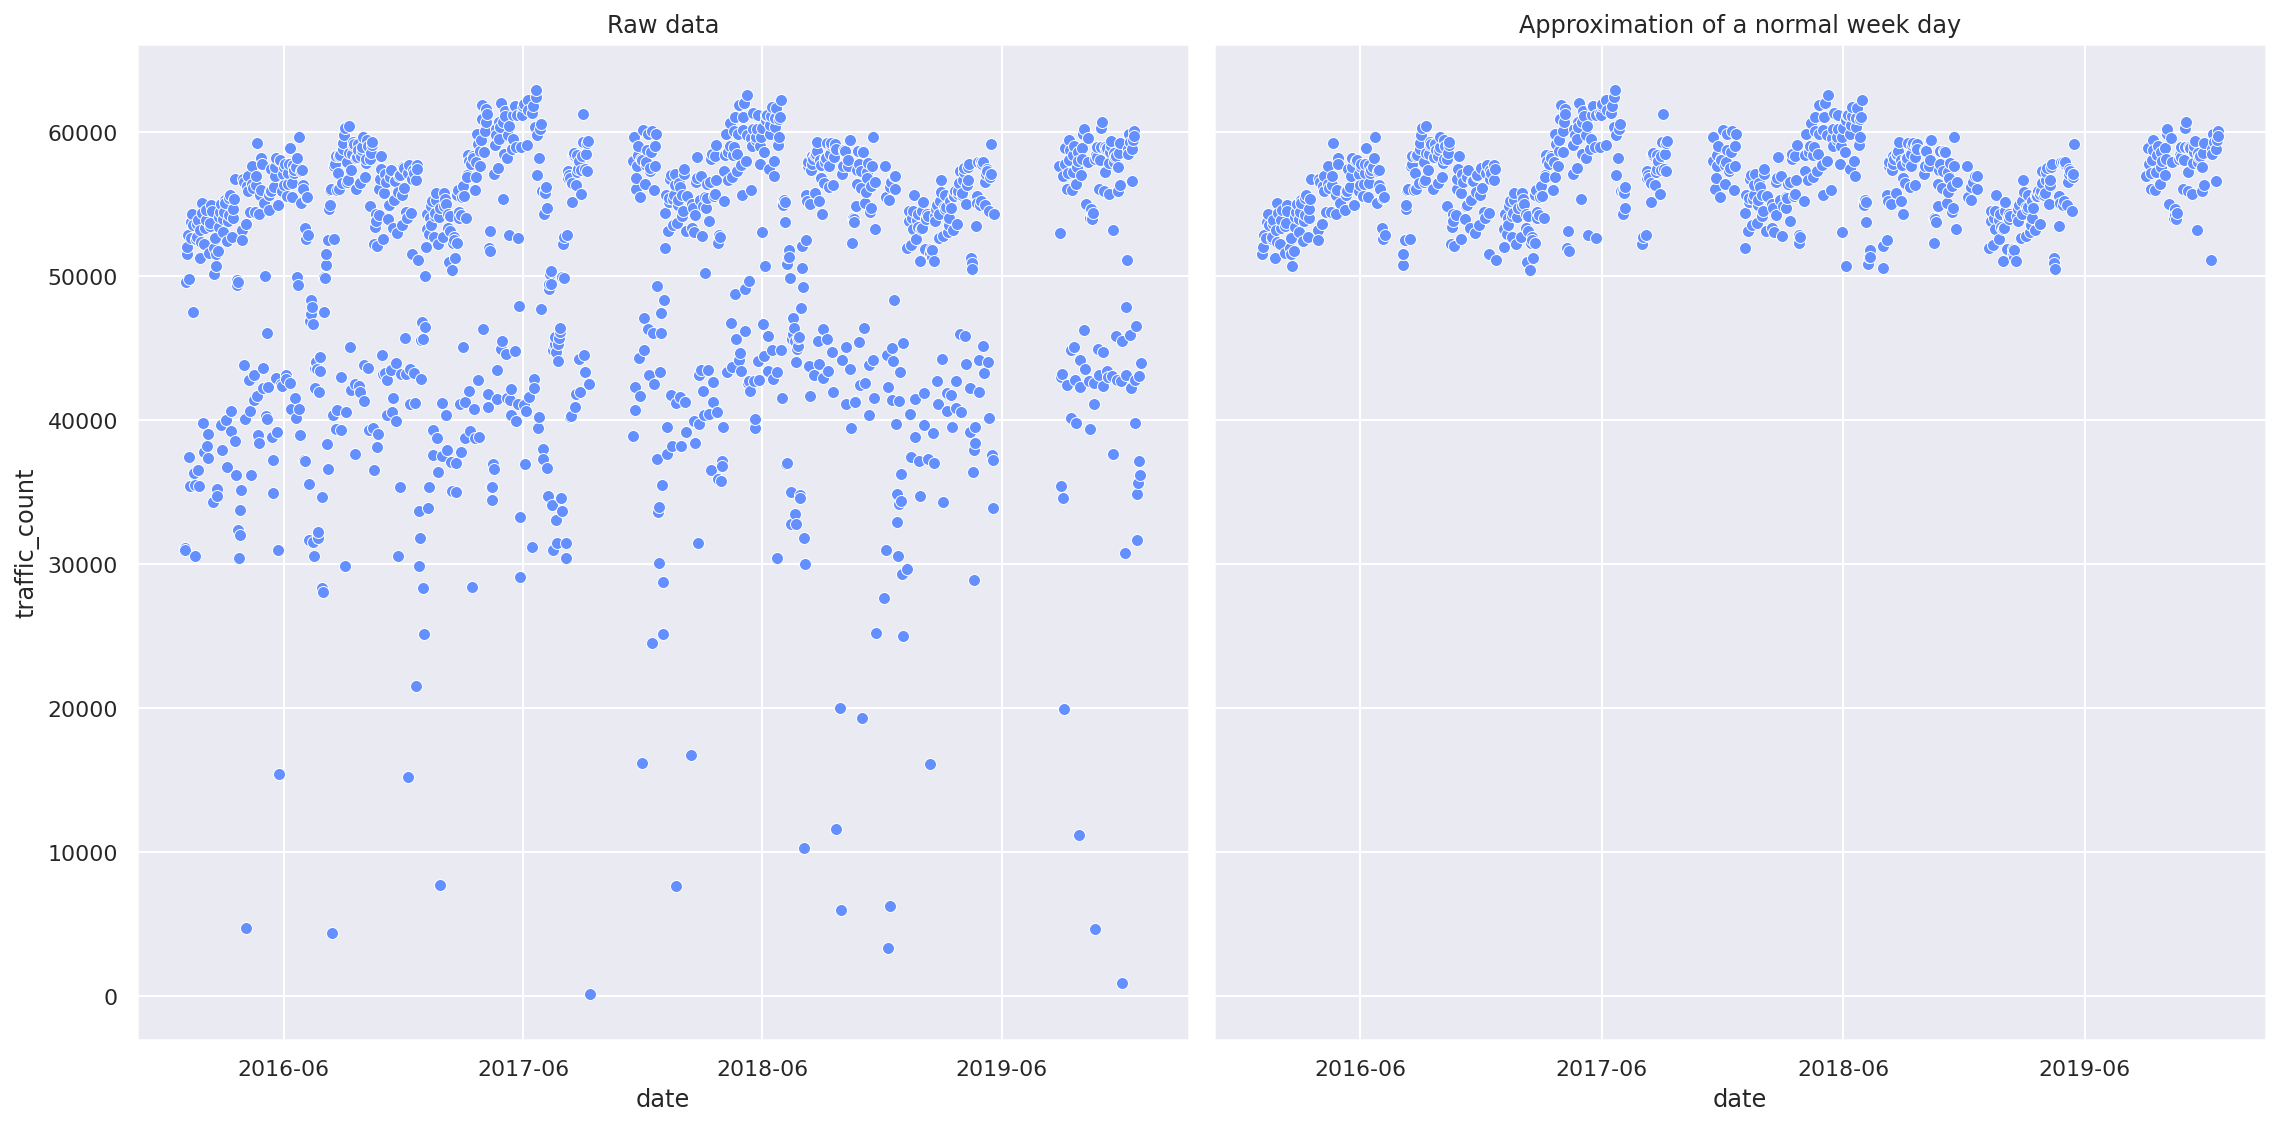

In [73]:
df_traffic_sum = df_traffic.pivot_table(index=['date', 'street', 'is_public_holiday',
                                               'is_weekend'], values='traffic_count', aggfunc='sum').reset_index()
df_traffic_sum = df_traffic_sum.dropna()
df_traffic_sum = df_traffic_sum[
    (df_traffic_sum['traffic_count'] != 0) & (df_traffic_sum['street'] == 'Mellem TSA 1 og 2')]
df_traffic_sum = df_traffic_sum.groupby([df_traffic_sum['date'].dt.date], as_index=False).agg({'date': 'first',
                                                                                               'traffic_count': 'sum',
                                                                                               'is_public_holiday': 'first',
                                                                                               'is_weekend': 'first'})
df_traffic_sum['date'] = df_traffic_sum['date'].dt.normalize()

normal = (df_traffic_sum['date'] > START_DATE) & (df_traffic_sum['date'] < END_DATE)

df_traffic_sum_pretty = df_traffic_sum[df_traffic_sum.date.dt.weekday < 5]  # Remove weekends
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(PUBLIC_HOLIDAYS)]  # Remove public holidays
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_1)]  # Remove data errors
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_2)]  # Remove data errors
df_traffic_sum_pretty = df_traffic_sum_pretty[~df_traffic_sum['date'].isin(DATA_ERRORS_3)]  # Remove data errors
q_low = df_traffic_sum_pretty["traffic_count"].quantile(0.2)
df_traffic_sum_pretty = df_traffic_sum_pretty[(df_traffic_sum["traffic_count"] > q_low)]  # Remove lower quantile

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey='all')

g1 = sns.scatterplot(data=df_traffic_sum.loc[normal], x="date", y="traffic_count", color='#648fff', ax=axes[0])
g1.set_title("Raw data")
g2 = sns.scatterplot(data=df_traffic_sum_pretty.loc[normal], x="date", y="traffic_count", color='#648fff', ax=axes[1])
g2.set_title("Approximation of a normal week day")

g1.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))
g2.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))

plt.tight_layout()

When removing all the noise from the data, we can see that the traffic count is typically at its highest between May and July. This could be because people are prone to visit Copenhagen in their free time, more tourists are visiting and in general, people are more out and about when the weather is good. The machine learning algorithm should, as a result, take the month into consideration when making predictions.

# Data Analysis
Something about our general approach/method/strategy whatevs...

## Traffic during COVID (2020) (Thomas Witting)
This section will give an introductory and exploratory analysis of patterns between traffic counts in select locations in the Copenhagen area and COVID cases and hospitalizations in the same time period.

#### Data Preparation
Read and prepare dataframe containing related traffic and COVID features - the traffic data has been described earlier and is gathered from the iMastra framework, while the COVID data has been acquired from [Statens Serum Institut](https://covid19.ssi.dk/overvagningsdata).

In [18]:

# Merge traffic data with COVID data
df_tc = pd.merge(df_covid, df_traffic_2020, on='date', how='right').fillna(0)

# Unique streets
streets = df_tc['street'].unique()

#### Data distributions

In order to know the general distributions of the data, we have utilized a Bokeh visualization with different tabs for the different features.

In [19]:
def bokeh_deepnote_show(plot):
    tmp_output_filename = tempfile.NamedTemporaryFile(suffix='.html').name
    output_file(tmp_output_filename)
    save(plot)

    f = open(tmp_output_filename, "r")
    display(HTML(f.read()))

#Convert your DataFrame to Bokeh ColumnDataSource
src = ColumnDataSource(df_tc.groupby(df_tc['street']).agg({'cases' : 'sum', 'hospitalizations': 'sum', 'traffic_count': 'sum',
       'traffic_count_ref': 'sum'}))

#Create an empty figure
p_traffic = figure(plot_width = 350, plot_height = 500, title = 'Traffic count 2022',
           x_axis_label = None, y_axis_label = 'Count', x_range = FactorRange(factors=df_tc['street'].unique()), background_fill_color="#fafafa") 

#Define the columns to use for each bar
bar_cols = ['traffic_count']
legends = bar_cols

#Add bars by using p.var
bar = {}
for i, col in enumerate(bar_cols):
    bar[col] = p_traffic.vbar(x='street',  top=col, source=src, width=0.5, alpha=0.5, muted = False, fill_color="green", line_color="white")
    
p_traffic.xaxis.major_label_orientation = "vertical"

TOOLTIPS = [
    ("Total cars counted", "@traffic_count")
]

p_traffic.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[bar[bar_cols[0]]]))

# Function to create histogram plot
def make_plot(title, hist, edges, p=None):
    if p is None:
        p = figure(title=title, tools='', plot_width = 350, plot_height = 500, background_fill_color="#fafafa")

    
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="green", line_color="white", alpha=0.5)
    
    p.xaxis.axis_label = ''
    p.yaxis.axis_label = 'Count'
    p.grid.grid_line_color="white"
    return p

# Create histograms for traffic counts for each street
hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[0]]['traffic_count'], density=False, bins=25)
phist1 = make_plot(streets[0], hist, edges)

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[1]]['traffic_count'], density=False, bins=25)
phist2 = make_plot(streets[1], hist, edges)

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[2]]['traffic_count'], density=False, bins=25)
phist3 = make_plot(streets[2], hist, edges)

# Create histogram for cases and hospitalizations
hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[0]]['cases'], density=False, bins=25)
phistcases = make_plot('Cases distribution', hist, edges)

hist, edges = np.histogram(df_tc.loc[df_tc['street'] == streets[1]]['hospitalizations'], density=False, bins=25)
phisthospitalizations = make_plot('Hospitalizations distribution', hist, edges)

# Format y-axes to not use scientific numbering
phist1.yaxis.formatter.use_scientific = False
phist2.yaxis.formatter.use_scientific = False
phist3.yaxis.formatter.use_scientific = False
p_traffic.yaxis.formatter.use_scientific = False
phistcases.yaxis.formatter.use_scientific = False
phisthospitalizations.yaxis.formatter.use_scientific = False

# Layout the plots into tabs and grids
gp1 = gridplot([phist1, phist2, phist3], ncols=3, toolbar_location=None)
gp2 = gridplot([phistcases, phisthospitalizations], ncols=2, toolbar_location=None)
l1 = layout([[p_traffic]])
l2 = layout([[gp1]])
l3 = layout([[gp2]])

tab1 = Panel(child=l1,title='Traffic count')
tab2 = Panel(child=l2,title='Histogram Traffic')
tab3 = Panel(child=l3,title='Histogram COVID')
tabs = Tabs(tabs=[tab1, tab2, tab3])
curdoc().add_root(tabs)
bokeh_deepnote_show(tabs)

<!DOCTYPE html>
 
 
 
 
 
 Bokeh Plot

From the total traffic counts, it is clearly seen how 'Mellem TSA 1 og 2'/Hillerødmotorvejen sees a much higher traffic count than the other two streets. However, the three histograms show similar bimodal distributions with two peaks, likely indicating that the two rush hours of the day - morning and evening - occurs across all three streets. Looking at the histograms for COVID, both cases and hospitalizations display power-law distribution behaviour. Due to different testing capacities across 2020, we will focus on hospitalizations as the primary COVID measure in the following plots as it is a more stable metric not as dependent on the number of tests performed.

**Timeline overview plot**

Investigating a timeline plot for each street during the year of 2020 and comparing it with traffic counts from a reference year for the same street, some patterns are already visible. For all three streets, they follow a near-identical pattern with the reference year during January and February, while they all deviate significantly at the start of March – coinciding with the onset of COVID in Denmark. During the following months, the traffic seems to climb back a bit and remain at a more steady pattern. Similarly, a second decline in traffic is seen during the summer months. As this is both noticeable in the reference data and the data for 2020, it is likely due to reduced traffic during the summer vacation.

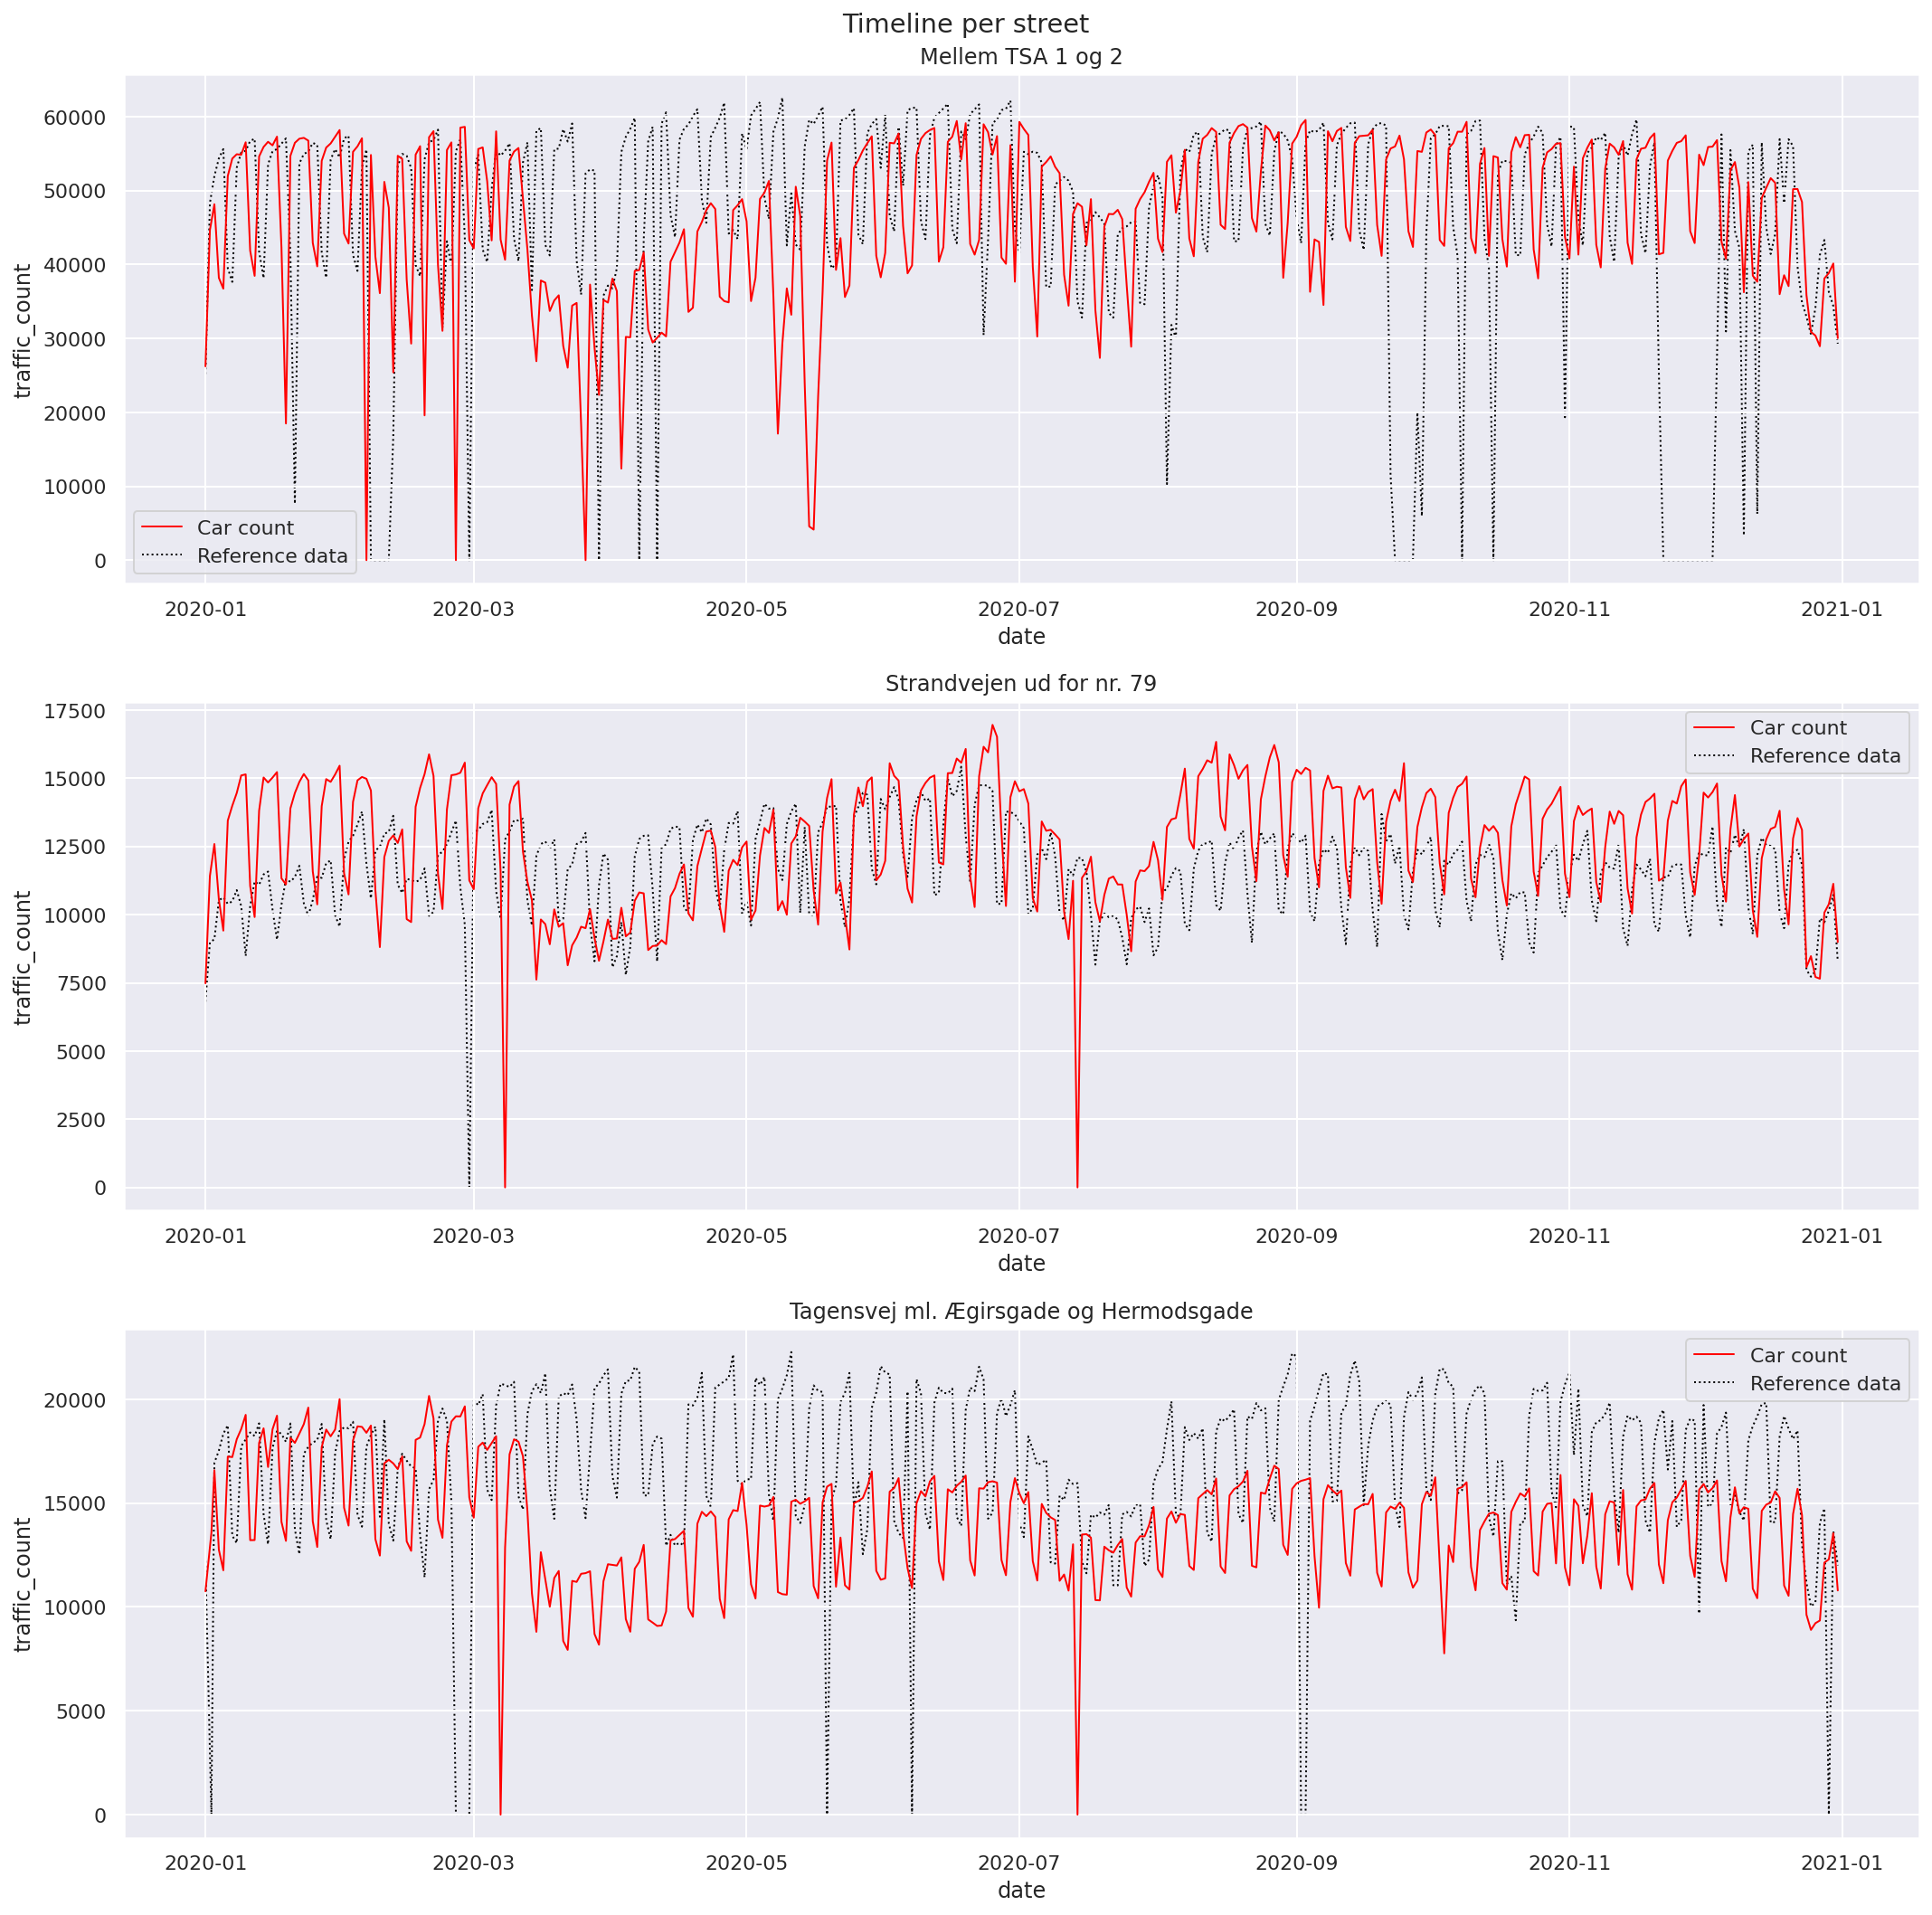

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
        
numeric_columns = df_tc.select_dtypes(include=np.number).columns.tolist()

for i, (street, column) in enumerate(zip(streets, numeric_columns)):
    df_tc_street = df_tc.loc[df_tc['street'] == street]
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count'], color='red', linewidth=1, ax=axes[i], label='Car count', zorder=1)
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count_ref'], color='black', linestyle='dotted', linewidth=1, ax=axes[i], label='Reference data', zorder=0)
    #for date, label in zip(COVID_DATES, ['First case', 'First lockdown', 'First reopening']):
    #        sns.scatterplot(x=df_tc_street['date'], y=df_tc_street.loc[df_tc_street['date'] == date]['traffic_count'], s=200, ax=axes[i], zorder=2, label=label)
        
    g.set_title(street)

fig.suptitle('Timeline per street')
plt.tight_layout()

**Timeline for traffic and COVID combined**

To further analyse the relation between COVID and traffic counts, the previous plots will be overlayed with COVID-related data. The number of hospitalizations on a given date is shown, as well as important dates marking events during the initial part of the COVID response in 2020.

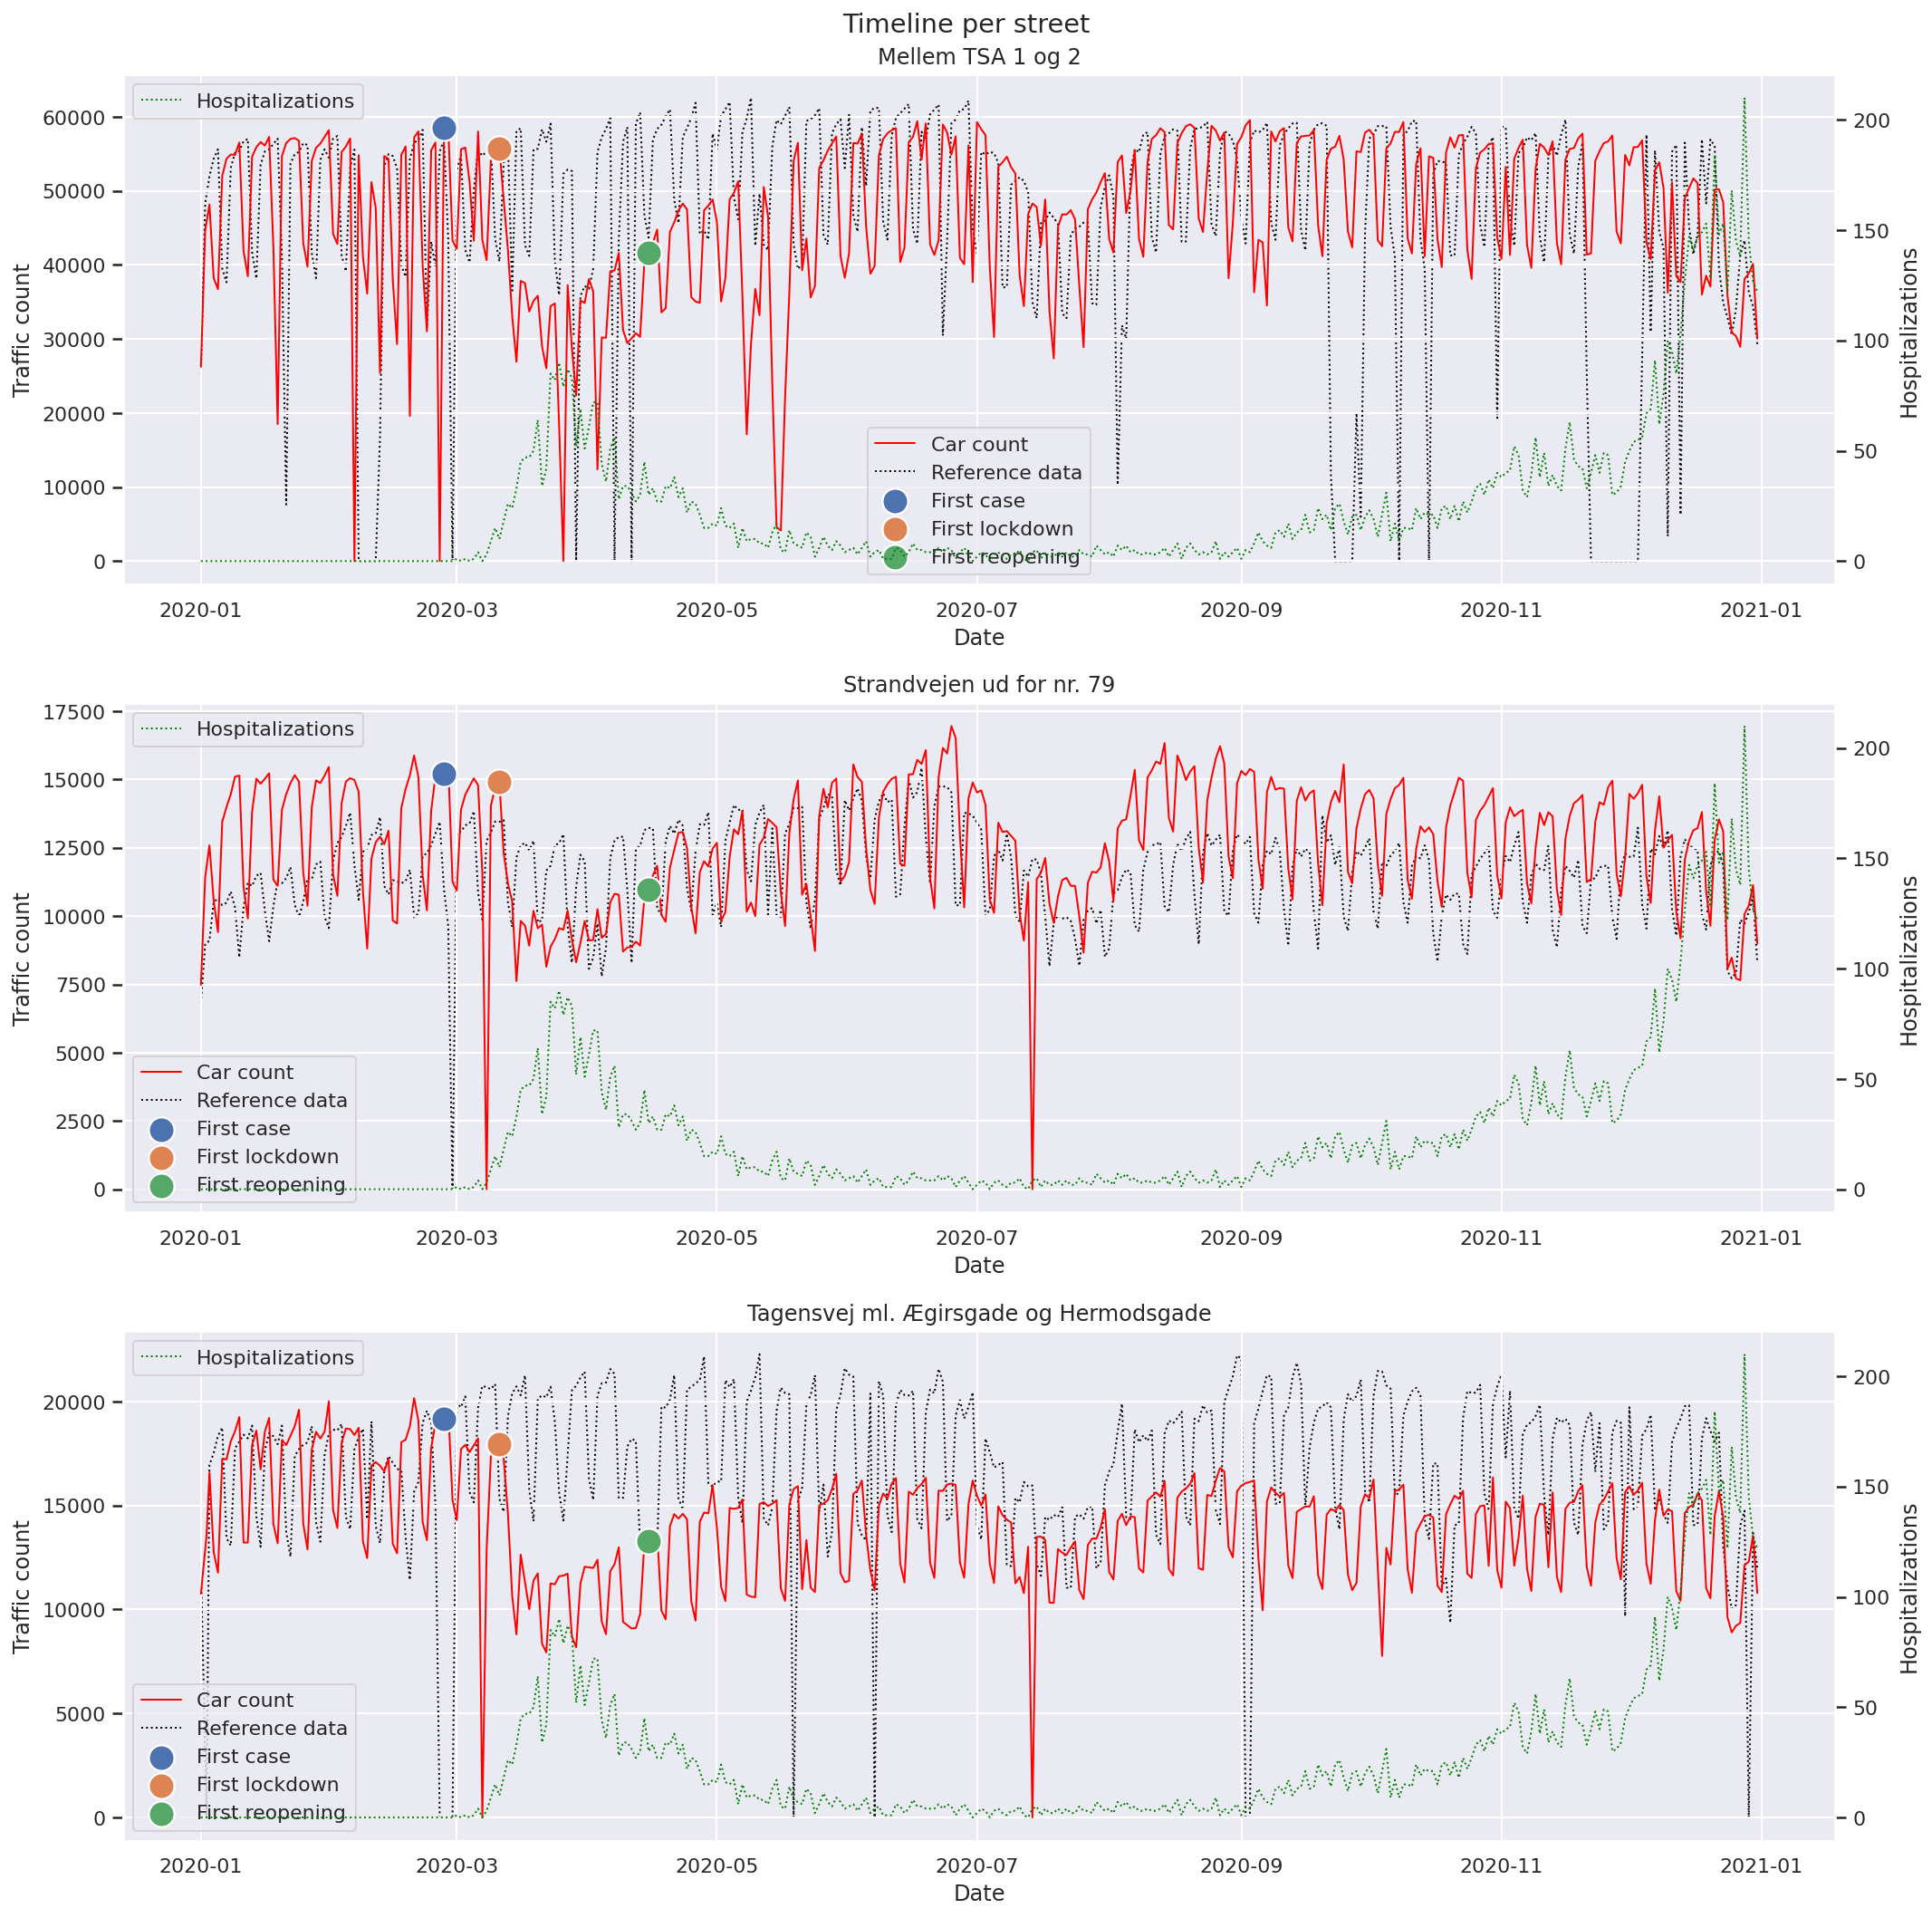

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

for i, street in enumerate(streets):
    df_tc_street = df_tc.loc[df_tc['street'] == street]
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count'], color='red', linewidth=1, ax=axes[i], label='Car count', zorder=1)
    g = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['traffic_count_ref'], color='black', linestyle='dotted', linewidth=1, ax=axes[i], label='Reference data', zorder=0)
    
    ax2 = axes[i].twinx()
    ax2.grid(False)
    g2 = sns.lineplot(x=df_tc_street['date'], y=df_tc_street['hospitalizations'], color='green', linestyle='dotted', linewidth=1, axes=ax2, label='Hospitalizations')
    
    for date, label in zip(COVID_DATES, ['First case', 'First lockdown', 'First reopening']):
            sns.scatterplot(x=df_tc_street['date'], y=df_tc_street.loc[df_tc_street['date'] == date]['traffic_count'], s=200, ax=axes[i], zorder=2, label=label)
    
    g.set_title(street)
    g.set_xlabel('Date')
    g.set_ylabel('Traffic count')
    g2.set_ylabel('Hospitalizations')

fig.suptitle('Timeline per street')
plt.tight_layout()

With overlaid COVID data, the apparent relation between important events and hospitalizations and car traffic is verified. From the first verified case in Denmark until the first lockdown, a slight decrease in traffic is observed – society is slowly acting on restrictions being announced in other countries as well as the unknown future the COVID pandemic might bring. When the first lockdown happened, a very drastic drop in traffic occurs across all three streets. As hospitalizations a

#### Hourly plots during COVID vs before
An interesting aspect to look at would be the hourly changes in traffic during the initial part of COVID lockdowns where hospitalizations were high, and knowledge about consequences low - thus resulting in a harsh lockdown. As just shown, a clear difference in traffic counts between 2020 and the reference data exists during this period when viewed on a daily basis. But is there a change in patterns if viewed on an hourly basis?

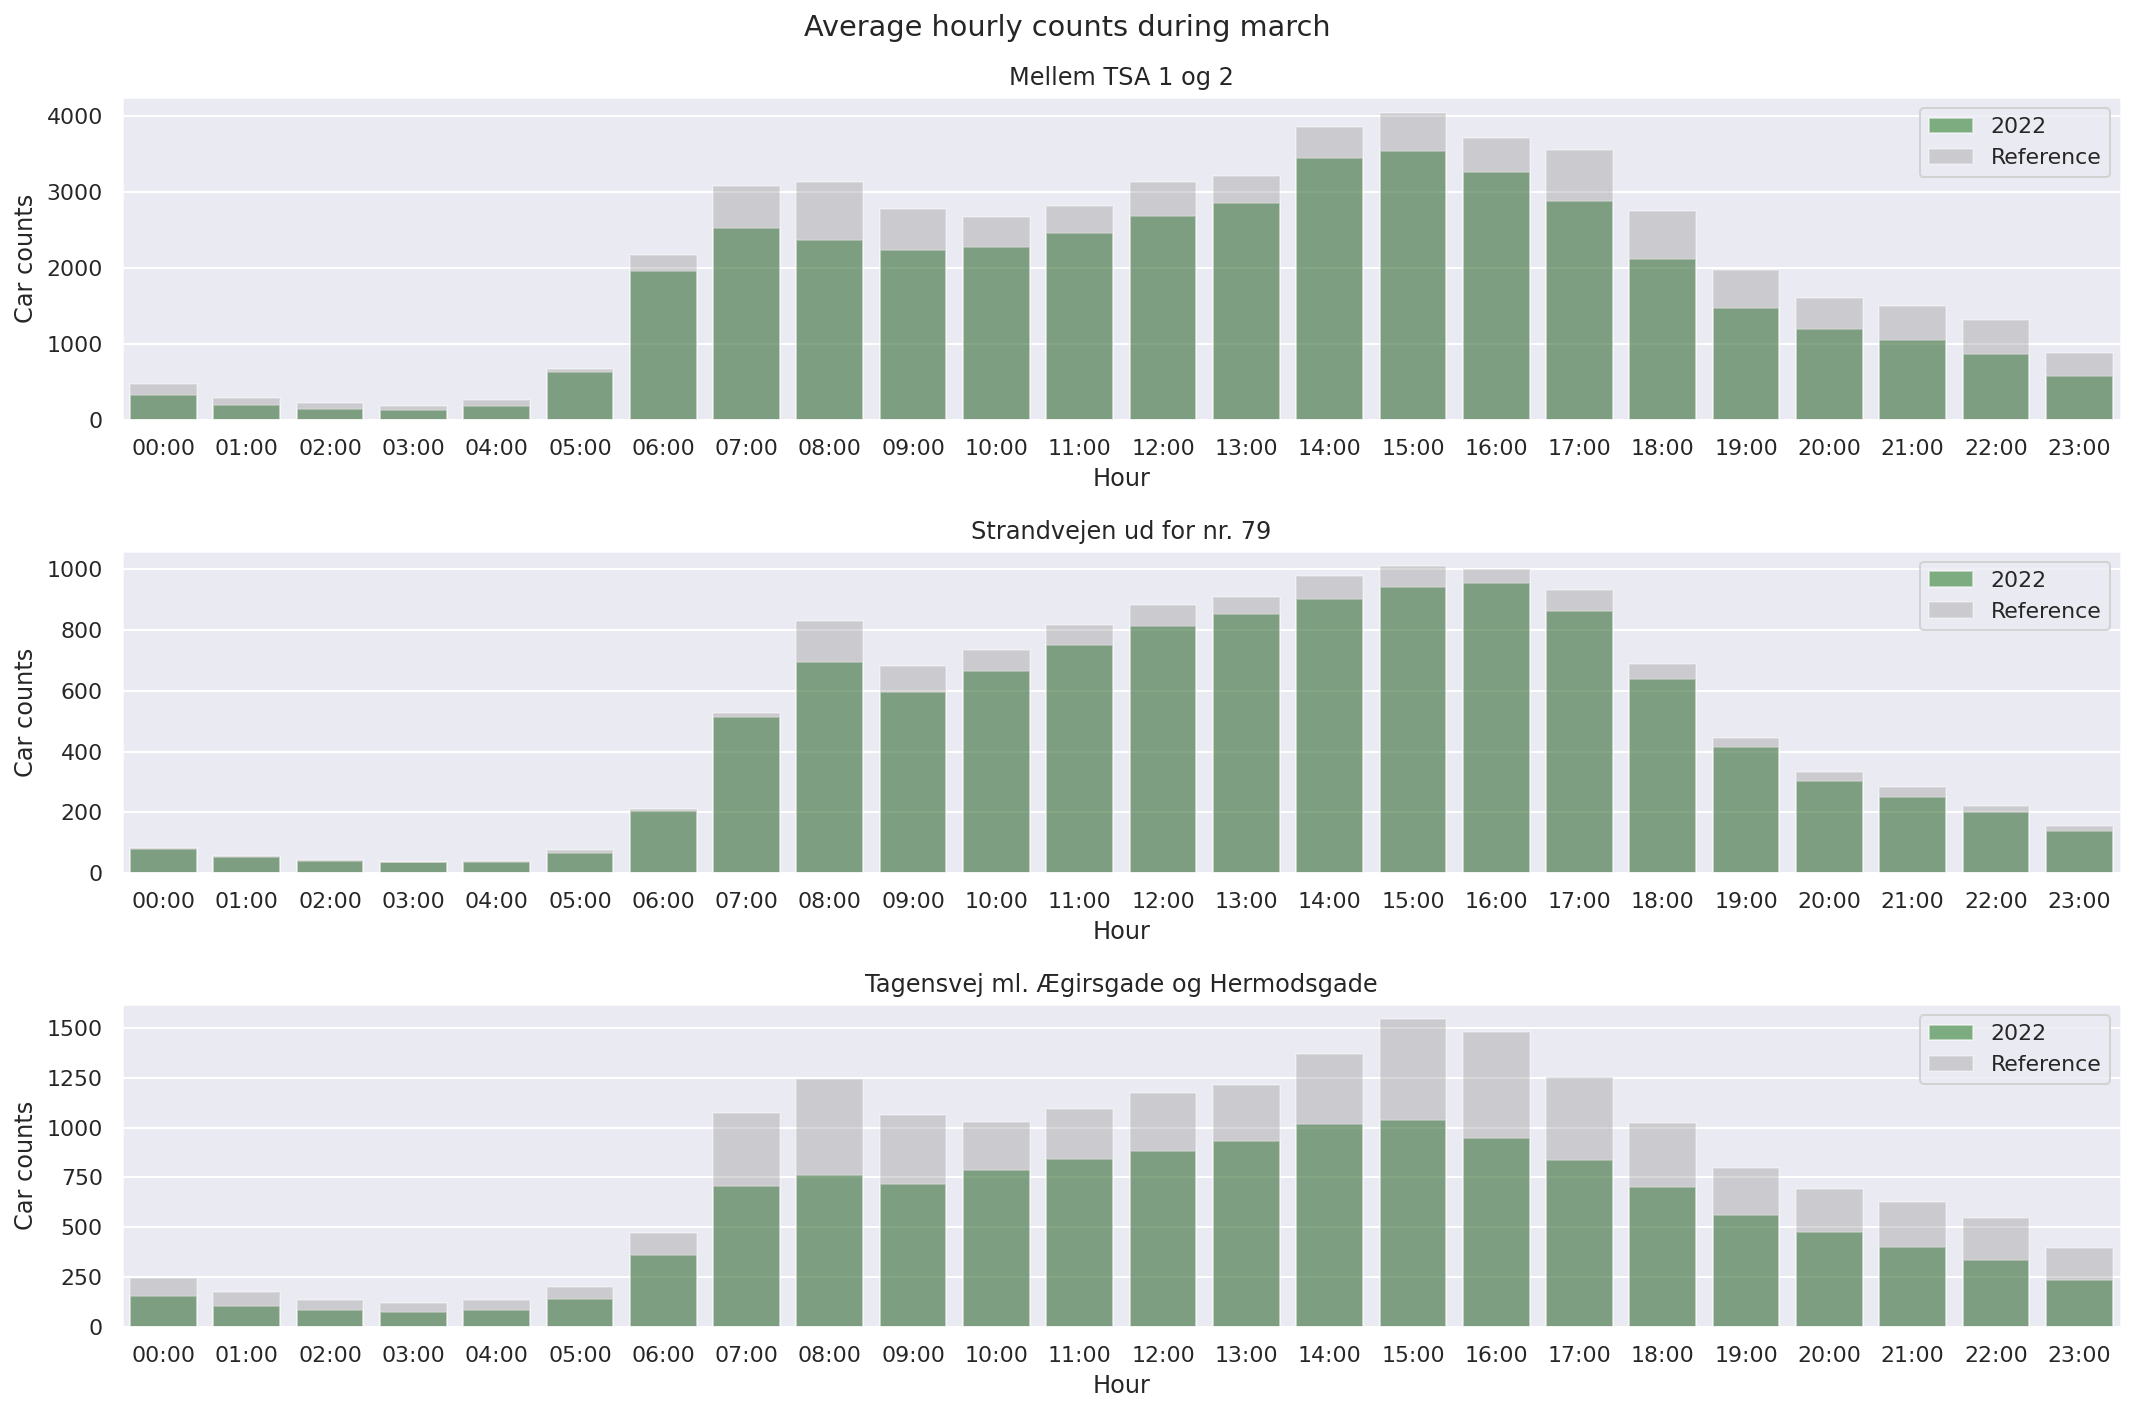

In [22]:
# Plots of hourly counts averaged over the month of march
df_march = df_traffic[df_traffic['date'].map(lambda x : (x.year == 2020) & (x.month == 3))]
df_march['hour'] = df_march['date'].dt.strftime('%H:%M')
df_hour = df_march.groupby([df_march['date'].dt.hour, df_march['street']], as_index=False).agg({'hour': 'first', 'traffic_count': 'mean'})

df_march_ref = df_ref[df_ref['date'].map(lambda x : x.month == 3)]
df_march_ref['hour'] = df_march_ref['date'].dt.strftime('%H:%M')
df_hour_ref = df_march_ref.groupby([df_march_ref['date'].dt.hour, df_march_ref['street']], as_index=False).agg({'hour': 'first', 'traffic_count': 'mean'})

fig, axes = plt.subplots(3, 1, figsize=(15,10))

for i, street in enumerate(streets):
    df_hour_street = df_hour.loc[df_hour['street'] == street]
    df_hour_street_ref = df_hour_ref.loc[df_hour_ref['street'] == street]
    g = sns.barplot(data=df_hour_street, x='hour', y='traffic_count', color='green', alpha=0.5, linewidth=1, ax=axes[i], label='2022')
    g = sns.barplot(data=df_hour_street_ref, x='hour', y='traffic_count', color='grey', alpha=0.3, linewidth=1, ax=axes[i], label='Reference')
    g.set_title(street) 
    g.set_xlabel('Hour')
    g.set_ylabel('Car counts')
    g.legend()
    g.ticklabel_format(style='plain', axis='y')

fig.suptitle('Average hourly counts during march')
plt.tight_layout()

It is clear how for each of the three roads, the traffic counts have decreased during the daytime - especially at Tagensvej a significant difference is observed. Not only is the decrease large, but the rush hour peak in the morning is not distinct from the following hours and just follows the general increase in traffic until the peak at 15:00. Strandvejen experienced the least difference in traffic of the three – with a slight decrease during daytime and no significant changes from 18:00 until 07:00 in the morning. The general small decrease seen at Strandvejen may indicate that little commuter traffic occurs, as this type of traffic were reduced the most during COVID due to work-from-home policies.

## Predicting traffic with gas prices

The war in Ukraine increased the global gas prices by a huge factor, which got us wondering if the gas prices might have had an impact on traffic in Copenhagen. We just read in the previous section that Covid-19 had a huge impact on traffic, and we therefore chose to limit our data from 1/1-2016 to 31/12-2019. Since the traffic data is full of data errors, we had to limit our focus to merely one traffic counter. The traffic counter is placed on "Hillerødmotorvejen" and DRD calls it "Mellem TSA 1 og 2", this can be seen on the map with all the traffic counters. One might argue that this will not give the full picture of the traffic. However, this is a major access point for Copenhagen, topping at around 60,000 cars on a week day. 

We imagine there will be a negative correlation between gas prices and traffic count, but the rising number of cars in and around Copenhagen is steadily increasing. 

### Set up

We combine and optimize our traffic data with the corrected gas prices as follows:
- Remove the data errors from the traffic data
- Remove the lower quantile from the traffic data
- Merge the traffic data with gas prices
- Encode the months as categories, since we saw there is more traffic in some months, discussed in basic stats.

In [23]:
df_traffic_sum_no_outliers = df_traffic_sum
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_1)] # Remove data errors
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors
q_low = df_traffic_sum_no_outliers["traffic_count"].quantile(0.2) # Remove lower quantile
df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[(df_traffic_sum_no_outliers["traffic_count"] > q_low)]

df_traffic_gas = pd.merge(df_traffic_sum_no_outliers.loc[normal], df_gas, on="date")
df_traffic_gas = df_traffic_gas.loc[:, ["date", "traffic_count", "is_weekend", "is_public_holiday","consumer_price_corrected"]]
df_traffic_gas['month'] = df_traffic_gas['date'].dt.strftime('%m')
one_hot = pd.get_dummies(df_traffic_gas['month'])
# Join the encoded dataframes
df_traffic_gas = df_traffic_gas.join(one_hot)
# Drop columns as it is now encoded
df_traffic_gas.index = df_traffic_gas['date']
df_traffic_gas = df_traffic_gas.drop('date',axis = 1)
df_traffic_gas = df_traffic_gas.drop('month',axis = 1)
df_traffic_gas.describe()

<ipython-input-23-ff5786ce1358>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_2)] # Remove data errors
<ipython-input-23-ff5786ce1358>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_traffic_sum_no_outliers = df_traffic_sum_no_outliers[~df_traffic_sum['date'].isin(DATA_ERRORS_3)] # Remove data errors


traffic_count 
 consumer_price_corrected 
 01 
 02 
 03 
 04 
 05 
 06 
 07 
 08 
 09 
 10 
 11 
 12 
 
 
 
 
 count 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 1005.000000 
 
 
 mean 
 53161.347264 
 11.970385 
 0.082587 
 0.079602 
 0.094527 
 0.098507 
 0.092537 
 0.078607 
 0.062687 
 0.078607 
 0.082587 
 0.079602 
 0.086567 
 0.083582 
 
 
 std 
 6062.497687 
 0.589052 
 0.275394 
 0.270811 
 0.292707 
 0.298148 
 0.289927 
 0.269258 
 0.242519 
 0.269258 
 0.275394 
 0.270811 
 0.281340 
 0.276898 
 
 
 min 
 40636.000000 
 10.475035 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 25% 
 49082.000000 
 11.571125 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 50% 
 55168.000000 
 11.964408 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 75% 
 57788.000000 
 12.465771 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 max 
 62950.000000 
 13.164413 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000

When looking at the basic stats, we see that we have 1005 dates to train our model, it is not a lot, but should be sufficient. Since we are building a linear model, we should have enough to gain insight. We would like to have a model that has a mean absolute error on a maximum of half the standard deviation. To be certain that it is not purely guesses.

We set our target value for the models to predict ```traffic_count```, and the rest of the dataframe are features. Afterwards, a split is made to separate test/train data and lastly prepare a result dataframe, in order to compare our results.

To further enhance the model, we could implement K-fold cross validation on our data.

In [60]:
# X is predictors, y is target
target = 'traffic_count'
features = [col for col in df_traffic_gas.columns if col != target]
X = df_traffic_gas[features]
y = df_traffic_gas[target]

# Split according to a 70%/30% train/test policy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results_df = pd.DataFrame({'actuals': y_test, 'is_weekend': X_test['is_weekend'], 'is_public_holiday': X_test['is_public_holiday']})

### Baseline model

Let us set up a primitive model, it fits to mean of all y values. This model is not very good, how ever gives a good indication of how much better our model is compared to a naive guess.

The model is constructed with a fit and predict function:

In [59]:
class Baseline:
    def __init__(self):
        self.mean = None

    def fit(self, y):
        # Fits to the mean of all y-values
        self.mean = np.mean(y)
    
    def predict(self, X):
        # Check if X is a list of features, or just one feature
        if isinstance(X, list):
            return [self.mean] * len(X[0])
        else:
            return [self.mean] * len(X)

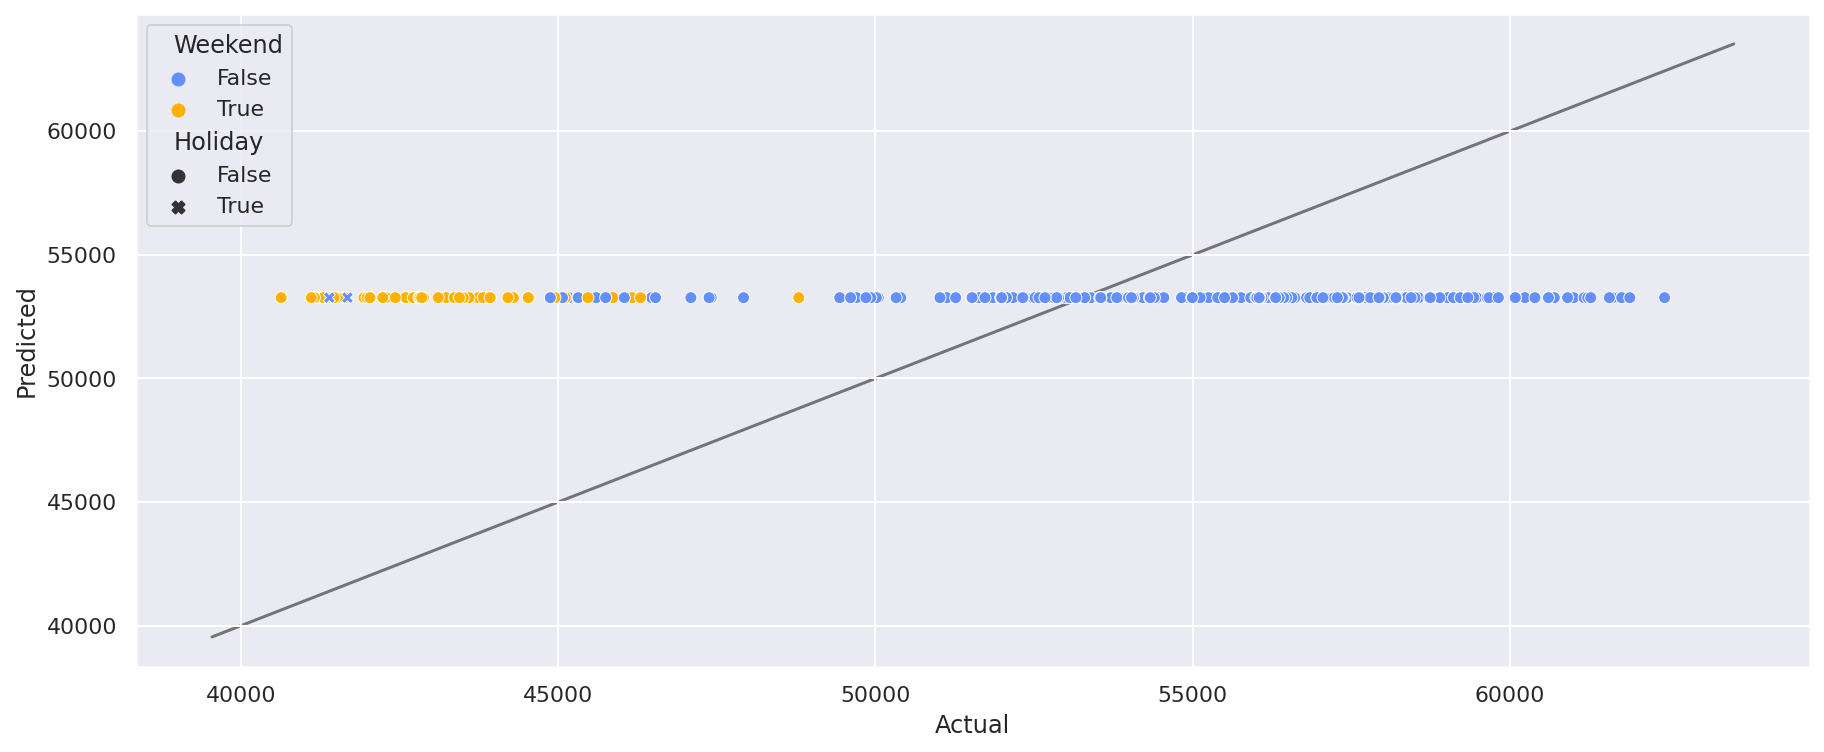

In [68]:
baseline = Baseline()
baseline.fit(y_train) # Train the model

baseline_y_pred = baseline.predict(X_test) # Predict values
results_df["baseline"] = baseline_y_pred # Store predicted values

df_metrics = pd.DataFrame({
    "metric" : [],"value"  : []
})
df_metrics.loc[len(df_metrics.index)] = ["Mean squared error", "{:.2f}".format(metrics.mean_squared_error(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Coefficient of determination", "{:.2f}".format(metrics.r2_score(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Mean Absolute Error", "{:.2f}".format(metrics.mean_absolute_error(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Root Mean Squared Error", "{:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, baseline_y_pred)))]

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': baseline_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday', palette=["#648fff", "#ffb000"]);

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

Of to a somewhat of a start, the x-values have no impact in this model, forcing it to guess the mean value. To have perfect guesses, we would like the point to align with the black line. This graph did also show that weekends and public holidays have fever people on the road, since only a few people are working. Let us dive into some more details about this model with some metrics. 

In [35]:
df_metrics.head(5)

metric 
 value 
 
 
 
 
 0 
 Mean squared error 
 36544586.29 
 
 
 1 
 Coefficient of determination 
 -0.00 
 
 
 2 
 Mean Absolute Error 
 4958.79 
 
 
 3 
 Root Mean Squared Error 
 6045.21

The first thing to notice is the coefficient of determination, as stated before we would like the points to be on the line. If this were the case, this coefficient should have been close to 1, but in this case it is 0 indicating no correlation. The mean absolute error measures the average of the absolute distance between the predicted value $\hat{y}_i$ and the true value $y_i$. We would like this value to be below half of the standard deviation of the traffic count, but that is not the case. Let us try to predict using linear regression. 

### Linear Regression model

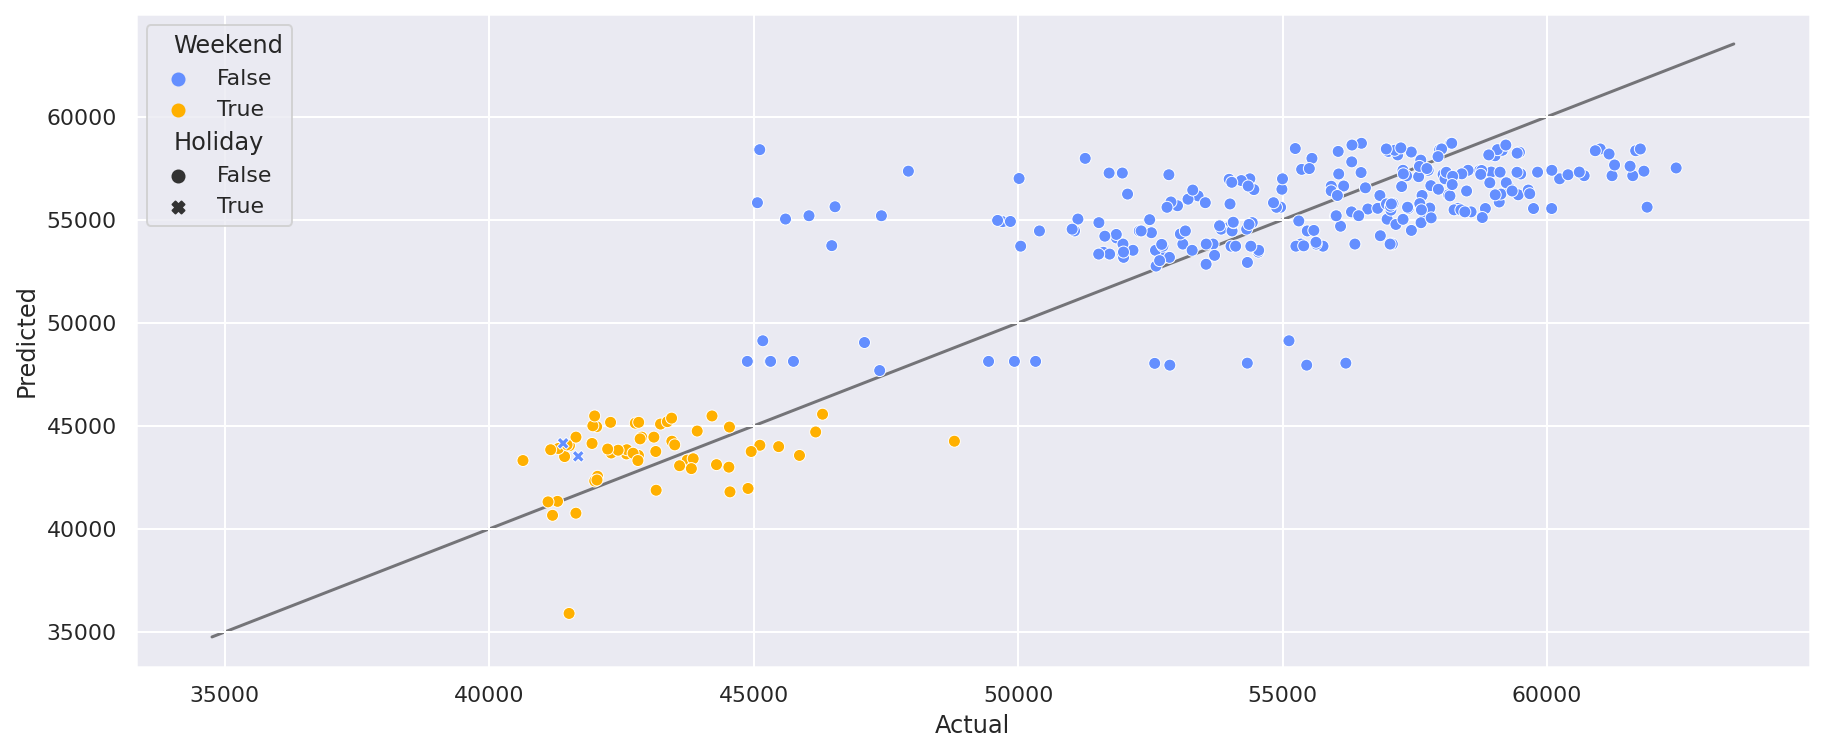

In [69]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train) # Train the model

baseline_y_pred = lin_reg.predict(X_test) # Predict values
results_df["linear_regression"] = baseline_y_pred

df_metrics = pd.DataFrame({
    "metric" : [],"value" : []
})
df_metrics.loc[len(df_metrics.index)] = ["Coefficients", lin_reg.coef_]
df_metrics.loc[len(df_metrics.index)] = ["Intercept", "{:.2f}".format(lin_reg.intercept_)]
df_metrics.loc[len(df_metrics.index)] = ["Mean squared error", "{:.2f}".format(metrics.mean_squared_error(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Coefficient of determination", "{:.2f}".format(metrics.r2_score(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Mean Absolute Error", "{:.2f}".format(metrics.mean_absolute_error(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Root Mean Squared Error", "{:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, baseline_y_pred)))]

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': baseline_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday', palette=["#648fff", "#ffb000"]);

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

The linear regression model looks much more promising than the baseline model. The x-values now have an impact on the y-values. The points is aligning a lot with the black line, implying a good model. This graph also showed that weekends and public holidays have fever people on the road, only now the predictions are close to the actual values. Let explore some more details about this model with some metrics. 

In [43]:
df_metrics.head(6)

metric 
 value 
 
 
 
 
 0 
 Coefficients 
 [-13144.971014583965, -13030.509308349252, 851... 
 
 
 1 
 Intercept 
 45334.36 
 
 
 2 
 Mean squared error 
 8297299.22 
 
 
 3 
 Coefficient of determination 
 0.77 
 
 
 4 
 Mean Absolute Error 
 2176.50 
 
 
 5 
 Root Mean Squared Error 
 2880.50

The first thing to notice is the coefficient of determination, as stated before we would like the points to be on the line. If this were the case, this coefficient should have been close to 1, but in this case it is 0 indicating no correlation. The mean absolute error measures the average of the absolute distance between the predicted value $\hat{y}_i$ and the true value $y_i$. We would like this value to be below half of the standard deviation of the traffic count, but that is not the case. Let us try to predict using linear regression. 

Skriv noget klogt om Lineær
og om at one hot encode måneder

### Artificial neural network

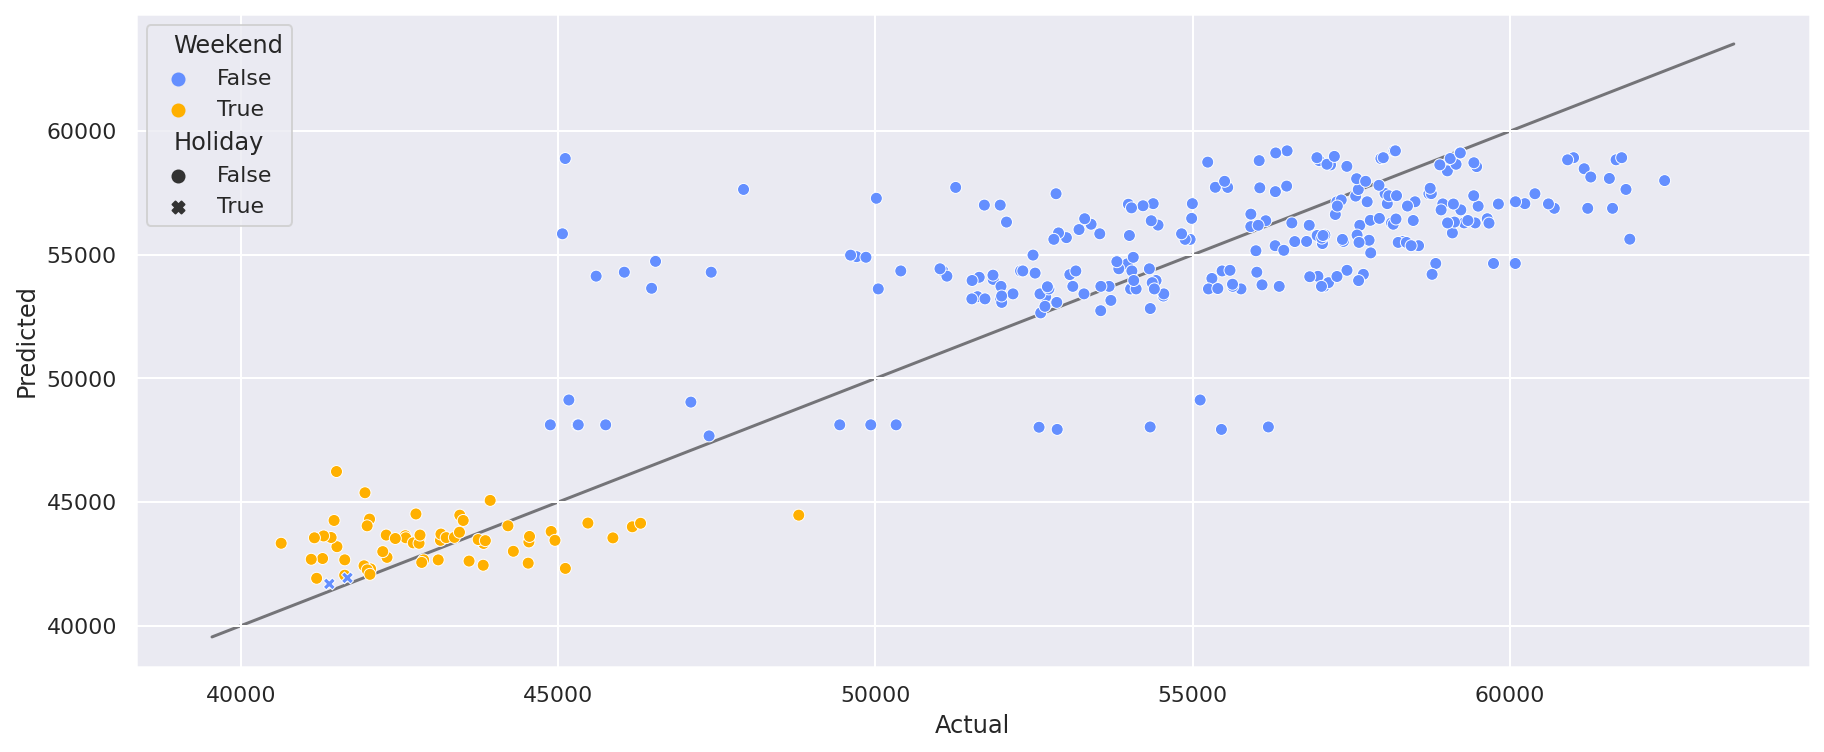

In [70]:
ann_reg = MLPRegressor(max_iter = 500, activation='relu', solver='lbfgs') # Neural network model for regression
ann_reg.fit(X_train, y_train)

ann_y_pred = ann_reg.predict(X_test) # Predict values
results_df["ann"] = ann_y_pred

df_metrics = pd.DataFrame({
    "metric" : [],"value"  : []
})
df_metrics.loc[len(df_metrics.index)] = ["Coefficients", ann_reg.coefs_]
df_metrics.loc[len(df_metrics.index)] = ["Intercept", ann_reg.intercepts_]

df_metrics.loc[len(df_metrics.index)] = ["Mean squared error", "{:.2f}".format(metrics.mean_squared_error(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Coefficient of determination", "{:.2f}".format(metrics.r2_score(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Mean Absolute Error", "{:.2f}".format(metrics.mean_absolute_error(y_test, baseline_y_pred))]
df_metrics.loc[len(df_metrics.index)] = ["Root Mean Squared Error", "{:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, baseline_y_pred)))]

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': ann_y_pred, 'Weekend': X_test['is_weekend'], 'Holiday': X_test['is_public_holiday']})
ax = sns.scatterplot(data=df_temp, x='Actual', y='Predicted', hue='Weekend', style='Holiday', palette=["#648fff", "#ffb000"]);
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
sns.lineplot(lims, lims, alpha=0.50, zorder=0, color='black');

In [45]:
df_metrics.head(6)

metric 
 value 
 
 
 
 
 0 
 Coefficients 
 [[[0.17757610432123247, -0.18726319618667084, ... 
 
 
 1 
 Intercept 
 [[0.018902543004499617, 0.036930854528154894, ... 
 
 
 2 
 Mean squared error 
 8297299.22 
 
 
 3 
 Coefficient of determination 
 0.77 
 
 
 4 
 Mean Absolute Error 
 2176.50 
 
 
 5 
 Root Mean Squared Error 
 2880.50

Multi-layer Perceptron regressor
‘relu’, the rectified linear unit function, returns f(x) = max(0, x)
‘lbfgs’ is an optimizer in the family of quasi-Newton methods.

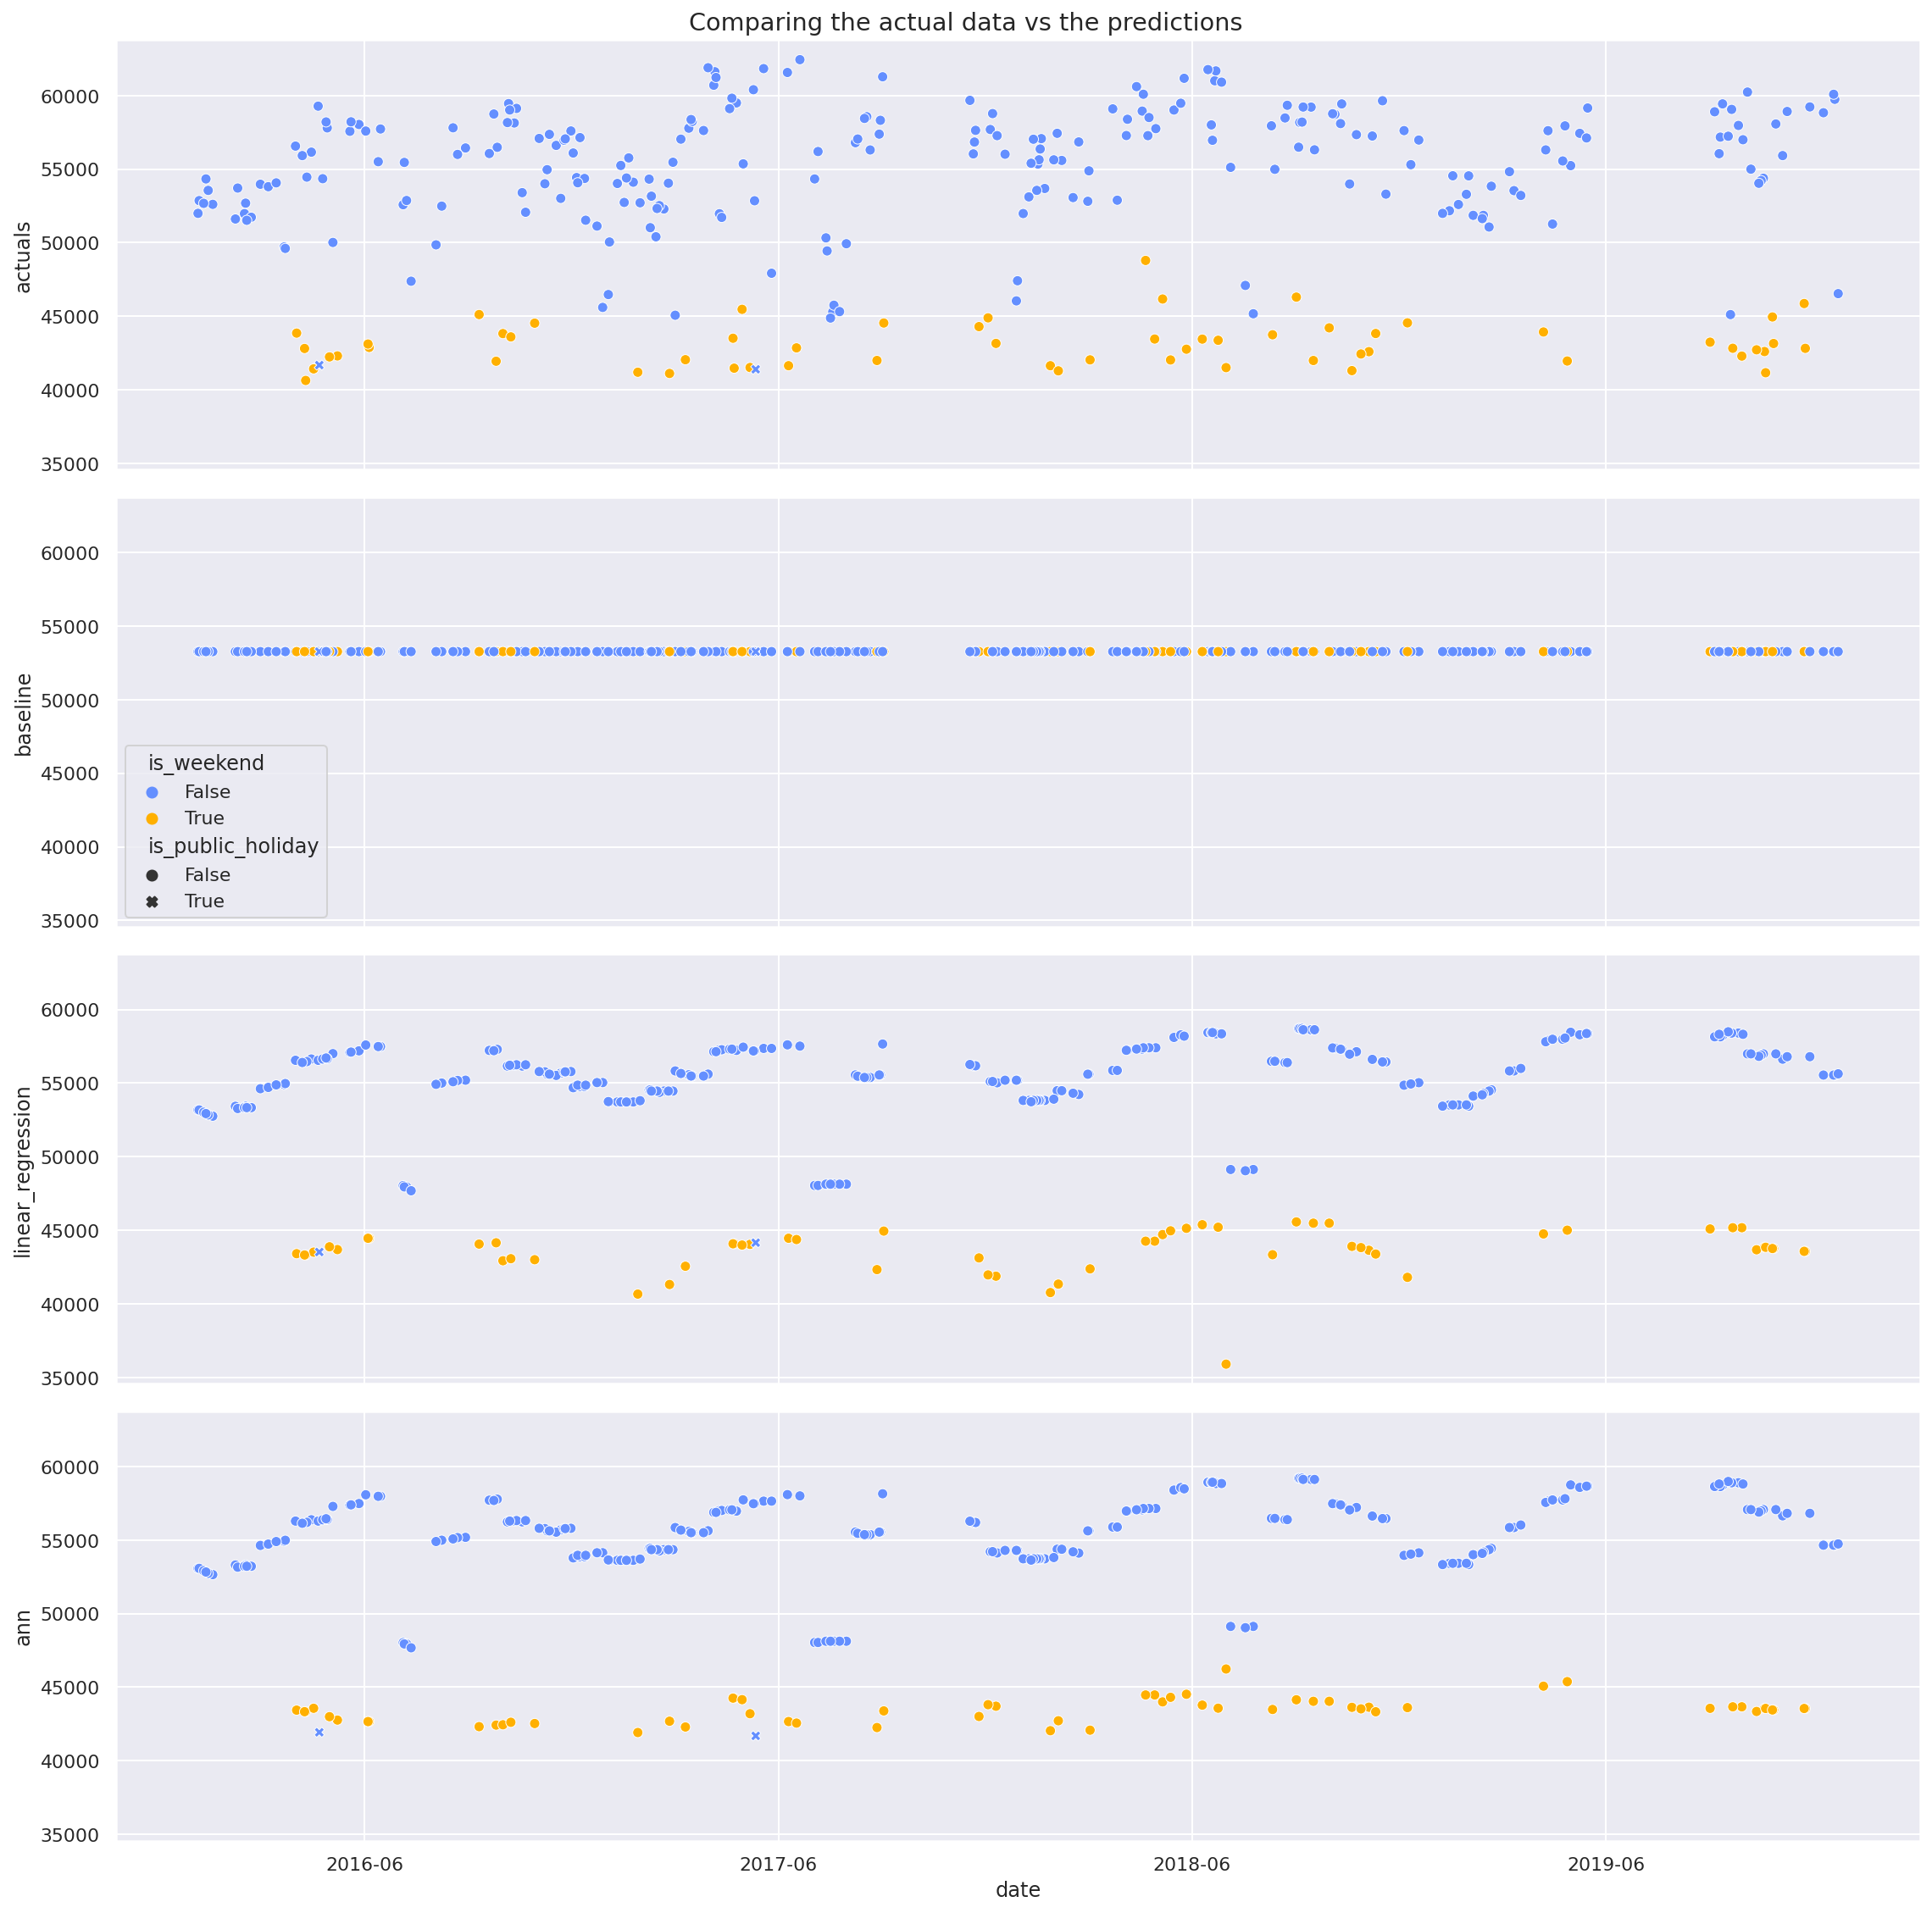

In [71]:
fig, axes = plt.subplots(4,1,figsize=(16,16), sharey='all', sharex='all')
plt.suptitle("Comparing the actual data vs the predictions")
g1 = sns.scatterplot(data=results_df, x='date', y='actuals', ax=axes[0], hue='is_weekend', style='is_public_holiday', legend=False, palette=["#648fff", "#ffb000"])
g2 = sns.scatterplot(data=results_df, x='date', y='baseline', ax=axes[1], hue='is_weekend', style='is_public_holiday', palette=["#648fff", "#ffb000"])
g3 = sns.scatterplot(data=results_df, x='date', y='linear_regression', ax=axes[2], hue='is_weekend', style='is_public_holiday', legend=False, palette=["#648fff", "#ffb000"])
g4 = sns.scatterplot(data=results_df, x='date', y='ann', ax=axes[3], hue='is_weekend', style='is_public_holiday', legend=False, palette=["#648fff", "#ffb000"])

g4.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=12))

plt.tight_layout()

Kan også se når det er sommerferie

# Genre

> - Which genre of data story did you use?

Primarily author-driven magazine- and annotated graph style, jupyter notebook hosted on nbviewer - insert ref to e. segel paper. only 'primarily' author driven bc we wanted it to be interactive, which fully author-driven stories are not. står noget i 4.4 om at blande author- og reader-driven

> - Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

* **Visual structuring:** N/A due to our genre?? (måske 'consistent visual platform')
* **Highlighting:** N/A due to our genre??
* **Transition guidance:** N/A due to our genre


> - Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

* **Ordering:** linear?
* **Interactivity:** To make our magazine-based visualization interactive, we used... hover highlighting/details (map), navigation buttons (bokeh) 
* **Messaging:** heavy focus on messaging. introductory text and/or summary/synthesis, annotations?, captions/headlines

# Visualizations
<!--
    * Explain the visualizations you've chosen.
    * Why are they right for the story you want to tell?
    * Why did we choose this way to plot?
-->


[Bevis på at farverne er colorblind safe så Sune bliver glad](https://davidmathlogic.com/colorblind/#%23648FFF-%23FFB000) - lav også for de andre farvede plots


nævn også overvejelser ift farveblindhed :^)
gestalt principles :^)




## COVID-19 and traffic

### Overview plots
In the COVID and traffic section, a line plot with two y-axes was the dominating plot. This was chosen due to the chronological order of the data, and allows for easy comparison between years - and the extra y-axis allows us to plot the hospitalizations in a readable manner. Overall, it creates a very good and intuitive plot.


### Bokeh plot

In order to increase the user's experience when reading our analysis, we used a [Bokeh plot](https://bokeh.org/) with a tabbed layout. This not only adds some interactivity, which can increase reader attention, but also ensures a more compact visualization format which reduces clutter. This is also done in compliance with the Gestalt principles; thematically similar plots are placed adjacent to each other.


## Visualizing geodata

We use a [Folium map plot](https://python-visualization.github.io/folium/) for visualizing the locations of the measuring stations in our dataset and additional descriptive data. By visualizing the data on a map of Copenhagen, we intend to give the reader a better connection to our analysis, as they may relate the locations to personal commuting routes. The plots have not been animated to visualize change over time, as we found the limited number of stationary locations, and their independence of each other, meant that an animation would not be suitable.


## Visualizing predicted data
Scatter plots -> noget med predictions

scatter plot og sårn


# Discussion
## Traffic prediction

We constructed multiple machine learning models that are able to predict the daily traffic based on gas prises. It also took other attributes into consideration e.g. if the date is a public holiday and/or a weekend. The months are considered as categorical features, making it possible to spot holiday seasons. The machine learning model could be extended with multiple categorical features e.g. weekday; however, this would probably lead to the model having too many features and being overly complex.

Our hypothesis was that there was a negative correlation between gas prices and traffic, since more people would like to take alternatives to save money. However, this is not the case; in fact, there is a positive correlation between gas prices and traffic. This might be because of the increased number of cars in and around Copenhagen. A fix for this could be to add the number of cars in and around Copenhagen, but that number might be harder to come across. A simpler fix would be to add the number of cars on Zealand for any given date. 

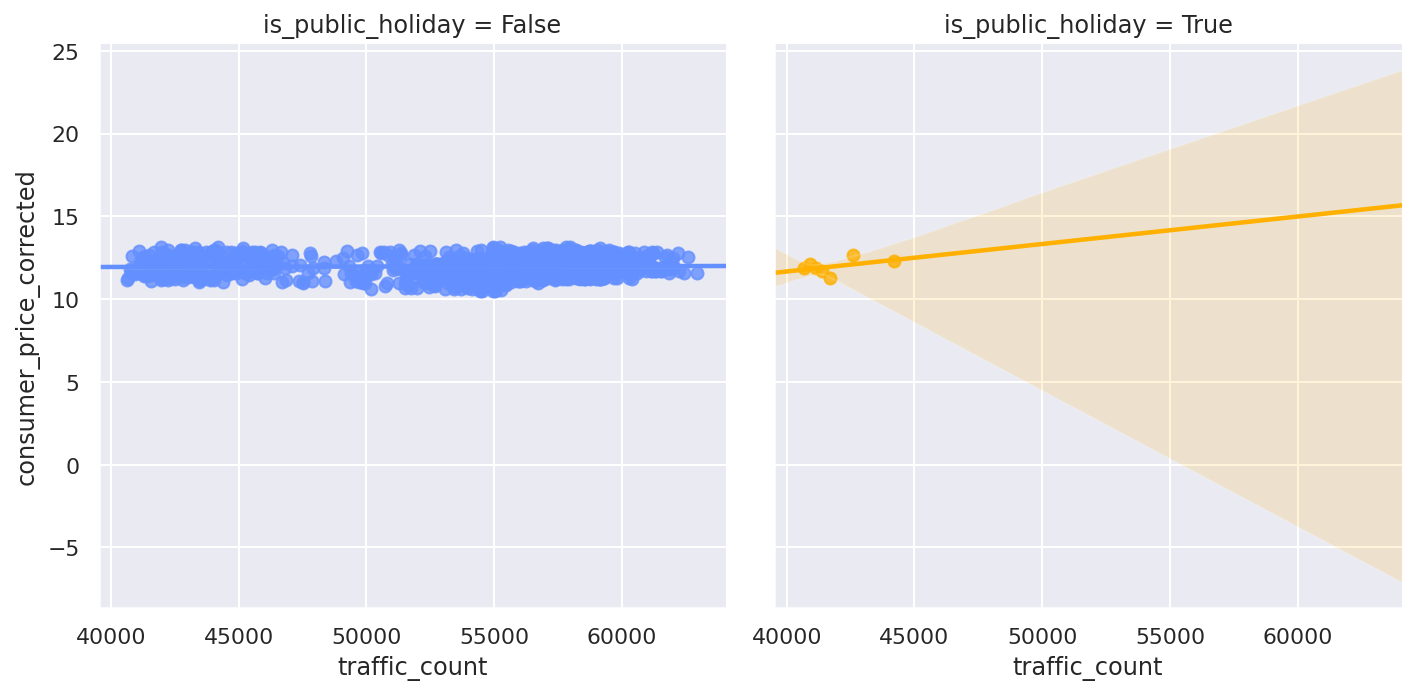

In [76]:
sns.lmplot(x="traffic_count", y="consumer_price_corrected", col="is_weekend", hue="is_weekend", data=df_traffic_gas, truncate=False, palette=["#648fff", "#ffb000"]);
sns.lmplot(x="traffic_count", y="consumer_price_corrected", col="is_public_holiday", hue="is_public_holiday", data=df_traffic_gas, truncate=False, palette=["#648fff", "#ffb000"]);

Multiple other steps could be taken to improve the model, train it on the unexpected e.g. traffic accidents and road closures. It may also be expanded to take multiple roads in to consideration to grasp a bigger picture. In future work, the Danish Road Directorate might use this data to choose when to make road repairs, implying the road or some of the road will be closed. 


## Traffic and COVID-19

The traffic and COVID section gave an introductory and exploratory insight to possible relations between hospitalizations and traffic counts across three roads. Some clear patterns were found, especially during the initial restrictions and policies announced by the government in March 2022, where a drastic drop in traffic was found at all locations, while they slowly climbed back to a more stable level as the restrictions continued to be loosened. On an hourly basis, decreases in traffic across daytime hours were found at all streets; however, the nighttime hours were only slightly or not at all impacted.

The visualizations and accompanying explanations allowed for quick and intuitive conclusions to be made, and provided some fundamental insights into the data used. However, the analysis is somewhat rudimentary and does not delve into deeper or more specific patterns or utilize specific statistical tools such as machine learning to identify behaviours. An interesting aspect the analysis could be evolved towards, would be to cover many more streets in Copenhagen and compute some measure of impact each street had due to COVID - essentially mapping which parts of Copenhagen saw the biggest COVID-related impacts on traffic, perhaps combined with some animated video illustrating changes over time. Additionally, more analysis could be performed to uncover detailed differences of rush hour peaks and durations when comparing 2020 with the reference years.

<div class="alert alert-block alert-success"> 

## **Contributions**

While we have collaborated on many tasks within the group, the primary focuses of each group member are stated below.

* s184192: COVID-19/Traffic Analysis, data preparation
* s184230: Machine learning/predictive analysis halløj, data extraction??
* s184234: Traffic data cleaning and preprocessing, preliminary analysis, idk
</div>

# References

- [COVID-19 time line](http://thinkeuropa.dk/politik/tidslinje-over-coronakrisen-hvad-skete-der-og-hvornaar)
- [Consumer price index on gas](https://www.dst.dk/da/Statistik/emner/oekonomi/prisindeks/forbrugerprisindeks?tab=dok)
- [Encoding time](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
- [Large increase in the number of cars on the roads](https://www.skm.dk/media/9140/aktuelle-skattetal-antal-biler-i-danmark.pdf)
- [Gas prices](https://www.drivkraftdanmark.dk/priser/benzin/)
- [Time between Symptom Onset, Hospitalisation and Recovery or Death: Statistical Analysis of Belgian COVID-19 Patients](https://www.mdpi.com/1660-4601/17/20/7560)